#  Evolutionary Multiple-objective Optimization (part for 4.0)

- This script is for those who want to improve their final grade from 3.0 to 4.0. 
- Your task is to implement any one evolutionary algorithm for multiple-objective optimization introduced during the lecture (NSGA-II/NSGA-III/MOEA/D; except for NSGA).
- Note that it has to be your implementation (using external libraries is forbidden; EXCEPTION: you can use the JECDM framework: https://jecdm.cs.put.poznan.pl -- but it is a relatively complex software, and much effort must be spent to understand how to use it).
- The problem to be solved is the portfolio optimization tackled during lab 1.
- You can use the same data and price predictions as you made for lab 1 (Bundle1.zip) or update them accordingly to the next stage if you participate in the portfolio game (it is up to you).
- Apart from the two-objective scenario, tackle also a three-objective one. As for the third objective, think about some reasonable risk-measure. E.g., you can maximize the number of non-zero weights, which should refer to minimizing risk by diversifying investments.
- Perform experimental evaluation of your implementation. You can use, e.g., the IDG or the HV metric to quantify the quality of populations constructed by the method.
- The experimental evaluation should be "reasonably extensive." E.g., run your method multiple times and average the results, show average convergence plots, do the sensitivity analysis (just four combinations of population size/generations will be enough), and depict some final populations. Also, compare the populations (only for 2D scenarios) with those generated by the ECM or WSM algorithm. Note that ECM and WSM already generate Pareto optimal solutions, so these can be considered good benchmarks for comparison.
- You can report your results here, i.e., in the jupyter notebook. You do not need to prepare any pdf report, etc. 

# Lab 1

Import the necessary libraries (numpy, pandas, matplotlib, cvxopt).

In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from sklearn.linear_model import Lasso
from scipy.signal import savgol_filter

# For reproducible randomness
np.random.seed(42)

Load the data from *Part1.txt files. Each file’s first line is the asset name, second line is N, and then N lines with “time price”.

In [27]:
def load_asset_data(data_folder="data"):
    asset_names = []
    asset_times = []
    asset_prices = []
    
    txt_files = [f for f in os.listdir(data_folder) if f.endswith("Part2.txt")]
    
    for fname in txt_files:
        path = os.path.join(data_folder, fname)
        with open(path, "r") as f:
            # 1) asset name
            asset_name = f.readline().strip()
    
            # 2) number of data points
            N_line = f.readline().strip()
            N = int(N_line)
    
            # 3) read time, price lines
            times = []
            prices = []
            for _ in range(N):
                line = f.readline().strip()
                t_str, p_str = line.split()
                times.append(float(t_str))
                prices.append(float(p_str))
    
            asset_names.append(asset_name)
            asset_times.append(times)
            asset_prices.append(prices)
    
    print(f"Found {len(asset_names)} assets.")
    print("First few asset names:", asset_names[:5])
    return asset_names, asset_times, asset_prices

asset_names, asset_times, asset_prices = load_asset_data()

Found 20 assets.
First few asset names: ['SafeAndCare', 'Fuel4', 'Moneymakers', 'MarsProject', 'CPU-XYZ']


In [28]:
def plot_asset_forecasts(asset_names, asset_times, asset_prices, forecast_results, training_offset=100, color="red"):
    """
    Plots forecast data for multiple assets on a 5x4 grid.
    
    Parameters:
      asset_names (list): List of asset names.
      asset_times (list of arrays/lists): Time points for each asset.
      asset_prices (list of arrays/lists): Historical prices for each asset.
      forecast_results (dict): Dictionary mapping asset names to forecast results for a specific method.
          Each entry for an asset should contain:
            - "price_at_training": forecast price at training time.
            - "price_at_forecast": forecast price at forecast time.
            - "full_reconstruction": (optional) tuple (recon_times, reconstruction) for the full reconstruction curve.
            - "forecast_time": (optional) forecast time (defaults to 200 if not provided).
      training_offset (int): The offset between forecast time and training time (default 100).
      color (str): Color for all forecast markers and lines.
    
    The function creates a grid of subplots (max 20 assets), where for each asset:
      - Historical data is plotted as black scatter points.
      - A training marker is plotted at (forecast_time - training_offset) using a circle marker.
      - A forecast marker is plotted at forecast_time using an 'x' marker.
      - If available, a reconstruction curve is plotted.
    """
    
    # Set up a 5x4 grid (max 20 assets)
    fig, axes = plt.subplots(5, 4, figsize=(20, 25))
    axes = axes.flatten()
    
    num_assets = min(len(asset_names), 20)
    
    for i in range(num_assets):
        ax = axes[i]
        asset = asset_names[i]
        times = np.array(asset_times[i])
        prices = np.array(asset_prices[i])
        
        # Plot historical data
        ax.scatter(times, prices, label="Historical Prices", color="black")
        
        # Retrieve forecast result for this asset
        forecast = forecast_results[asset]
        forecast_time = forecast.get("forecast_time", 200)
        training_time = forecast_time - training_offset
        
        # Plot training marker
        ax.scatter([training_time], [forecast["price_at_training"]],
                   marker="o", color=color, s=100,
                   label=f"Training @ t={training_time}")
        
        # Plot forecast marker
        ax.scatter([forecast_time], [forecast["price_at_forecast"]],
                   marker="x", color=color, s=100,
                   label=f"Forecast @ t={forecast_time}")
        
        # Plot reconstruction curve if available
        if "full_reconstruction" in forecast:
            recon_times, reconstruction = forecast["full_reconstruction"]
            ax.plot(recon_times, reconstruction, label="Reconstruction",
                    color=color, linewidth=2)
        
        ax.set_title(asset)
        ax.set_xlabel("Time")
        ax.set_ylabel("Price")
        ax.legend(fontsize='small')
    
    # Remove any unused subplots if there are fewer than 20 assets.
    for j in range(num_assets, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

In [29]:
all_results = {}

Perform a simple linear regression (degree=1) for each asset using times in [0,100]. Extrapolate to time=200 to get a predicted price. Convert that predicted price growth into a predicted return \mu[i].

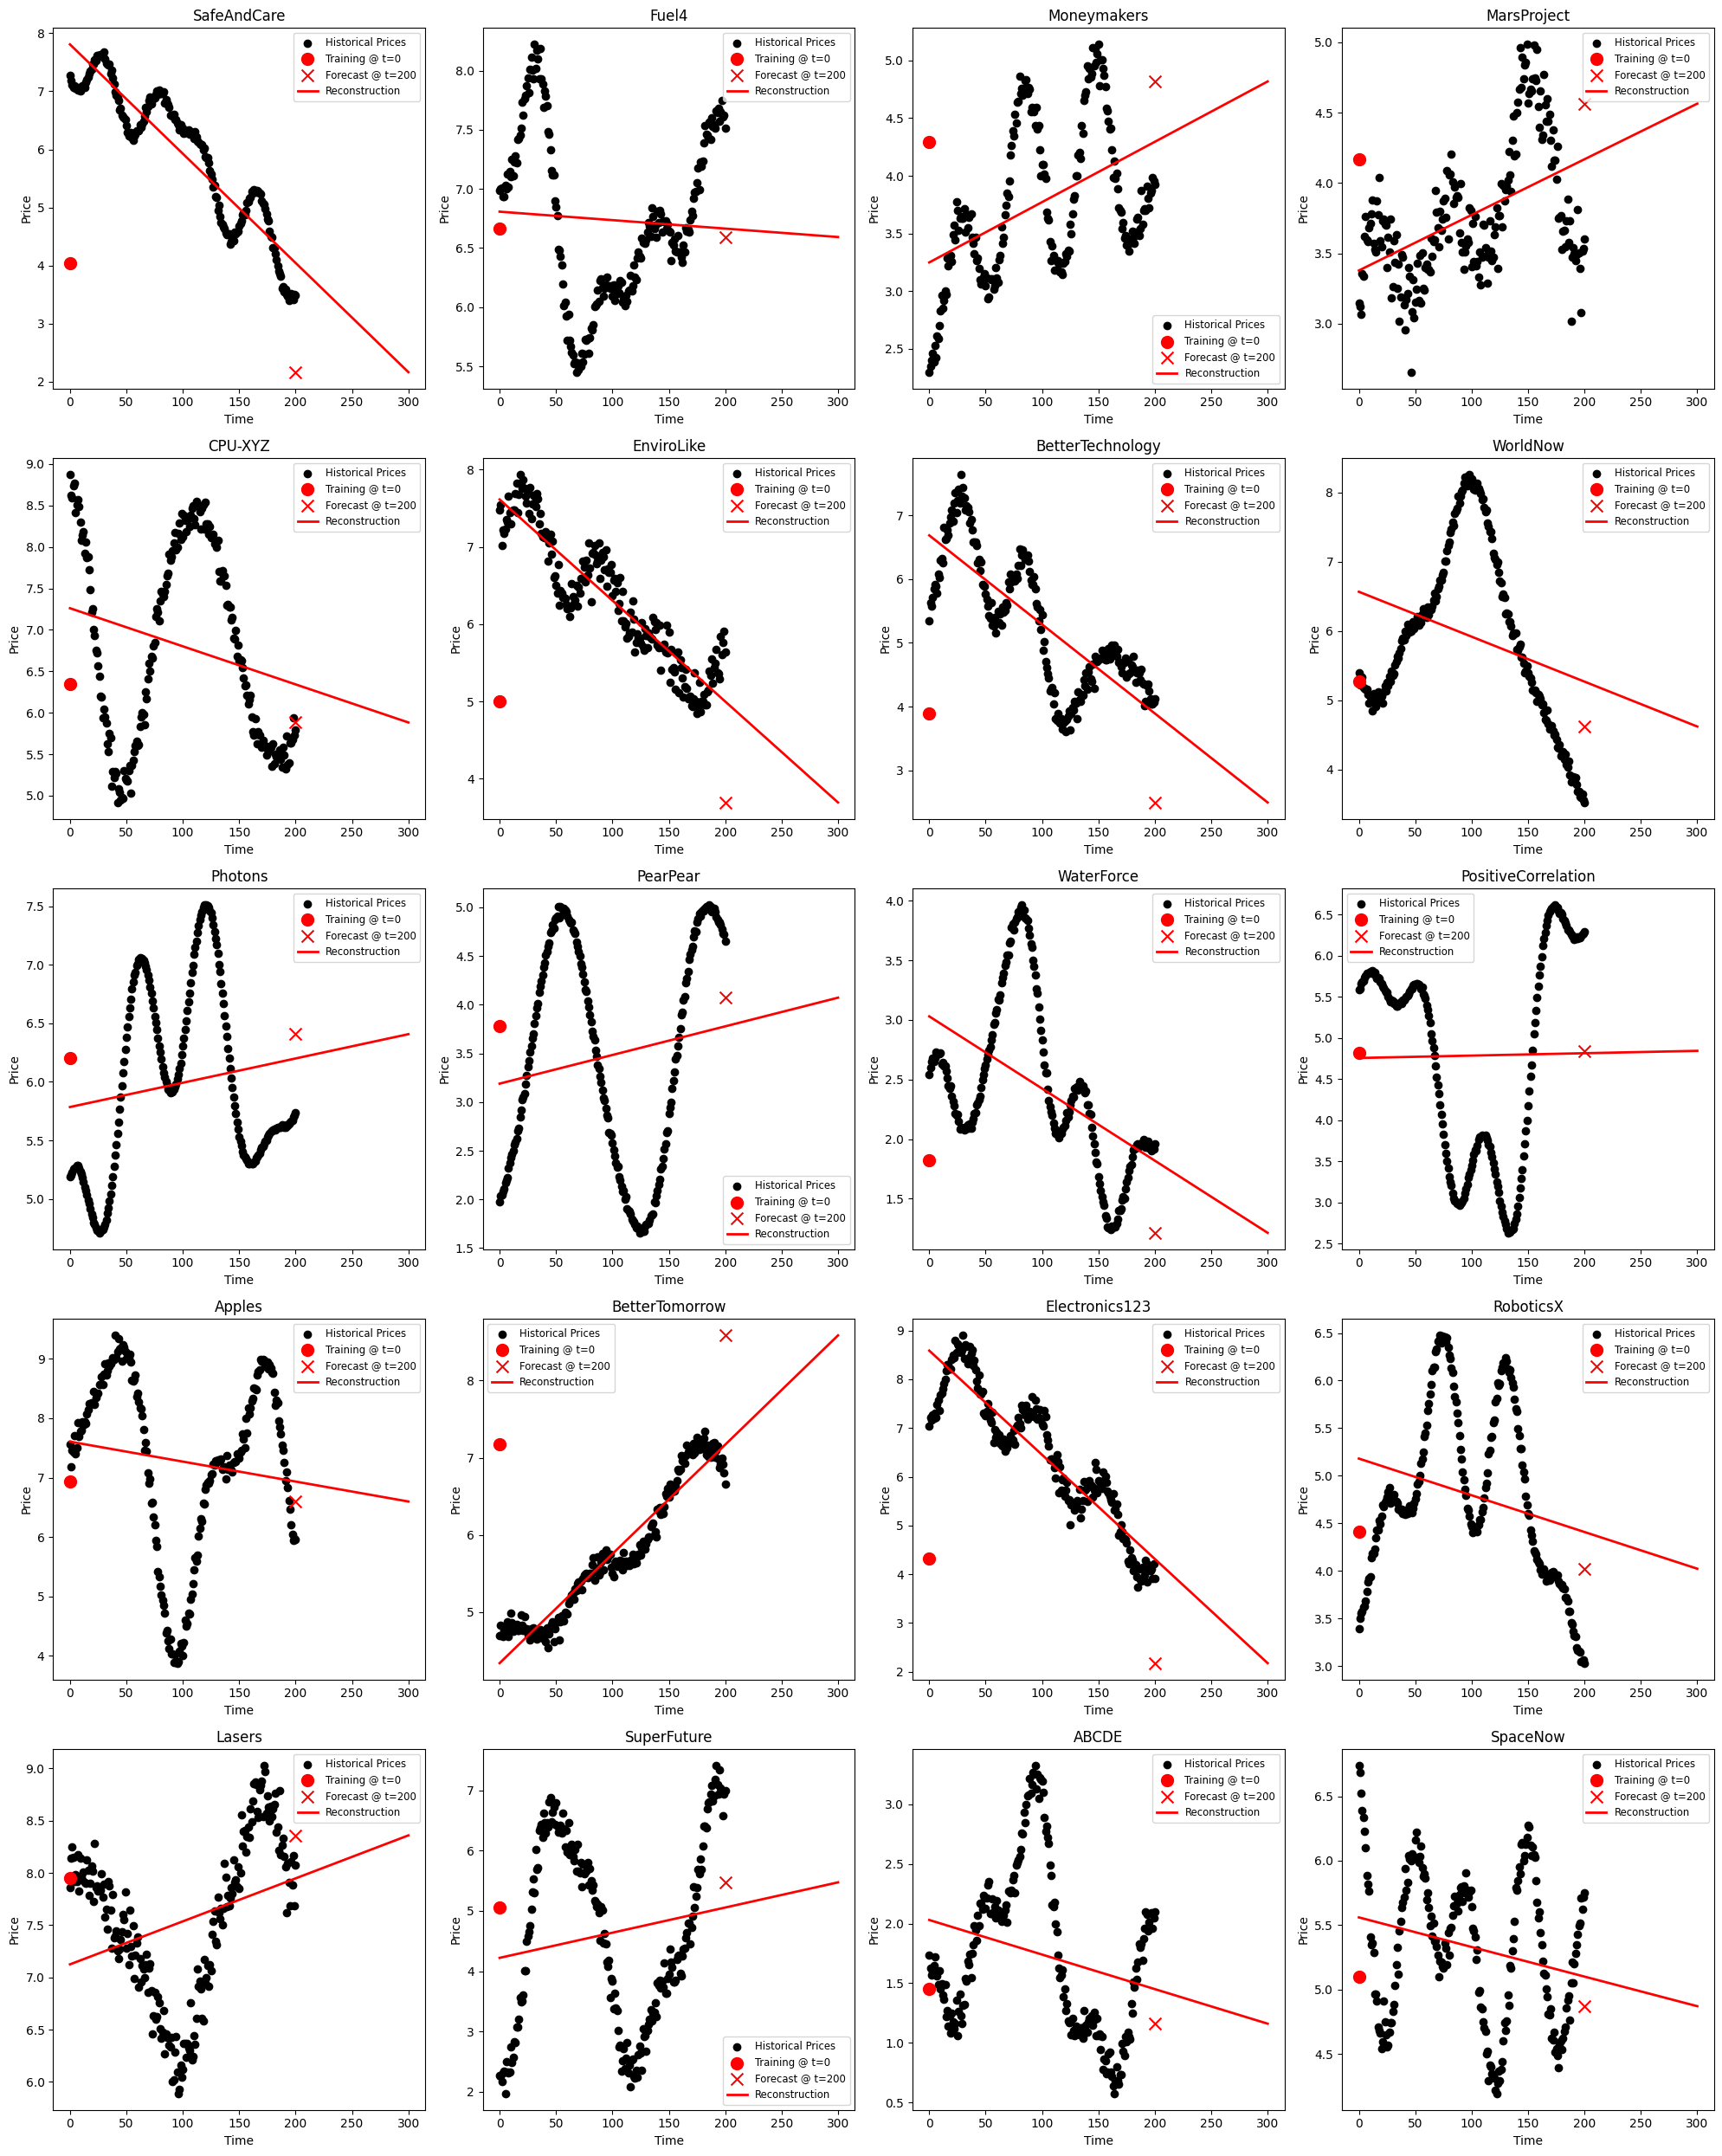

In [30]:
import numpy as np
from sklearn.linear_model import Lasso
from scipy.signal import savgol_filter

def baseline_forecast(asset_names, asset_times, asset_prices, training_start=0, training_end=100, forecast_time=200):
    """
    
    Returns a dictionary with, for each asset:
      - "model_predictions": (training_times, model_predictions) on [training_start, training_end]
      - "full_reconstruction": (recon_times, linear_reconstruction) on [training_start, forecast_time]
      - "price_at_training": predicted price at training_end
      - "price_at_forecast": predicted price at forecast_time
      - "predicted_return": computed return
    """
    baseline_pred = {}
    for i, name in enumerate(asset_names):
        times = np.array(asset_times[i])
        prices = np.array(asset_prices[i])
        # Use training data: times between training_start and training_end
        mask = (times >= training_start) & (times <= training_end)
        t_used = times[mask]
        p_used = prices[mask]
        coeffs = np.polyfit(t_used, p_used, deg=1)
        # Model predictions on training interval
        model_predictions = np.polyval(coeffs, t_used)
        price_at_training = np.polyval(coeffs, training_end)
        price_at_forecast = np.polyval(coeffs, forecast_time)
        predicted_return = (price_at_forecast - price_at_training) / price_at_training
        # Generate a new time vector for full reconstruction:
        recon_times = np.linspace(training_start, forecast_time, forecast_time - training_start)
        linear_reconstruction = np.polyval(coeffs, recon_times)
        
        baseline_pred[name] = {
            "model_predictions": (t_used, model_predictions),
            "full_reconstruction": (recon_times, linear_reconstruction),
            "price_at_training": price_at_training,
            "price_at_forecast": price_at_forecast,
            "predicted_return": predicted_return
        }
    return baseline_pred
    
linear_results = baseline_forecast(asset_names, asset_times, asset_prices,
                                          training_start=0, training_end=200, forecast_time=300)
plot_asset_forecasts(asset_names, asset_times, asset_prices, linear_results, training_offset=200, color="red")


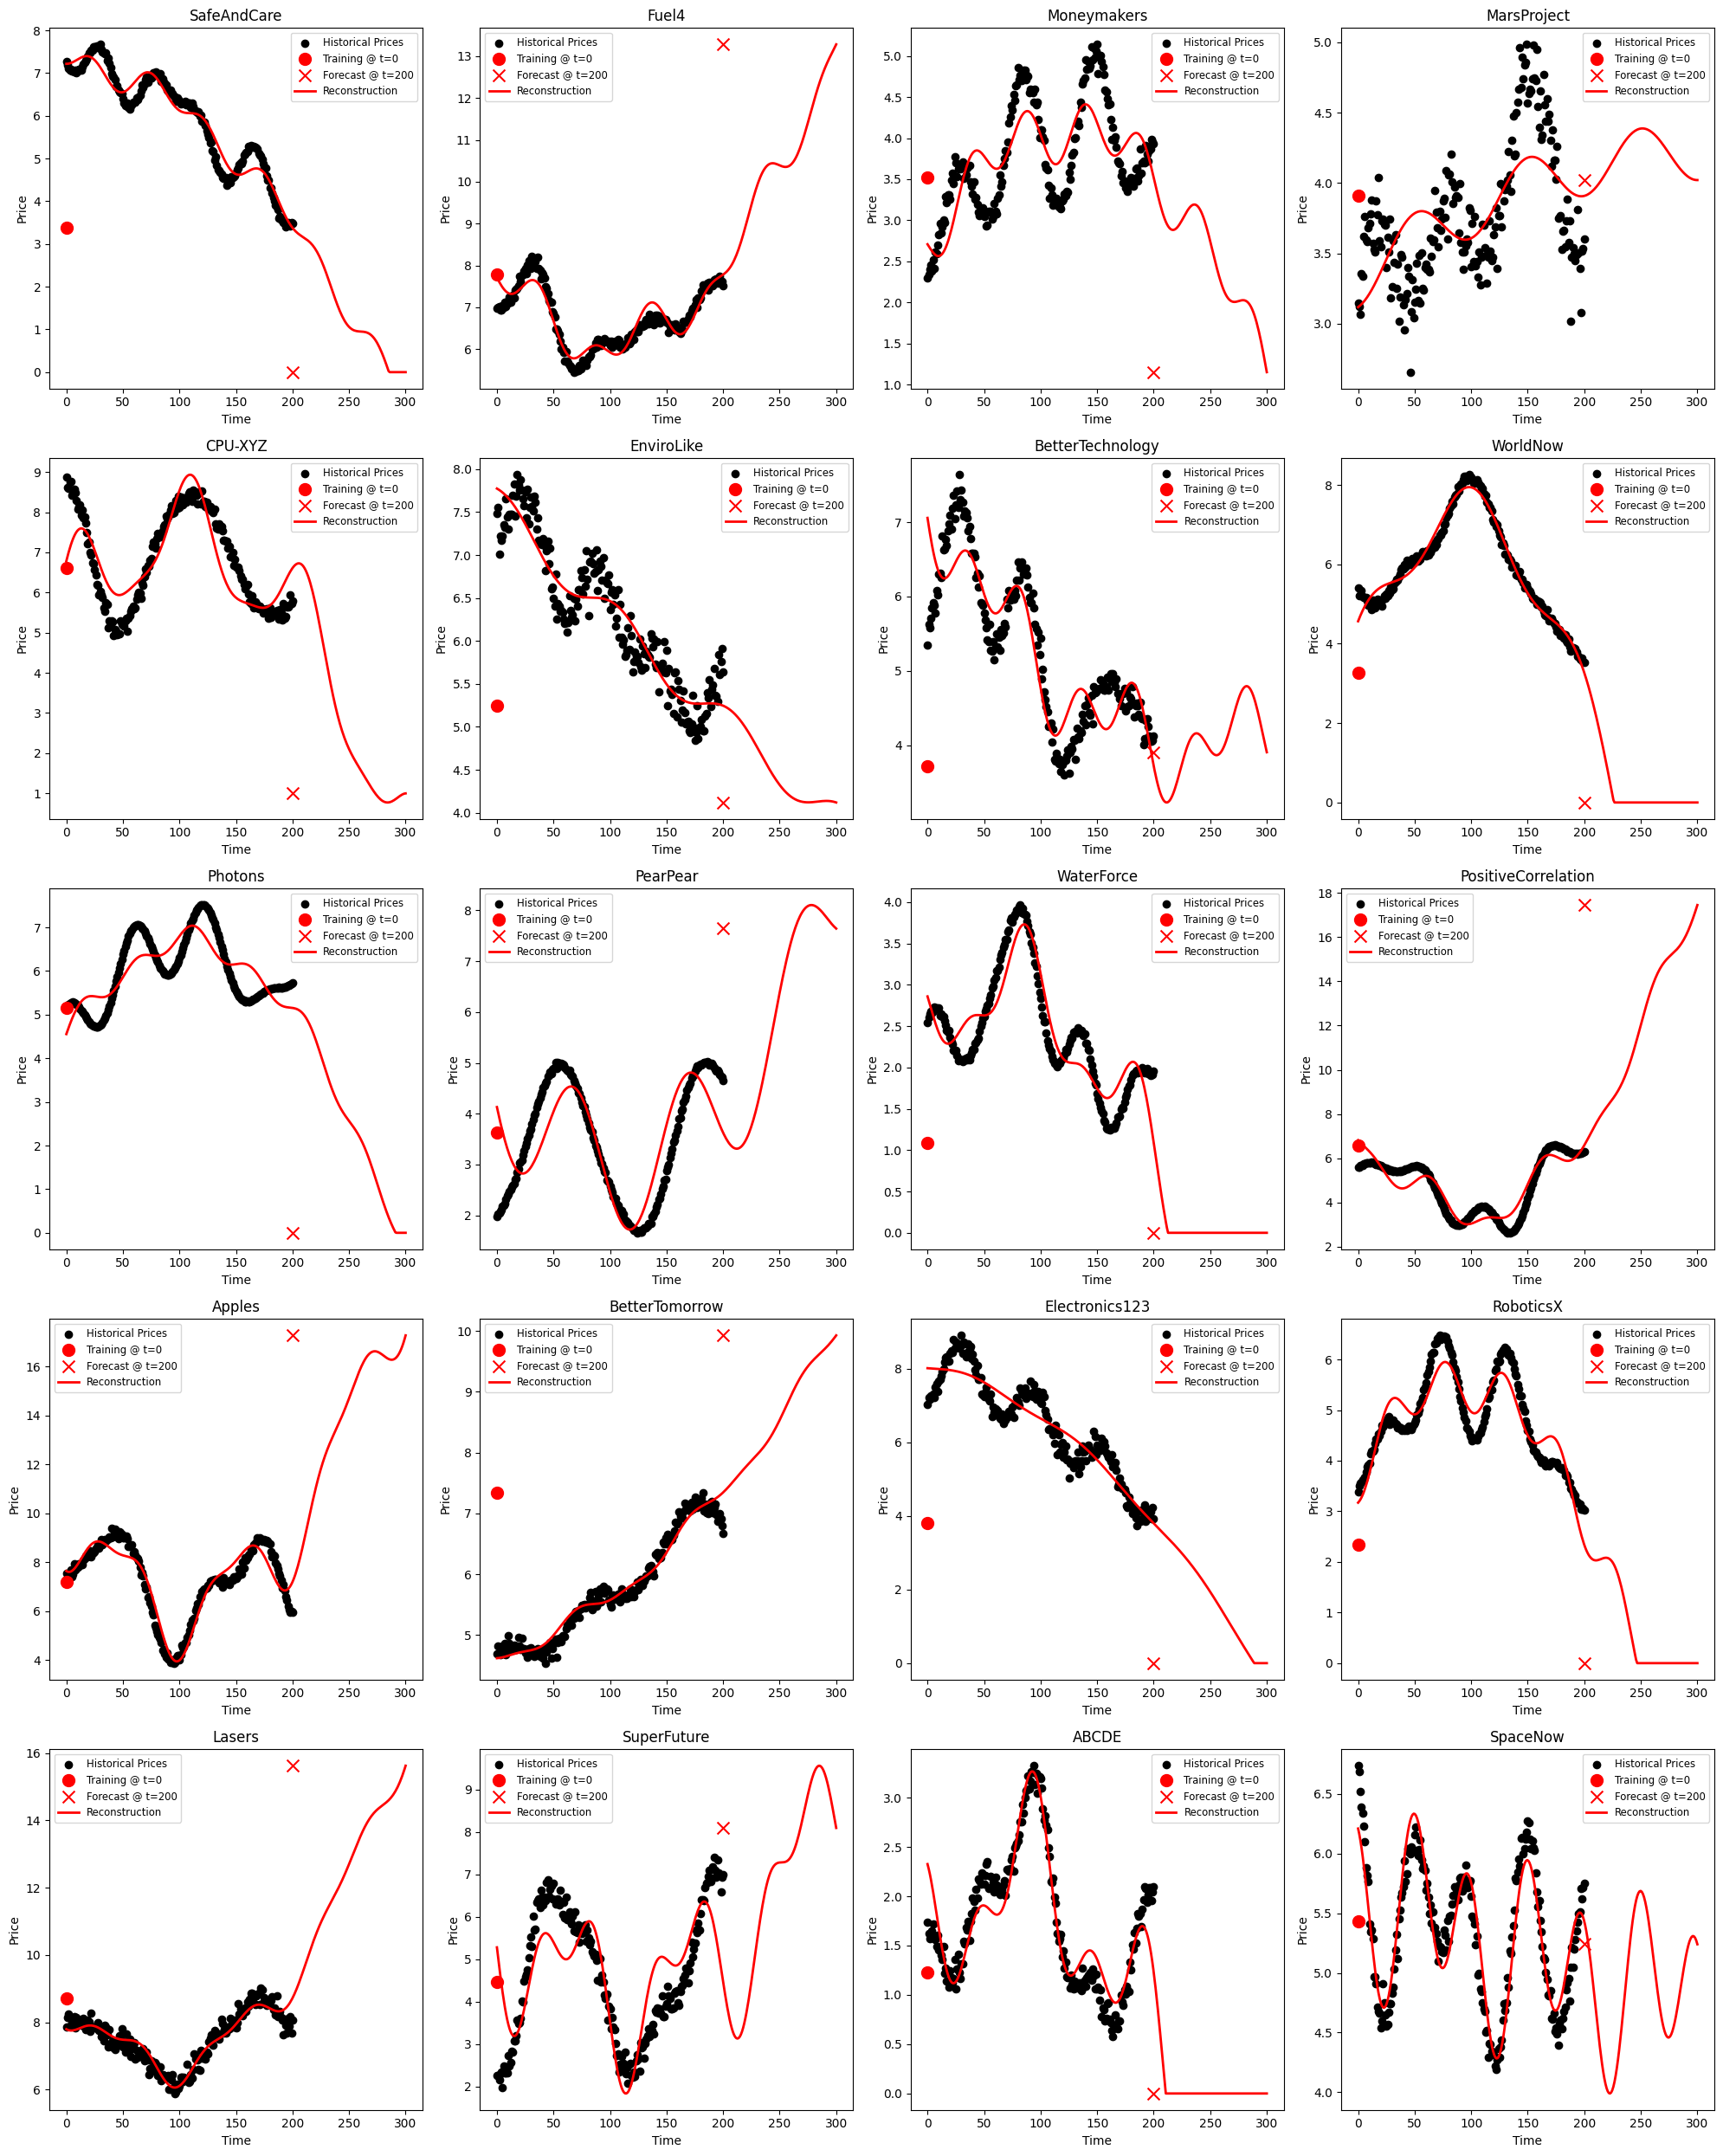

In [31]:
import numpy as np
from scipy.signal import savgol_filter
from sklearn.linear_model import Lasso

def build_candidate_library(x, candidate_frequencies):
    """
    Build a design matrix with a constant, linear, quadratic term,
    and for each candidate frequency, sine and cosine functions.
    """
    features = []
    feature_names = []
    features.append(np.ones_like(x))
    feature_names.append('1')
    features.append(x)
    feature_names.append('x')
    features.append(x**2)
    feature_names.append('x^2')
    for w in candidate_frequencies:
        features.append(np.sin(2 * np.pi * w * x))
        feature_names.append(f'sin(2π*{w:.2f}x)')
        features.append(np.cos(2 * np.pi * w * x))
        feature_names.append(f'cos(2π*{w:.2f}x)')
    X = np.column_stack(features)
    return X, feature_names

def sparse_forecast(asset_names, asset_times, asset_prices, training_start=0, training_end=100, forecast_time=200, alpha=0.01):
    """
    For each asset, perform:
      1. Denoise the full signal.
      2. From training data ([training_start, training_end]), perform FFT on the denoised data
         to select candidate frequencies.
      3. Compute the linear trend using raw training data.
      4. Subtract the trend from the denoised training data.
      5. Build a candidate library over the full time series.
      6. Fit a sparse (LASSO) model on the detrended training data.
      7. Reconstruct the full signal (by adding back the extrapolated trend).
      8. Evaluate the learned function at any new x using the candidate library.
    """
    sparse_pred = {}
    for i, name in enumerate(asset_names):
        times = np.array(asset_times[i])
        prices = np.array(asset_prices[i])
        
        # 1. Denoise the full signal.
        prices_denoised = savgol_filter(prices, window_length=11, polyorder=2)
        
        # 2. Restrict to training data and perform FFT on the denoised training data.
        mask = (times >= training_start) & (times <= training_end)
        t_train = times[mask]
        p_train_denoised = prices_denoised[mask]
        N = len(t_train)
        T = t_train[1] - t_train[0] if N > 1 else 1
        fft_vals = np.fft.fft(p_train_denoised)
        freq = np.fft.fftfreq(N, T)
        pos_mask = freq > 0
        freq_pos = freq[pos_mask]
        fft_magnitude = np.abs(fft_vals)[pos_mask]
        threshold = np.mean(fft_magnitude) + 1 * np.std(fft_magnitude)
        candidate_frequencies = freq_pos[fft_magnitude > threshold]
        candidate_frequencies = np.unique(np.round(candidate_frequencies, 2))
        
        # 3. Compute trend using raw training data (to preserve the true slope).
        p_train_raw = prices[mask]
        coeffs_trend = np.polyfit(t_train, p_train_raw, 1)
        trend_train = np.polyval(coeffs_trend, t_train)
        
        # 4. Subtract the trend from the denoised training data.
        p_train_detrended = p_train_denoised - trend_train
        
        # 5. Build candidate library over the full time series.
        X, _ = build_candidate_library(times, candidate_frequencies)
        X_train = X[mask, :]
        
        # 6. Fit sparse regression (LASSO) on detrended training data.
        lasso = Lasso(alpha=alpha, max_iter=10000)
        lasso.fit(X_train, p_train_detrended)
        coefs = lasso.coef_
        intercept_sparse = lasso.intercept_
        
        # 7. Reconstruct the full signal.
        p_detrended_reconstructed = intercept_sparse + X.dot(coefs)
        trend_full = np.polyval(coeffs_trend, times)
        p_reconstructed = p_detrended_reconstructed + trend_full
        # Clip negative values in the training reconstruction:
        p_reconstructed = np.maximum(p_reconstructed, 0)
        
        # 8. Define a prediction function that evaluates the learned function at any new x.
        def predict_new(x_new):
            X_new, _ = build_candidate_library(np.array([x_new]), candidate_frequencies)
            value = intercept_sparse + X_new.dot(coefs) + np.polyval(coeffs_trend, x_new)
            # Return non-negative prediction.
            return max(value.item(), 0)
        
        price_at_training = predict_new(training_end)
        price_at_forecast = predict_new(forecast_time)
        predicted_return = (price_at_forecast - price_at_training) / price_at_training
        
        # Generate a new reconstruction time vector from training_start to forecast_time.
        recon_times = np.linspace(training_start, forecast_time, forecast_time - training_start)
        X_new, _ = build_candidate_library(recon_times, candidate_frequencies)
        p_detrended_new = intercept_sparse + X_new.dot(coefs)
        p_reconstructed_new = p_detrended_new + np.polyval(coeffs_trend, recon_times)
        # Clip negative values.
        p_reconstructed_new = np.maximum(p_reconstructed_new, 0)
        
        sparse_pred[name] = {
            "model_predictions": (t_train, np.maximum(p_reconstructed[mask], 0)),  # for diagnostic on training data
            "full_reconstruction": (recon_times, p_reconstructed_new),
            "price_at_training": price_at_training,
            "price_at_forecast": price_at_forecast,
            "predicted_return": predicted_return
        }
    return sparse_pred

# Example usage:
sparse_results = sparse_forecast(asset_names, asset_times, asset_prices,
                                 training_start=0, training_end=200, forecast_time=300)
plot_asset_forecasts(asset_names, asset_times, asset_prices, sparse_results, training_offset=200, color="red")


Illustrate your predictions by plotting the historical data and the linear fit for a few assets, plus the forecasted price at t=200.

/Users/dromaniv/multiple-objective-optimization/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/dromaniv/multiple-objective-optimization/.venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/dromaniv/multiple-objective-optimization/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/dromaniv/multiple-objective-optimization/.venv/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization fail

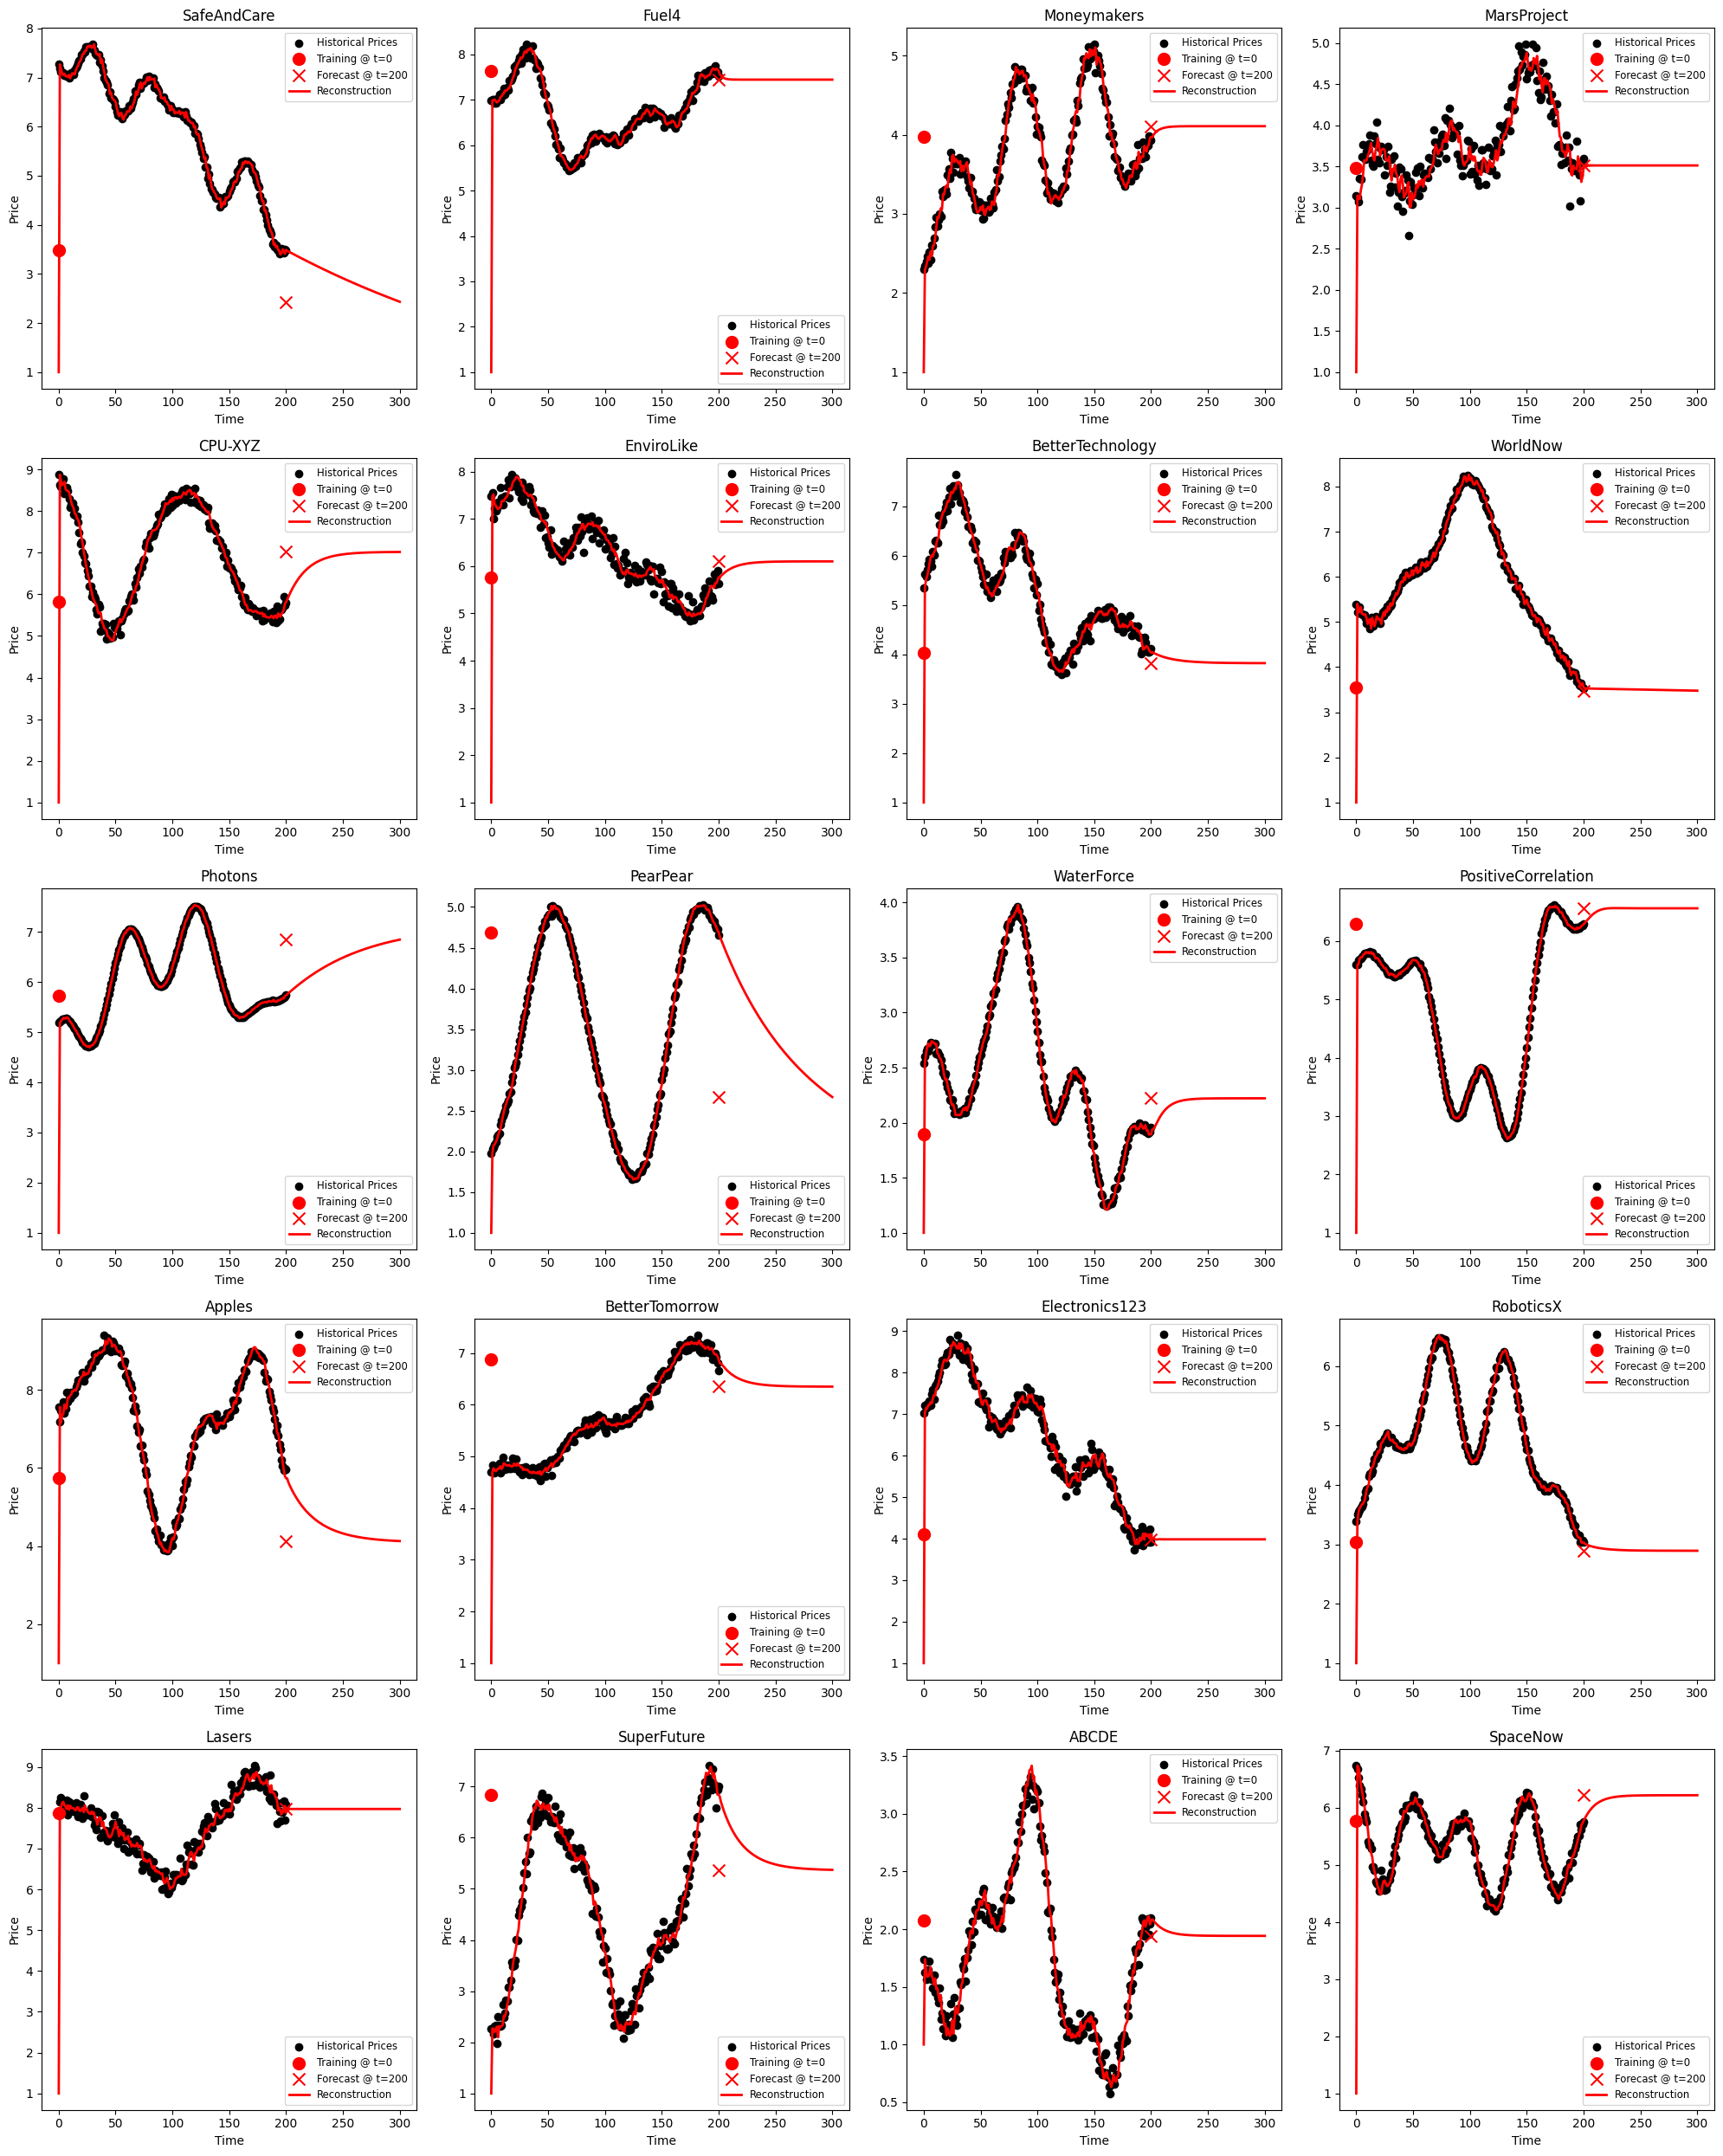

In [32]:
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

def arima_forecast(asset_names, asset_times, asset_prices, training_start=0, training_end=100, forecast_time=200, order=(1,1,1), use_log=True):
    """
    For each asset, fit an ARIMA model on training data ([training_start, training_end])
    and forecast up to forecast_time.
    
    If use_log is True, a logarithmic transformation is applied to the training data,
    and forecasts are exponentiated to ensure all predictions are positive.
    
    Computes expected return as:
      (price_at_forecast - price_at_training) / price_at_training.
    
    Returns a dictionary with, for each asset:
      - "model_predictions": (training_times, in-sample predictions) on [training_start, training_end]
      - "full_reconstruction": (recon_times, arima_predictions) on [training_start, forecast_time]
      - "price_at_training": predicted price at training_end (last training prediction)
      - "price_at_forecast": predicted price at forecast_time (last forecast value)
      - "predicted_return": computed return
    """
    arima_pred = {}
    for i, name in enumerate(asset_names):
        times = np.array(asset_times[i])
        prices = np.array(asset_prices[i])
        
        # Select training data based on the provided time window.
        mask = (times >= training_start) & (times <= training_end)
        t_train = times[mask]
        p_train = prices[mask]
        
        if use_log:
            # Check that all training prices are positive.
            if np.any(p_train <= 0):
                raise ValueError(f"Asset {name} has non-positive prices; cannot use log transform.")
            p_train_trans = np.log(p_train)
        else:
            p_train_trans = p_train.copy()
        
        # Fit the ARIMA model on the (possibly transformed) training data.
        try:
            model = ARIMA(p_train_trans, order=order)
            model_fit = model.fit()
        except Exception as e:
            print(f"ARIMA fit failed for asset {name}: {e}")
            continue
        
        # In-sample prediction on the training data.
        pred_train_trans = model_fit.predict(start=0, end=len(p_train_trans)-1)
        # If using log transform, exponentiate predictions.
        if use_log:
            pred_train = np.exp(pred_train_trans)
        else:
            pred_train = pred_train_trans
        
        # Determine forecast steps.
        forecast_steps = int(forecast_time - training_end)
        if forecast_steps <= 0:
            raise ValueError("forecast_time must be greater than training_end")
        
        # Forecast future values.
        forecast_trans = model_fit.forecast(steps=forecast_steps)
        if use_log:
            forecast = np.exp(forecast_trans)
        else:
            forecast = forecast_trans
        
        # Construct full time series reconstruction.
        forecast_times = np.arange(training_end + 1, forecast_time + 1)
        full_times = np.concatenate([t_train, forecast_times])
        full_predictions = np.concatenate([pred_train, forecast])
        
        # Get the predicted price at training_end and forecast_time.
        price_at_training = pred_train[-1]
        price_at_forecast = forecast[-1]
        predicted_return = (price_at_forecast - price_at_training) / price_at_training
        
        # In case any residual negatives appear (shouldn't happen with log-transform):
        full_predictions = np.maximum(full_predictions, 0)
        
        arima_pred[name] = {
            "model_predictions": (t_train, pred_train),
            "full_reconstruction": (full_times, full_predictions),
            "price_at_training": price_at_training,
            "price_at_forecast": price_at_forecast,
            "predicted_return": predicted_return
        }
    return arima_pred

# Example usage:
# (Ensure asset_names, asset_times, asset_prices, and plot_asset_forecasts are defined.)
arima_results = arima_forecast(asset_names, asset_times, asset_prices,
                               training_start=0, training_end=200, forecast_time=300,
                               order=(2,1,2), use_log=True)
plot_asset_forecasts(asset_names, asset_times, asset_prices, arima_results, training_offset=200, color="red")


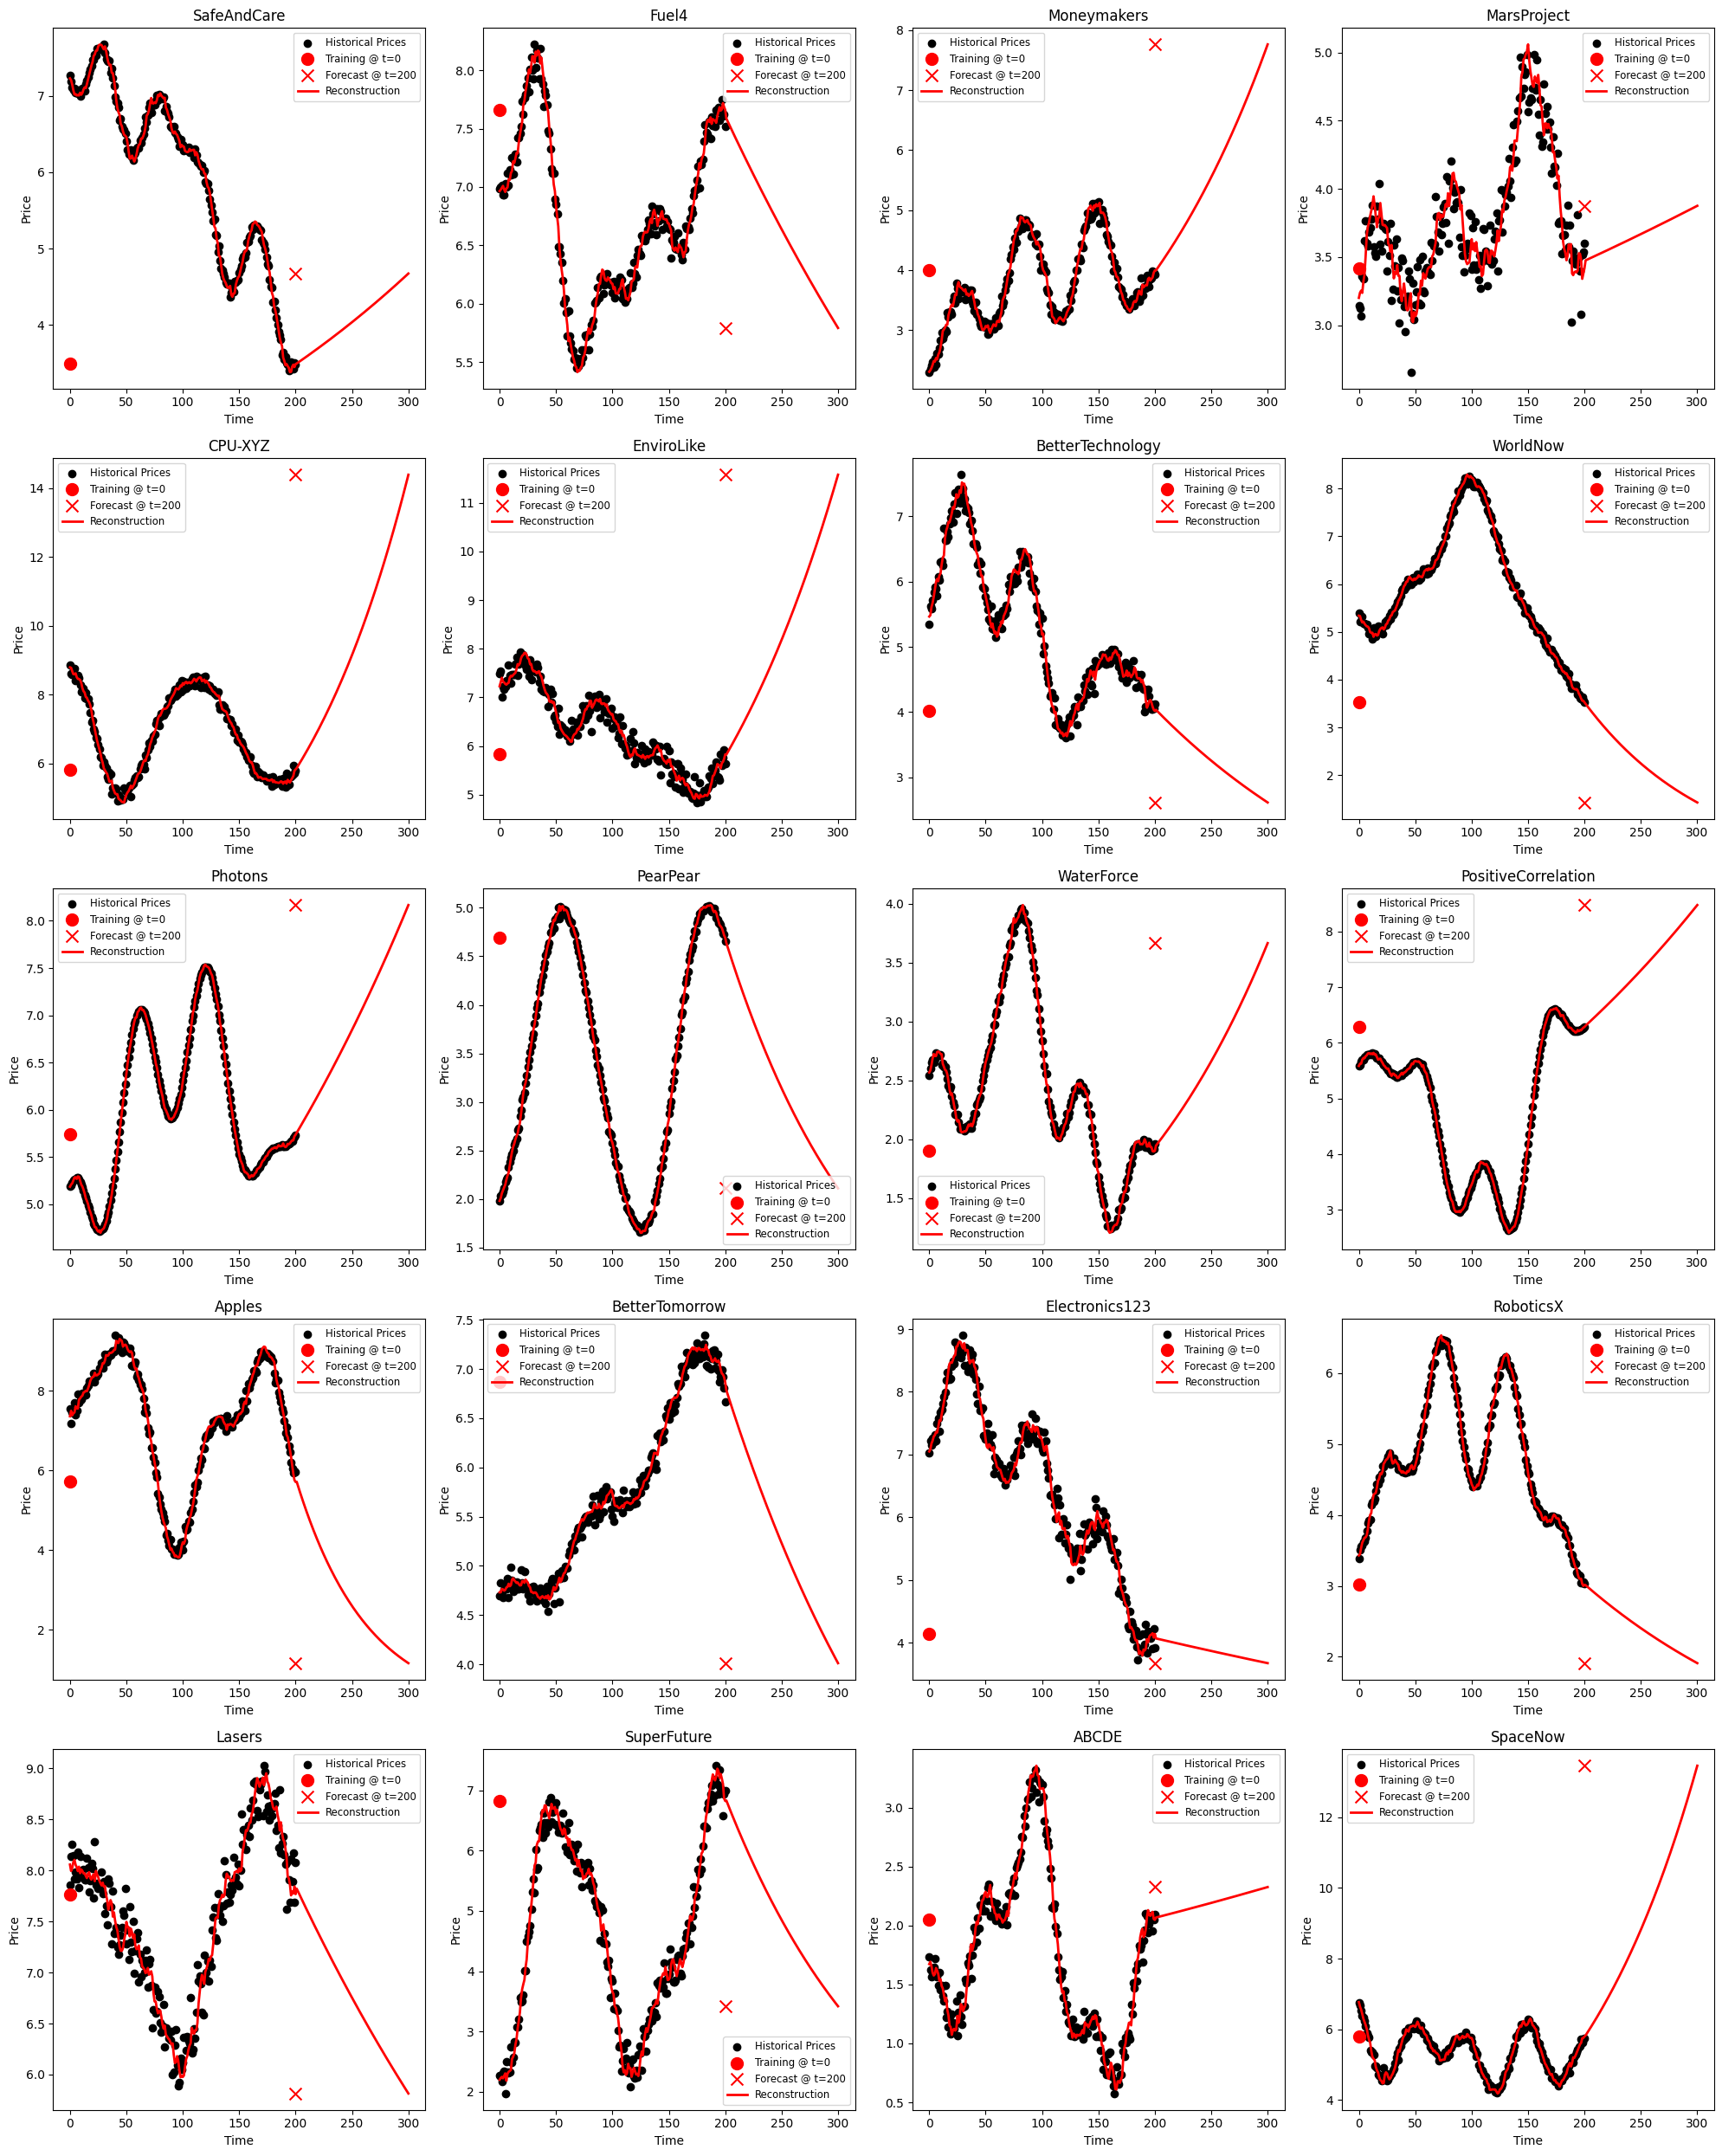

In [33]:
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def exponential_smoothing_forecast(asset_names, asset_times, asset_prices,
                                   training_start=0, training_end=100, forecast_time=200,
                                   trend='add', seasonal=None, seasonal_periods=None,
                                   use_multiplicative=False):
    """
    Returns:
      A dictionary where each key is an asset name and each value is a dictionary containing:
        - "model_predictions": (training_times, in-sample predictions) on [training_start, training_end]
        - "full_reconstruction": (recon_times, exponential smoothing predictions) on [training_start, forecast_time]
        - "price_at_training": predicted price at training_end (last in-sample prediction)
        - "price_at_forecast": predicted price at forecast_time (last forecast value)
        - "predicted_return": computed return as (price_at_forecast - price_at_training) / price_at_training
    """
    exp_pred = {}
    for i, name in enumerate(asset_names):
        times = np.array(asset_times[i])
        prices = np.array(asset_prices[i])
        
        # Select training data based on the provided time window.
        mask = (times >= training_start) & (times <= training_end)
        t_train = times[mask]
        p_train = prices[mask]
        
        # Optionally, use multiplicative components if data are strictly positive.
        if use_multiplicative:
            if np.any(p_train <= 0):
                print(f"Warning: Asset {name} has non-positive values. Multiplicative model not appropriate. Using additive model.")
            else:
                trend = 'mul'
                if seasonal is not None:
                    seasonal = 'mul'
        
        # Fit the exponential smoothing model.
        try:
            model = ExponentialSmoothing(p_train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods)
            model_fit = model.fit()
        except Exception as e:
            print(f"Exponential Smoothing model fit failed for asset {name}: {e}")
            continue
        
        # In-sample fitted values (for training period).
        pred_train = model_fit.fittedvalues
        # Clip negative values.
        pred_train = np.maximum(pred_train, 0)
        
        # Determine number of forecast steps.
        forecast_steps = int(forecast_time - training_end)
        if forecast_steps <= 0:
            raise ValueError("forecast_time must be greater than training_end")
        
        # Forecast future values.
        forecast_values = model_fit.forecast(steps=forecast_steps)
        forecast_values = np.maximum(forecast_values, 0)
        
        # Generate a time vector for the forecast period.
        forecast_times = np.arange(training_end + 1, forecast_time + 1)
        # Build the full reconstruction time series.
        full_times = np.concatenate([t_train, forecast_times])
        full_predictions = np.concatenate([pred_train, forecast_values])
        full_predictions = np.maximum(full_predictions, 0)  # ensure non-negative
        
        # Get the predicted prices at training_end and forecast_time.
        price_at_training = pred_train[-1]
        price_at_forecast = forecast_values[-1]
        predicted_return = (price_at_forecast - price_at_training) / price_at_training
        
        exp_pred[name] = {
            "model_predictions": (t_train, pred_train),
            "full_reconstruction": (full_times, full_predictions),
            "price_at_training": price_at_training,
            "price_at_forecast": price_at_forecast,
            "predicted_return": predicted_return
        }
    return exp_pred

exp_results = exponential_smoothing_forecast(asset_names, asset_times, asset_prices,
                                             training_start=0, training_end=200, forecast_time=300,
                                             trend='add', seasonal=None, seasonal_periods=None,
                                             use_multiplicative=True)
plot_asset_forecasts(asset_names, asset_times, asset_prices, exp_results, training_offset=200, color="red")


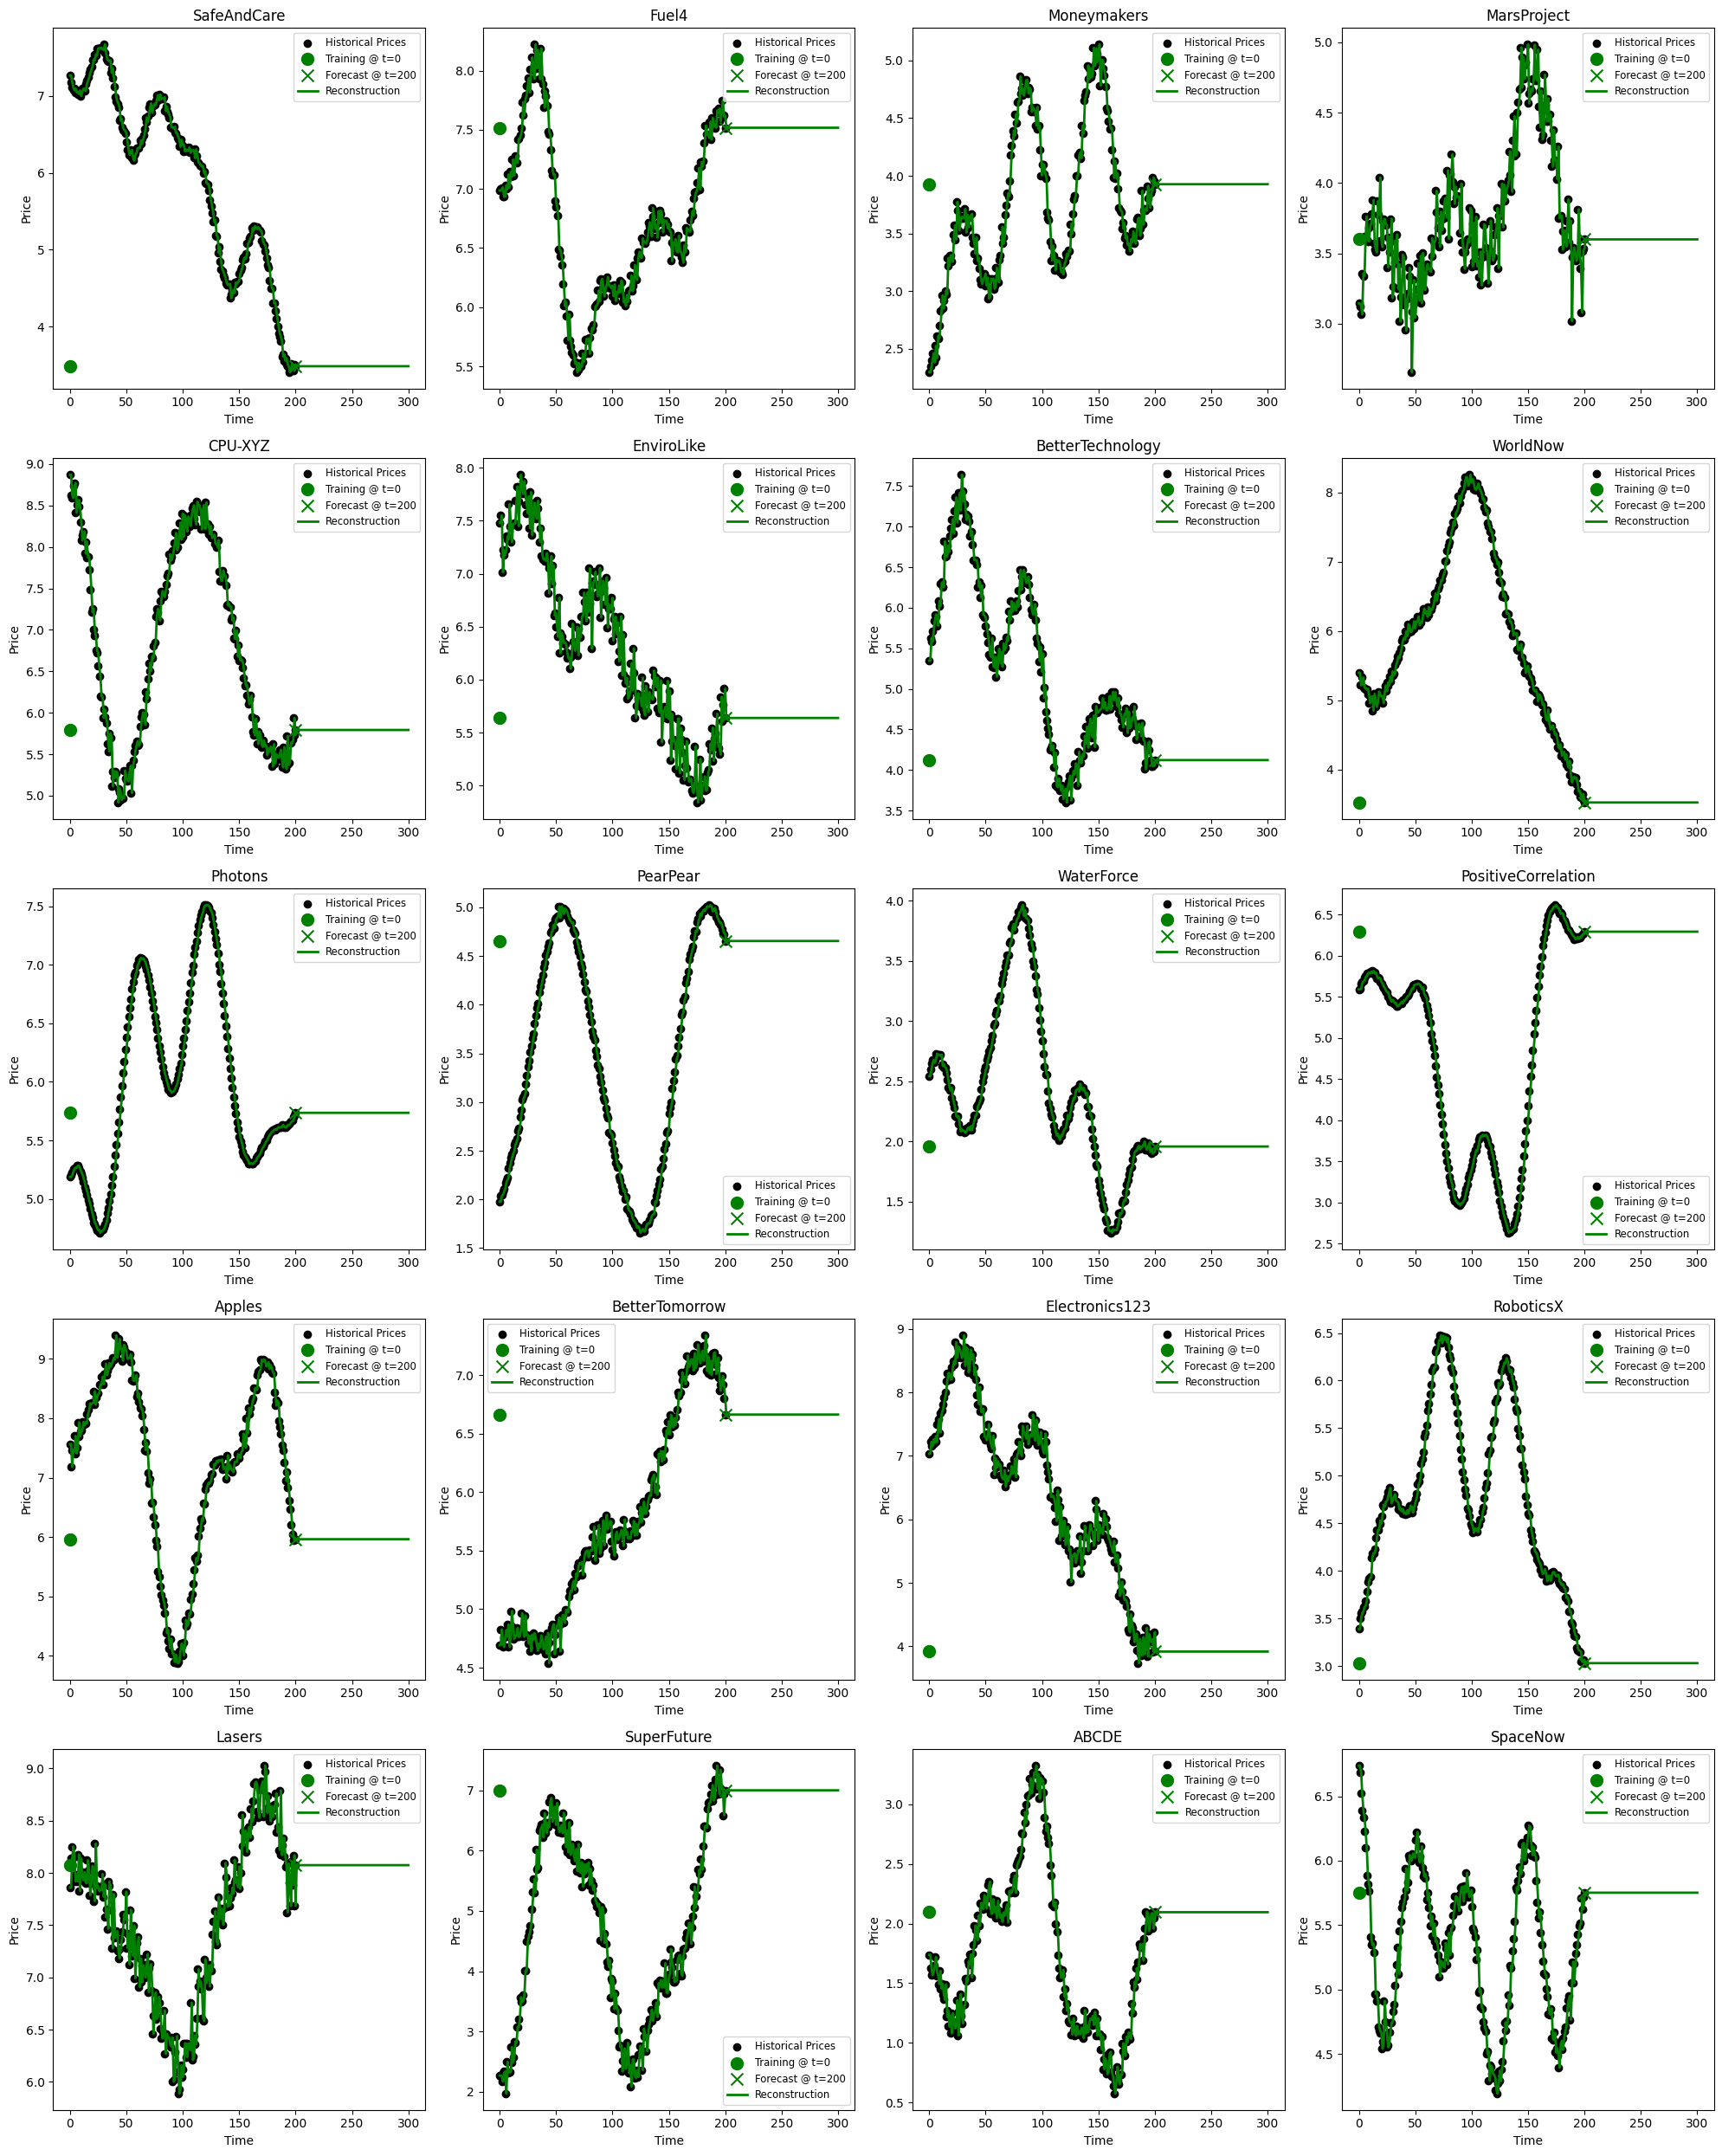

In [34]:
import numpy as np
import pandas as pd
from sktime.forecasting.naive import NaiveForecaster

def naive_forecast(asset_names, asset_times, asset_prices,
                   training_start=0, training_end=100, forecast_time=200, strategy="last"):
    """
    Returns:
      A dictionary where for each asset the following keys are returned:
        - "model_predictions": (training_times, in-sample naive predictions) on [training_start, training_end]
        - "full_reconstruction": (recon_times, naive forecast predictions) on [training_start, forecast_time]
        - "price_at_training": reference price at training_end (from actual training data)
        - "price_at_forecast": forecasted price at forecast_time
        - "predicted_return": computed return as (price_at_forecast - price_at_training) / price_at_training
    """
    naive_pred = {}
    for i, name in enumerate(asset_names):
        times = np.array(asset_times[i])
        prices = np.array(asset_prices[i])
        
        # Select training data: times between training_start and training_end.
        mask = (times >= training_start) & (times <= training_end)
        t_train = times[mask]
        p_train = prices[mask]
        
        # Compute in-sample naive predictions.
        if strategy == "last":
            in_sample_predictions = np.empty_like(p_train)
            in_sample_predictions[0] = p_train[0]
            if len(p_train) > 1:
                in_sample_predictions[1:] = p_train[:-1]
        elif strategy == "drift":
            if len(p_train) > 1:
                drift = (p_train[-1] - p_train[0]) / (len(p_train) - 1)
            else:
                drift = 0
            in_sample_predictions = np.empty_like(p_train)
            in_sample_predictions[0] = p_train[0]
            for j in range(1, len(p_train)):
                in_sample_predictions[j] = p_train[j-1] + drift
        elif strategy == "mean":
            mean_value = np.mean(p_train)
            in_sample_predictions = np.full_like(p_train, fill_value=mean_value)
        else:
            raise ValueError("Unsupported strategy. Use 'last', 'drift', or 'mean'.")
        
        # Clip negative in-sample predictions.
        in_sample_predictions = np.maximum(in_sample_predictions, 0)
        
        # Determine the number of forecast steps.
        forecast_steps = int(forecast_time - training_end)
        if forecast_steps <= 0:
            raise ValueError("forecast_time must be greater than training_end")
        
        # Prepare the training series for sktime.
        # Assuming training times are consecutive integers.
        y_train = pd.Series(p_train, index=pd.RangeIndex(start=int(t_train[0]),
                                                         stop=int(t_train[0]) + len(t_train)))
        
        # Fit the NaiveForecaster from sktime.
        forecaster = NaiveForecaster(strategy=strategy)
        forecaster.fit(y_train)
        fh = np.arange(1, forecast_steps + 1)  # forecasting horizon (steps ahead)
        y_forecast = forecaster.predict(fh)
        
        # Clip forecast predictions to ensure non-negativity.
        forecast_values = np.maximum(y_forecast.values, 0)
        
        # Create forecast time points (assuming integer time steps).
        forecast_times = np.arange(training_end + 1, forecast_time + 1)
        
        # Full reconstruction: combine in-sample predictions and forecast values.
        full_times = np.concatenate([t_train, forecast_times])
        full_predictions = np.concatenate([in_sample_predictions, forecast_values])
        
        # Determine prices at training_end and forecast_time.
        price_at_training = p_train[-1]  # using actual last training price as reference
        price_at_forecast = forecast_values[-1]
        predicted_return = (price_at_forecast - price_at_training) / price_at_training
        
        naive_pred[name] = {
            "model_predictions": (t_train, in_sample_predictions),
            "full_reconstruction": (full_times, full_predictions),
            "price_at_training": price_at_training,
            "price_at_forecast": price_at_forecast,
            "predicted_return": predicted_return
        }
    return naive_pred

# Example usage:
naive_results = naive_forecast(asset_names, asset_times, asset_prices,
                               training_start=0, training_end=200, forecast_time=300, strategy="last")
plot_asset_forecasts(asset_names, asset_times, asset_prices, naive_results, training_offset=200, color="green")


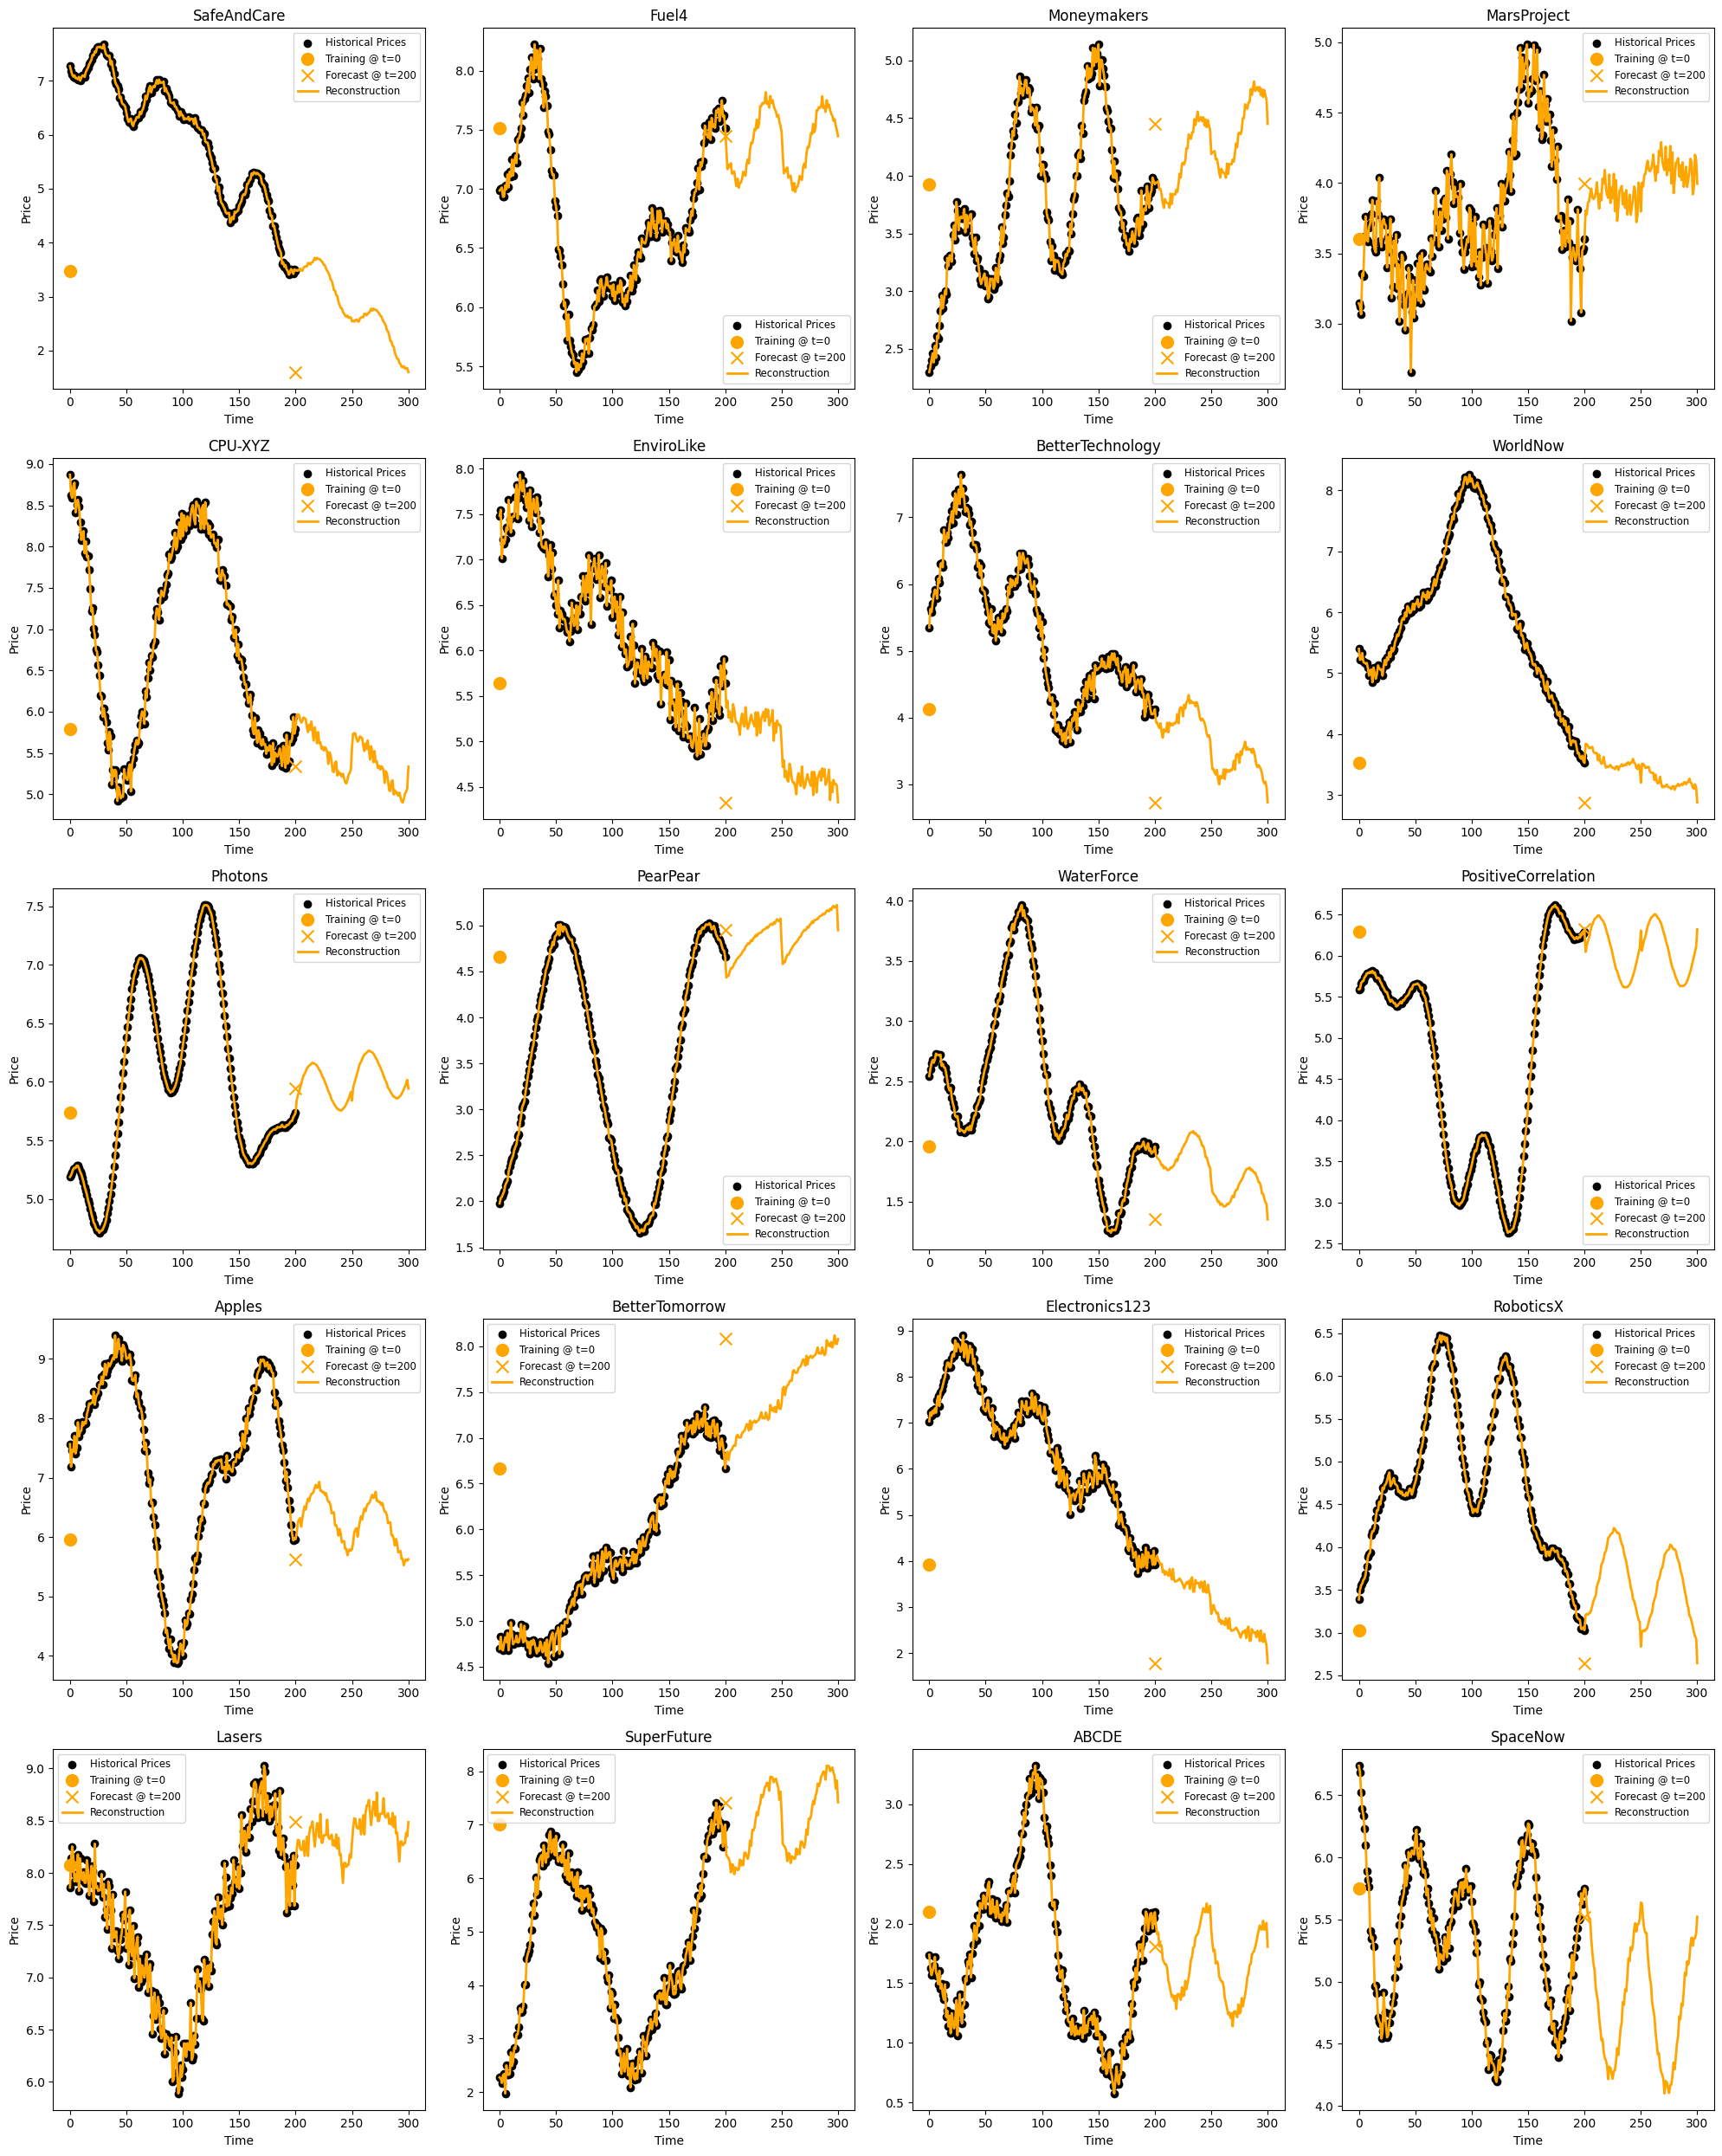

In [35]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor

def decision_tree_forecast(asset_names, asset_times, asset_prices,
                           training_start=0, training_end=100, forecast_time=200,
                           seasonal_period=None, max_depth=None):
    """
    For each asset, forecast prices using a Decision Tree Regressor with conditional deseasonalization and detrending.
    
    Steps for each asset:
      1. Extract training data from training_start to training_end.
      2. Fit a linear trend (using np.polyfit) to the training data.
      3. Detrend the training data by subtracting the trend.
      4. If seasonal_period is provided and > 1, compute a seasonal component (average residual per seasonal position)
         and remove it (deseasonalize the data).
      5. Fit a Decision Tree Regressor on the deseasonalized residuals.
      6. For forecasting, predict the residuals on new time points, add back the trend (evaluated using the linear model)
         and the seasonal component (if available) to obtain the final forecast.
    """
    dt_pred = {}
    for i, name in enumerate(asset_names):
        times = np.array(asset_times[i])
        prices = np.array(asset_prices[i])
        
        # 1. Select training data
        mask = (times >= training_start) & (times <= training_end)
        t_train = times[mask]
        p_train = prices[mask]
        
        # 2. Fit a linear trend for detrending (using a first-degree polynomial)
        coeffs = np.polyfit(t_train, p_train, deg=1)
        trend_train = np.polyval(coeffs, t_train)
        
        # 3. Detrend the training data
        p_detrended = p_train - trend_train
        
        # 4. Conditional deseasonalization if a seasonal period is provided
        if seasonal_period is not None and seasonal_period > 1:
            # Compute the average seasonal effect for each season position
            seasonal_effect = np.zeros(seasonal_period)
            count = np.zeros(seasonal_period)
            for idx, t in enumerate(t_train):
                pos = int((t - training_start) % seasonal_period)
                seasonal_effect[pos] += p_detrended[idx]
                count[pos] += 1
            # Avoid division by zero and compute average
            seasonal_effect = np.where(count > 0, seasonal_effect / count, 0)
            # Build the seasonal component for each training time
            seasonal_train = np.array([seasonal_effect[int((t - training_start) % seasonal_period)]
                                       for t in t_train])
            # Remove seasonal effect from the detrended data
            p_deseasonalized = p_detrended - seasonal_train
        else:
            p_deseasonalized = p_detrended
            seasonal_train = np.zeros_like(p_train)  # no seasonal component
        
        # 5. Fit Decision Tree Regressor on the deseasonalized (residual) training data.
        dt_reg = DecisionTreeRegressor(max_depth=max_depth)
        dt_reg.fit(t_train.reshape(-1, 1), p_deseasonalized)
        
        # In-sample prediction on training data (residual prediction)
        pred_deseasonalized_train = dt_reg.predict(t_train.reshape(-1, 1))
        # Reconstruct training predictions by adding back the trend and seasonal component (if any)
        pred_train_reconstructed = pred_deseasonalized_train + trend_train
        if seasonal_period is not None and seasonal_period > 1:
            pred_train_reconstructed += seasonal_train
        
        # 6. Forecasting for times after training_end
        forecast_times = np.arange(training_end + 1, forecast_time + 1)
        # Predict the residuals for forecast times
        pred_deseasonalized_forecast = dt_reg.predict(forecast_times.reshape(-1, 1))
        # Evaluate trend for forecast times
        trend_forecast = np.polyval(coeffs, forecast_times)
        # If seasonal, compute seasonal component for forecast times
        if seasonal_period is not None and seasonal_period > 1:
            seasonal_forecast = np.array([seasonal_effect[int((t - training_start) % seasonal_period)]
                                          for t in forecast_times])
        else:
            seasonal_forecast = np.zeros_like(forecast_times)
        # Reconstruct forecasted predictions
        forecast_pred = pred_deseasonalized_forecast + trend_forecast + seasonal_forecast
        
        # 7. Build full reconstruction of predictions (training + forecast)
        full_times = np.concatenate([t_train, forecast_times])
        full_predictions = np.concatenate([pred_train_reconstructed, forecast_pred])
        
        # Determine price at training_end (last training prediction) and at forecast_time (last forecast value)
        price_at_training = pred_train_reconstructed[-1]
        price_at_forecast = forecast_pred[-1]
        predicted_return = (price_at_forecast - price_at_training) / price_at_training
        
        dt_pred[name] = {
            "model_predictions": (t_train, pred_train_reconstructed),
            "full_reconstruction": (full_times, full_predictions),
            "price_at_training": price_at_training,
            "price_at_forecast": price_at_forecast,
            "predicted_return": predicted_return
        }
        
    return dt_pred

# Example usage:
dt_results = decision_tree_forecast(asset_names, asset_times, asset_prices,
                                    training_start=0, training_end=200, forecast_time=300,
                                    seasonal_period=50, max_depth=50)
plot_asset_forecasts(asset_names, asset_times, asset_prices, dt_results, training_offset=200, color="orange")


/Users/dromaniv/multiple-objective-optimization/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


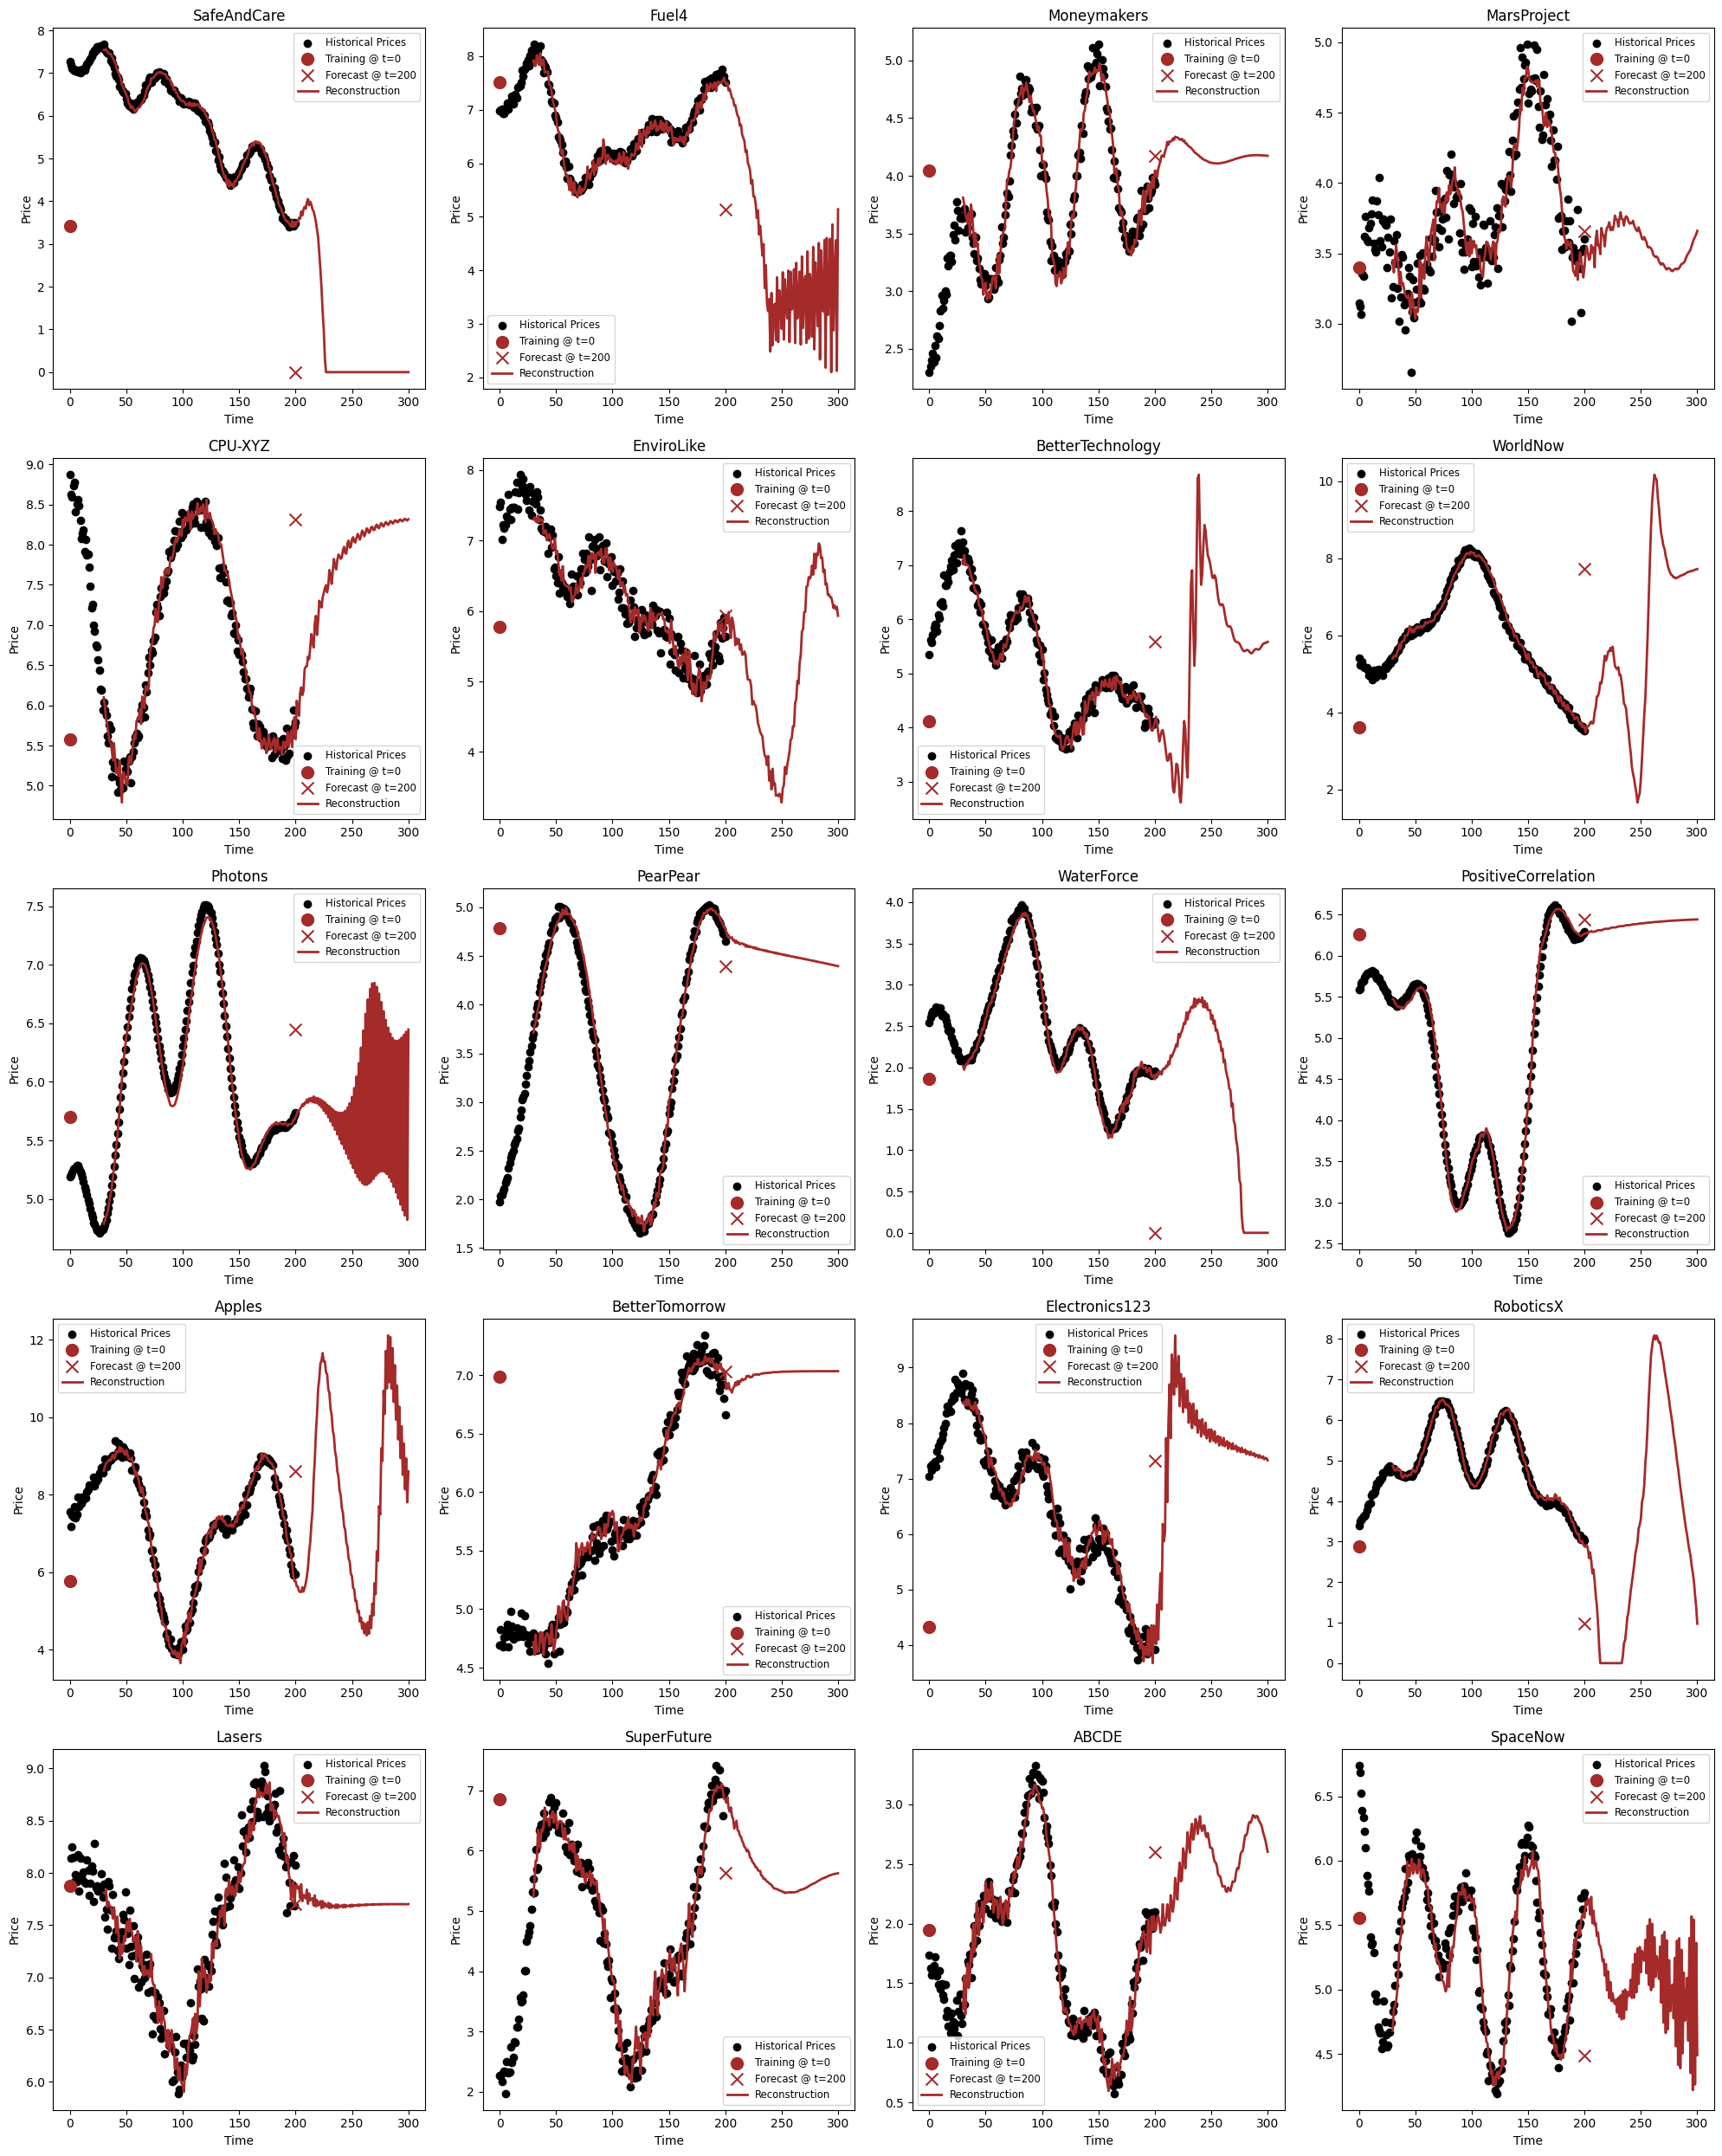

In [36]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

def create_dataset(data, look_back):
    """
    Create sliding-window sequences for training.
    
    Args:
      data: 1D numpy array of normalized asset prices.
      look_back: number of time steps to use as input.
      
    Returns:
      X: numpy array of shape (n_samples, look_back)
      y: numpy array of shape (n_samples,)
    """
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back])
    return np.array(X), np.array(y)

def rnn_forecast(asset_names, asset_times, asset_prices,
                 training_start=0, training_end=100, forecast_time=200,
                 look_back=10, epochs=20, batch_size=64):
    """
    For each asset, this function:
      1. Selects training data in [training_start, training_end].
      2. Computes the min and max of the training data and normalizes it.
      3. Creates sliding-window sequences and trains an RNN model on the normalized data.
      4. Makes in-sample predictions and recursively forecasts until forecast_time (all in normalized space).
      5. Transforms the predictions back to the original scale using the stored min and max.
      6. Clipping: Any negative values in the predictions (both in-sample and forecast) are set to 0.
    """
    rnn_pred = {}
    
    for i, name in enumerate(asset_names):
        times = np.array(asset_times[i])
        prices = np.array(asset_prices[i])
        
        # Select training data using the provided time window.
        mask = (times >= training_start) & (times <= training_end)
        t_train = times[mask]
        p_train = prices[mask]
        
        if len(p_train) <= look_back:
            raise ValueError(f"Not enough training data for asset {name} with look_back = {look_back}.")
        
        # Get the min and max from the training data (original scale).
        train_min = p_train.min()
        train_max = p_train.max()
        
        # Normalize the training data.
        p_train_norm = (p_train - train_min) / (train_max - train_min)
        
        # Create sliding-window sequences on the normalized data.
        X_train, y_train = create_dataset(p_train_norm, look_back)
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        
        # Build the RNN model using the specified architecture.
        model = Sequential()
        model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
        model.add(SimpleRNN(units=50, return_sequences=False))
        model.add(Dense(units=1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        
        # Train the RNN model on normalized data (verbose=0 to suppress output)
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        
        # In-sample predictions on the normalized training data.
        pred_train_norm = model.predict(X_train, verbose=0).flatten()
        # Inverse transform the normalized predictions to the original scale.
        pred_train = pred_train_norm * (train_max - train_min) + train_min
        # Clip any negative predictions to 0.
        pred_train = np.maximum(pred_train, 0)
        # The in-sample predictions correspond to times t_train[look_back:].
        t_train_pred = t_train[look_back:]
        
        # Determine forecast steps (assumes integer time steps).
        forecast_steps = int(forecast_time - training_end)
        if forecast_steps <= 0:
            raise ValueError("forecast_time must be greater than training_end")
        
        # Recursive forecasting: use the last look_back normalized values to predict the next value.
        last_sequence = p_train_norm[-look_back:].tolist()
        forecasted_norm = []
        for _ in range(forecast_steps):
            input_seq = np.array(last_sequence[-look_back:]).reshape((1, look_back, 1))
            next_val_norm = model.predict(input_seq, verbose=0)[0, 0]
            forecasted_norm.append(next_val_norm)
            last_sequence.append(next_val_norm)
        
        # Inverse-transform the forecasted normalized predictions.
        forecasted = np.array(forecasted_norm) * (train_max - train_min) + train_min
        # Clip negative forecast values.
        forecasted = np.maximum(forecasted, 0)
        
        # Construct full reconstruction: combine in-sample predictions and forecasted values.
        forecast_times = np.arange(training_end + 1, forecast_time + 1)
        full_times = np.concatenate([t_train_pred, forecast_times])
        full_predictions = np.concatenate([pred_train, forecasted])
        full_predictions = np.maximum(full_predictions, 0)
        
        price_at_training = pred_train[-1]
        price_at_forecast = forecasted[-1]
        predicted_return = (price_at_forecast - price_at_training) / price_at_training
        
        rnn_pred[name] = {
            "model_predictions": (t_train_pred, pred_train),
            "full_reconstruction": (full_times, full_predictions),
            "price_at_training": price_at_training,
            "price_at_forecast": price_at_forecast,
            "predicted_return": predicted_return
        }
    
    return rnn_pred

# (Assuming asset_names, asset_times, asset_prices, and plot_asset_forecasts are defined)
rnn_results = rnn_forecast(asset_names, asset_times, asset_prices,
                           training_start=0, training_end=200, forecast_time=300,
                           look_back=30, epochs=20, batch_size=64)
plot_asset_forecasts(asset_names, asset_times, asset_prices, rnn_results, training_offset=200, color="brown")


Asset: SafeAndCare
Real training price (last value in training data): 3.4820
Method           TrainPred   Forecast   Return (%)
--------------------------------------------------
RNN                 3.4210     0.0000         0.00
DecisionTree        3.4820     1.6012        45.98
Naive               3.4820     3.4820       100.00
ExpSmoothing        3.4893     4.6733       133.93
ARIMA               3.4900     2.4330        69.71
Sparse              3.3774     0.0000         0.00
Linear              4.0464     2.1656        53.52
--------------------------------------------------
Median              3.4820     2.1656        53.52
Mean                3.5412     2.0507        57.59

Asset: Fuel4
Real training price (last value in training data): 7.5170
Method           TrainPred   Forecast   Return (%)
--------------------------------------------------
RNN                 7.5096     5.1382        68.42
DecisionTree        7.5170     7.4455        99.05
Naive               7.5170     7.5

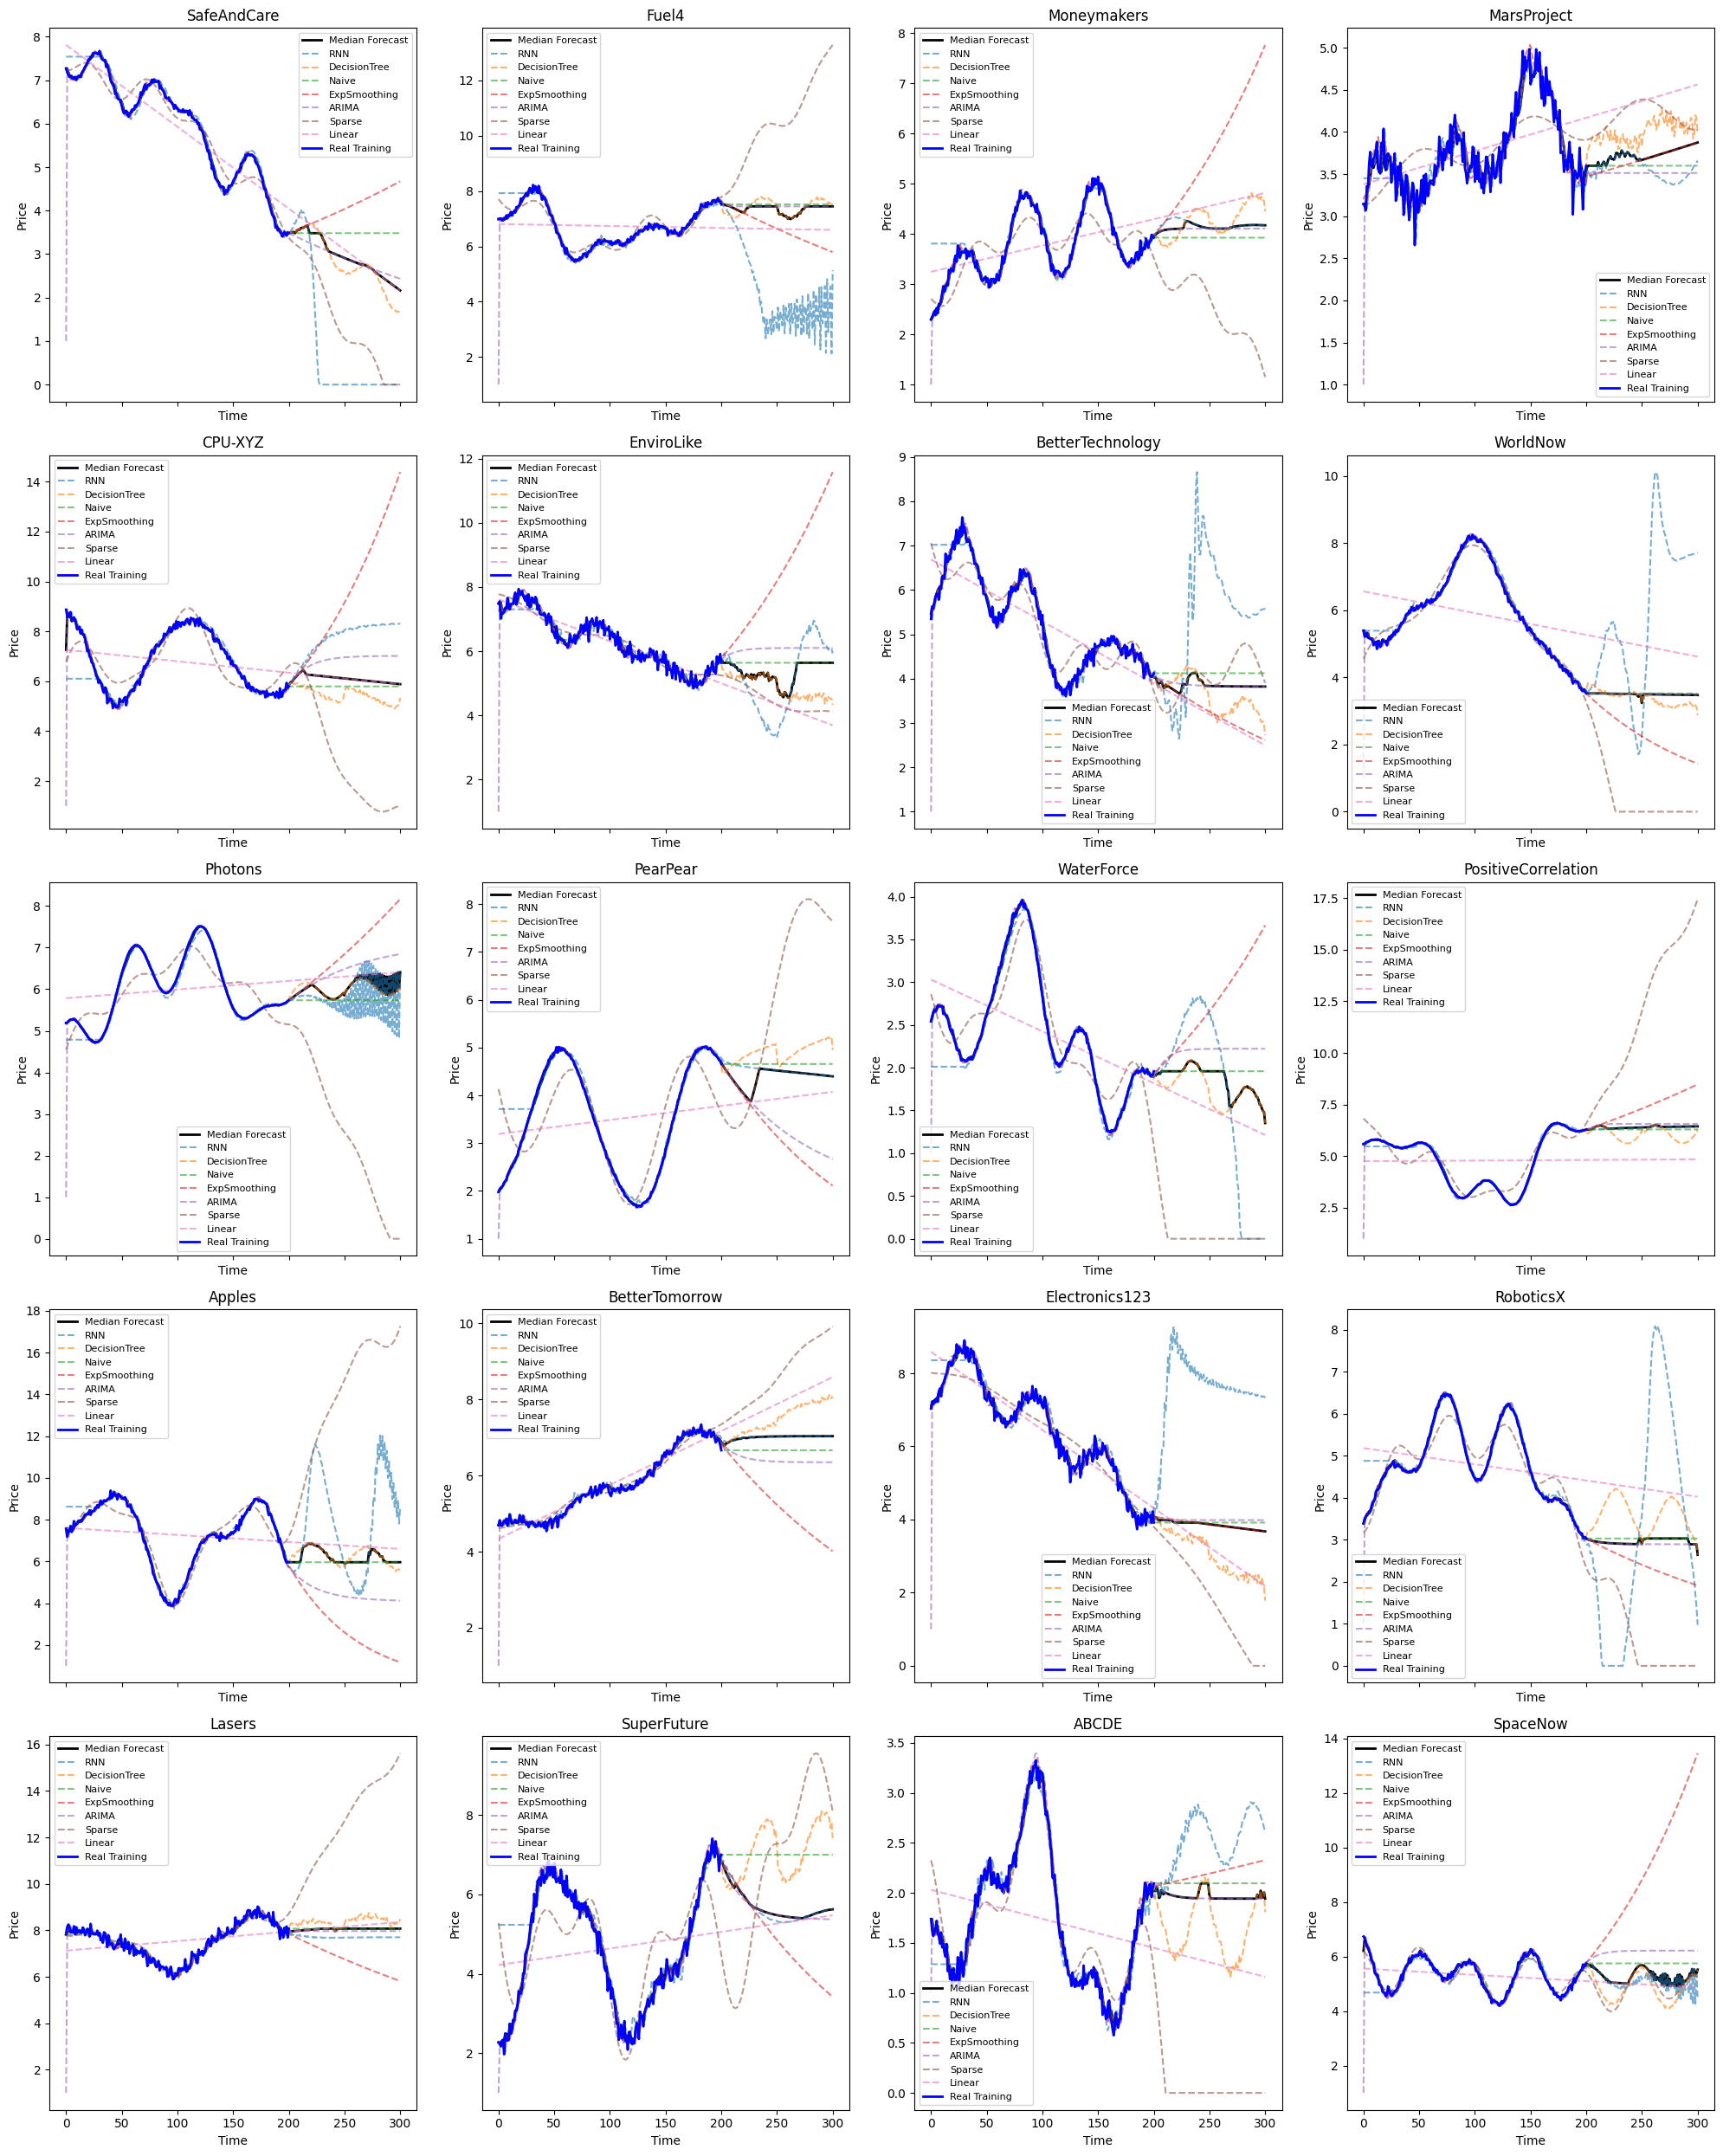

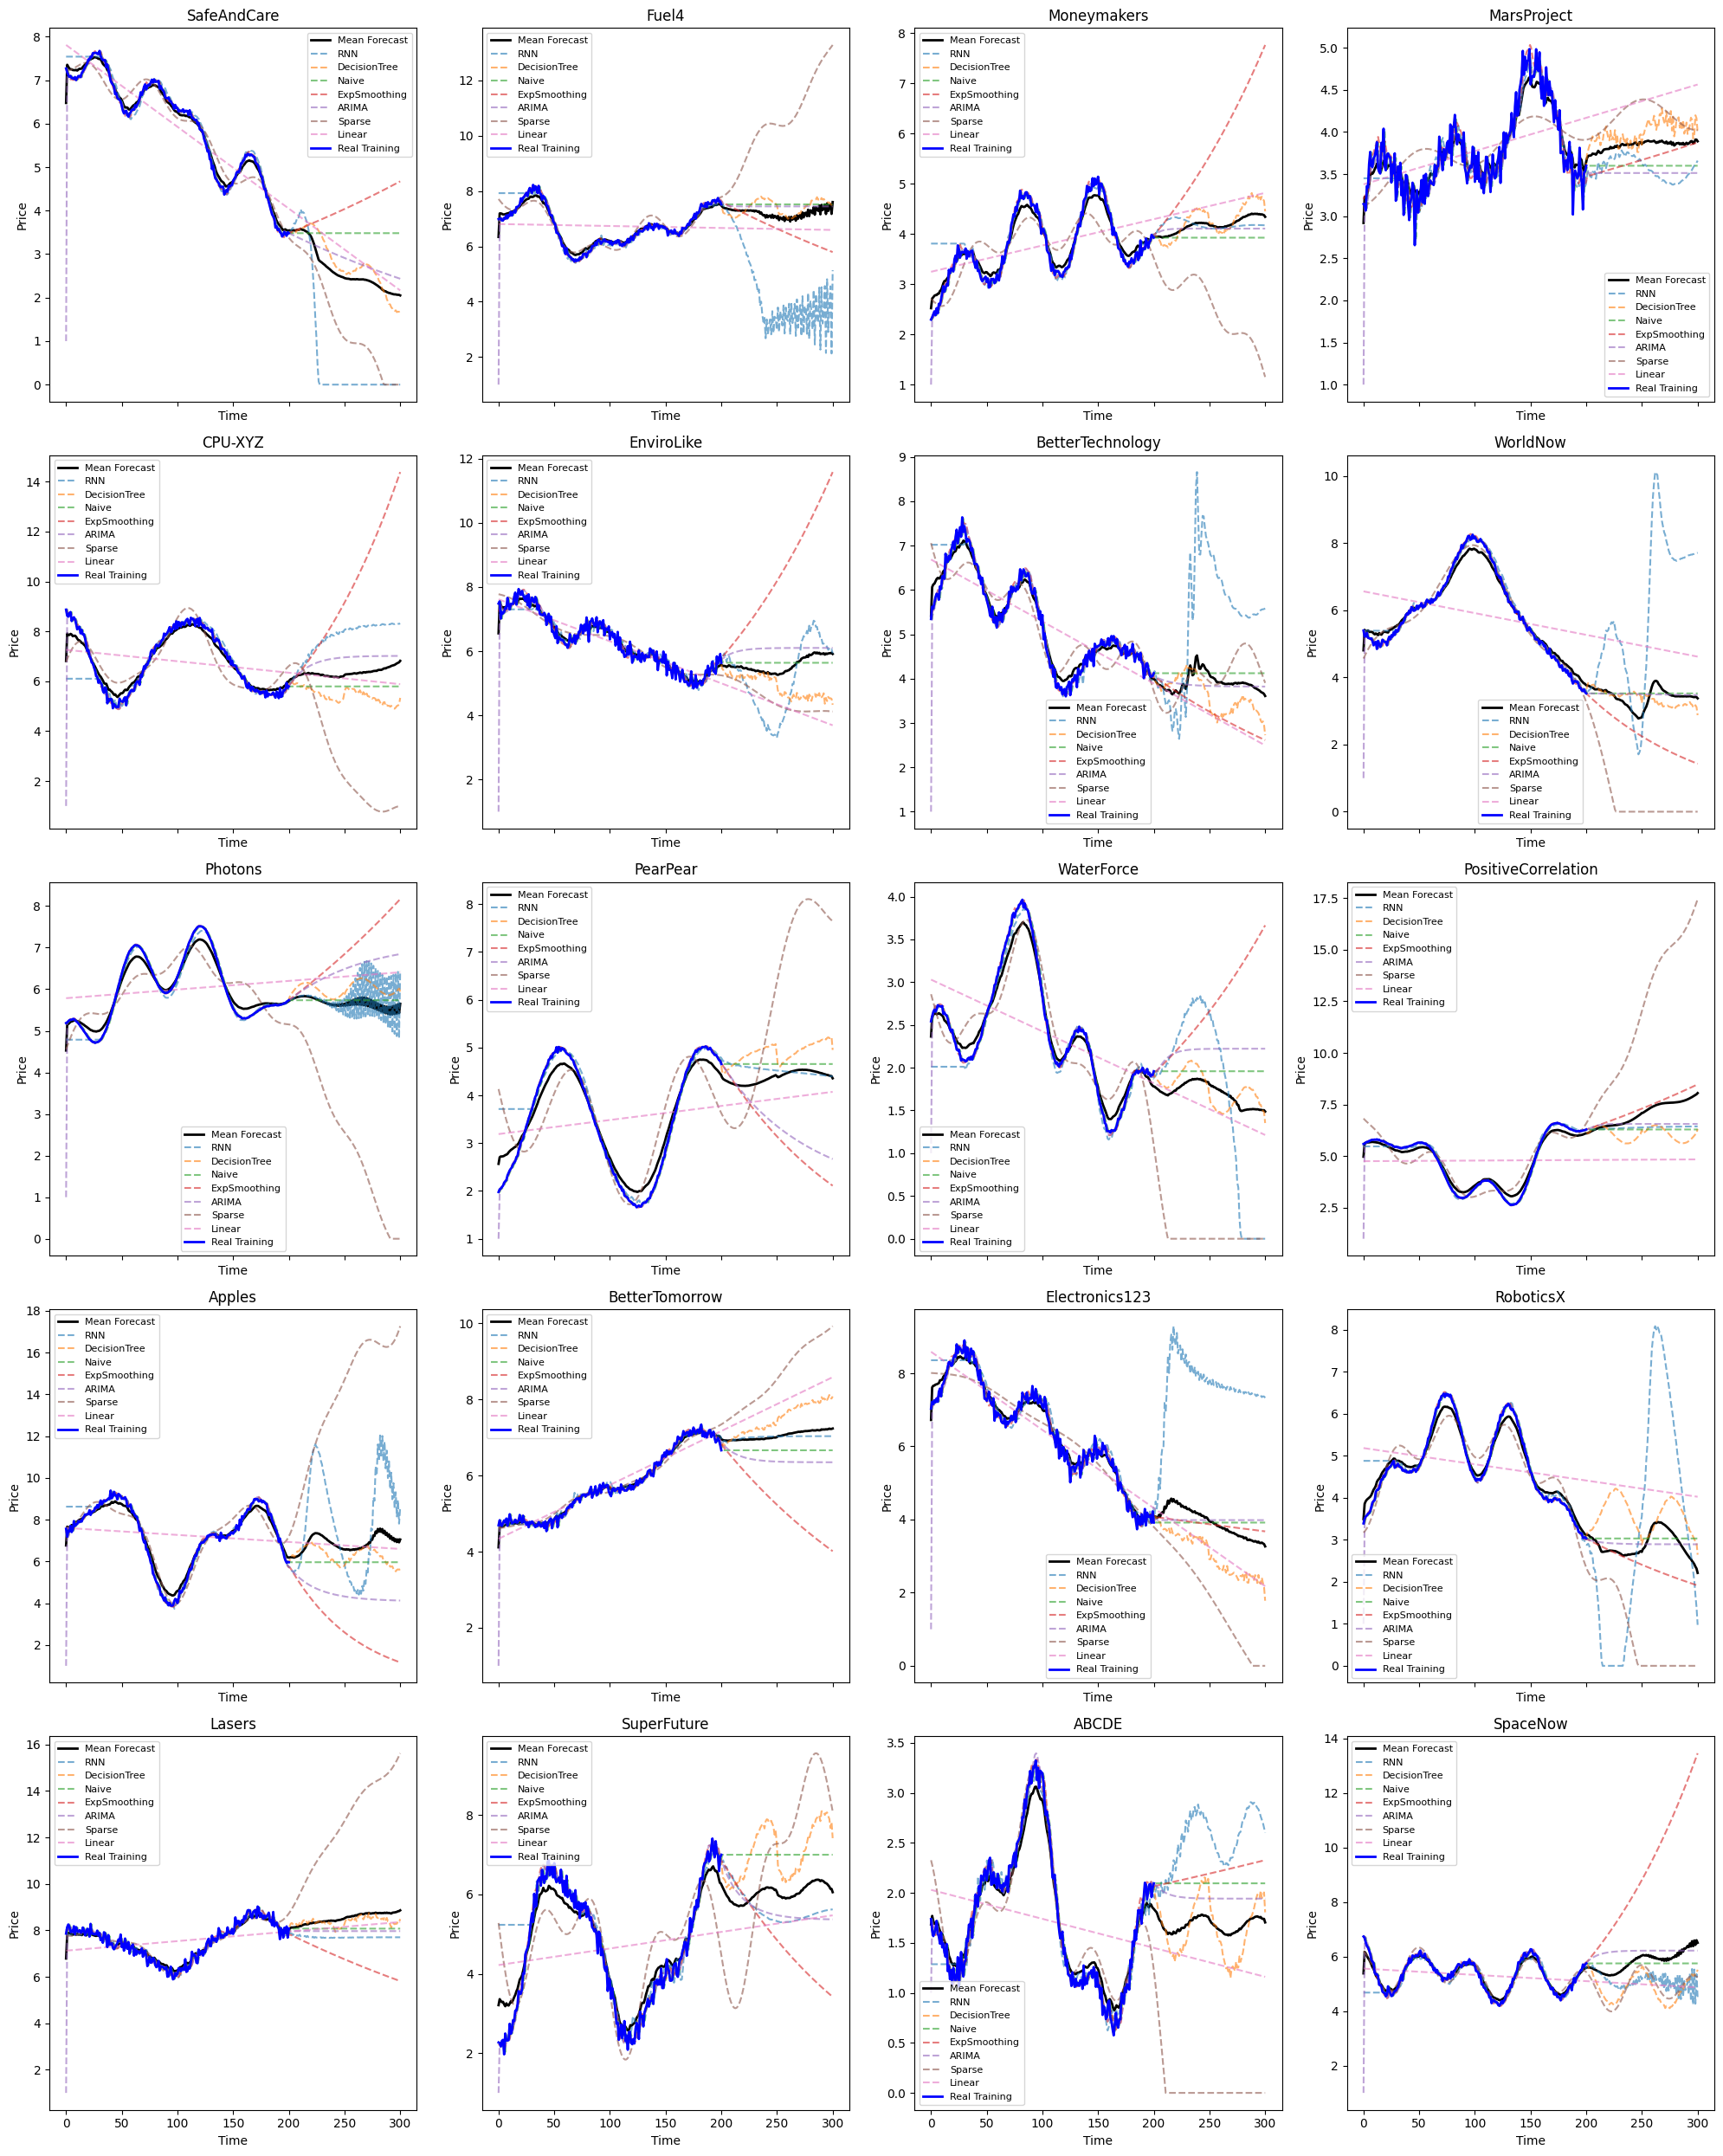

In [37]:
import numpy as np
import matplotlib.pyplot as plt

def aggregate_and_plot_mean_median(asset_names, asset_times, asset_prices,
                                   rnn_results, dt_results, naive_results, exp_results,
                                   arima_results, sparse_results, linear_results,
                                   training_start=0, training_end=100, forecast_time=200):
    """
    For each asset, this function:
      - Prints a table of predicted training price, forecast price, and expected return (in %)
        for each forecasting method.
      - Computes the pointwise median and mean forecasts across methods.
      - Displays two separate 5×4 grids: one for the median forecast and one for the mean forecast.
    
    Expected return is computed as (forecast / training_price)*100%.
    
    Returns a dictionary with two keys: "median" and "mean". Each value is a dictionary where each asset
    is represented with keys:
      - "model_predictions": (training_times, aggregated in-sample predictions) – here we fill the training period with the aggregated training price.
      - "full_reconstruction": (common_times, aggregated full forecast)
      - "price_at_training": aggregated training price (scalar)
      - "price_at_forecast": aggregated forecast price (scalar)
      - "predicted_return": aggregated expected return (scalar)
    """
    # Combine forecast dictionaries.
    methods = {
        'RNN': rnn_results,
        'DecisionTree': dt_results,
        'Naive': naive_results,
        'ExpSmoothing': exp_results,
        'ARIMA': arima_results,
        'Sparse': sparse_results,
        'Linear': linear_results
    }
    
    # Create a common time axis.
    common_times = np.linspace(training_start, forecast_time, forecast_time - training_start)
    
    # Containers for aggregated results.
    median_results = {}
    mean_results = {}
    
    # Loop over assets.
    for idx, asset in enumerate(asset_names):
        print(f"\n{'='*60}\nAsset: {asset}")
        
        # Get asset training data.
        times = np.array(asset_times[idx])
        prices = np.array(asset_prices[idx])
        mask = (times >= training_start) & (times <= training_end)
        t_train = times[mask]
        real_training_price = prices[mask][-1]
        print(f"Real training price (last value in training data): {real_training_price:.4f}")
        
        # Initialize lists to collect scalar predictions and aligned full forecasts.
        training_preds = []    # from each method: price_at_training
        forecast_preds = []    # from each method: price_at_forecast
        exp_returns = []       # expected return in percentage
        full_predictions_aligned = []  # each element is an array aligned on common_times
        
        # Print table header.
        header = f"{'Method':<15} {'TrainPred':>10} {'Forecast':>10} {'Return (%)':>12}"
        print(header)
        print("-" * len(header))
        
        for method_name, result in methods.items():
            if asset not in result:
                continue
            res = result[asset]
            train_pred = res["price_at_training"]
            forecast_pred = res["price_at_forecast"]
            # Expected return = (forecast / train_pred)*100%
            exp_return = (forecast_pred / train_pred) * 100.0
            print(f"{method_name:<15} {train_pred:10.4f} {forecast_pred:10.4f} {exp_return:12.2f}")
            training_preds.append(train_pred)
            forecast_preds.append(forecast_pred)
            exp_returns.append(exp_return)
            # Interpolate full reconstruction on common_times.
            method_times, method_preds = res["full_reconstruction"]
            aligned = np.interp(common_times, method_times, method_preds)
            full_predictions_aligned.append(aligned)
        
        # Compute aggregated scalar values.
        median_train = np.median(training_preds)
        median_forecast = np.median(forecast_preds)
        median_return = np.median(exp_returns)
        mean_train = np.mean(training_preds)
        mean_forecast = np.mean(forecast_preds)
        mean_return = np.mean(exp_returns)
        print("-" * len(header))
        print(f"{'Median':<15} {median_train:10.4f} {median_forecast:10.4f} {median_return:12.2f}")
        print(f"{'Mean':<15} {mean_train:10.4f} {mean_forecast:10.4f} {mean_return:12.2f}")
        
        # Compute pointwise aggregated forecasts.
        full_predictions_aligned = np.array(full_predictions_aligned)
        median_full = np.median(full_predictions_aligned, axis=0)
        mean_full = np.mean(full_predictions_aligned, axis=0)
        
        # Save aggregated results for this asset.
        # For in-sample predictions, we simply fill the training period with the aggregated training price.
        median_results[asset] = {
            "model_predictions": (t_train, np.full_like(t_train, median_train)),
            "full_reconstruction": (common_times, median_full),
            "price_at_training": median_train,
            "price_at_forecast": median_forecast,
            "predicted_return": median_return
        }
        mean_results[asset] = {
            "model_predictions": (t_train, np.full_like(t_train, mean_train)),
            "full_reconstruction": (common_times, mean_full),
            "price_at_training": mean_train,
            "price_at_forecast": mean_forecast,
            "predicted_return": mean_return
        }
    
    # Plotting: Two separate 5x4 charts.
    n_assets = len(asset_names)
    n_rows, n_cols = 5, 4
    
    # Figure for Median forecasts.
    fig_med, axes_med = plt.subplots(n_rows, n_cols, figsize=(20, 25), sharex=True, sharey=False)
    axes_med = axes_med.flatten()
    for idx, asset in enumerate(asset_names):
        ax = axes_med[idx]
        # Plot aggregated median forecast.
        ax.plot(common_times, median_results[asset]["full_reconstruction"][1], label="Median Forecast", color='black', linewidth=2)
        # Plot each method's forecast.
        for method_name, result in methods.items():
            if asset in result:
                m_times, m_preds = result[asset]["full_reconstruction"]
                aligned = np.interp(common_times, m_times, m_preds)
                ax.plot(common_times, aligned, label=method_name, linestyle="--", alpha=0.6)
        # Plot real training data.
        mask = (np.array(asset_times[asset_names.index(asset)]) >= training_start) & (np.array(asset_times[asset_names.index(asset)]) <= training_end)
        t_train = np.array(asset_times[asset_names.index(asset)])[mask]
        ax.plot(t_train, np.array(asset_prices[asset_names.index(asset)])[mask], label="Real Training", color="blue", linewidth=2)
        ax.set_title(asset)
        ax.set_xlabel("Time")
        ax.set_ylabel("Price")
        ax.legend(fontsize=8)
    # Hide any unused subplots.
    for j in range(idx+1, n_rows*n_cols):
        axes_med[j].axis('off')
    fig_med.tight_layout()
    
    # Figure for Mean forecasts.
    fig_mean, axes_mean = plt.subplots(n_rows, n_cols, figsize=(20, 25), sharex=True, sharey=False)
    axes_mean = axes_mean.flatten()
    for idx, asset in enumerate(asset_names):
        ax = axes_mean[idx]
        # Plot aggregated mean forecast.
        ax.plot(common_times, mean_results[asset]["full_reconstruction"][1], label="Mean Forecast", color='black', linewidth=2)
        # Plot each method's forecast.
        for method_name, result in methods.items():
            if asset in result:
                m_times, m_preds = result[asset]["full_reconstruction"]
                aligned = np.interp(common_times, m_times, m_preds)
                ax.plot(common_times, aligned, label=method_name, linestyle="--", alpha=0.6)
        # Plot real training data.
        mask = (np.array(asset_times[asset_names.index(asset)]) >= training_start) & (np.array(asset_times[asset_names.index(asset)]) <= training_end)
        t_train = np.array(asset_times[asset_names.index(asset)])[mask]
        ax.plot(t_train, np.array(asset_prices[asset_names.index(asset)])[mask], label="Real Training", color="blue", linewidth=2)
        ax.set_title(asset)
        ax.set_xlabel("Time")
        ax.set_ylabel("Price")
        ax.legend(fontsize=8)
    for j in range(idx+1, n_rows*n_cols):
        axes_mean[j].axis('off')
    fig_mean.tight_layout()
    
    plt.show()
    
    # Return the aggregated results.
    return {"median": median_results, "mean": mean_results}

results = aggregate_and_plot_mean_median(asset_names, asset_times, asset_prices,
                                         rnn_results, dt_results, naive_results, exp_results,
                                         arima_results, sparse_results, linear_results,
                                         training_start=0, training_end=200, forecast_time=300)

### Markowitz Model using **mean** results

In [38]:
# Extract expected returns from mean results
expected_returns = np.array([results["mean"][asset]["predicted_return"] / 100.0 - 1 for asset in asset_names])
n_assets = len(asset_names)

# Compute covariance matrix using historical data
historical_returns = []
for i, asset in enumerate(asset_names):
    # Get prices during training period
    prices = np.array(asset_prices[i])
    times = np.array(asset_times[i])
    mask = (times >= 0) & (times <= 100)
    asset_prices_train = prices[mask]
    
    # Calculate returns
    asset_returns = np.diff(asset_prices_train) / asset_prices_train[:-1]
    historical_returns.append(asset_returns)

# Ensure all historical returns have the same length
min_length = min(len(returns) for returns in historical_returns)
historical_returns = [returns[:min_length] for returns in historical_returns]
historical_returns = np.array(historical_returns)

# Compute covariance matrix
cov_matrix = np.cov(historical_returns)

# Ensure covariance matrix is positive semi-definite
eigenvalues = np.linalg.eigvalsh(cov_matrix)
if np.any(eigenvalues < 0):
    cov_matrix += np.eye(n_assets) * 1e-8

print("Expected Returns (sample):")
for i in range(min(5, n_assets)):
    print(f"{asset_names[i]}: {expected_returns[i]:.4f}")

print("\nCovariance Matrix (sample):")
print(cov_matrix[:3, :3])

# Find minimum risk portfolio
def solve_min_risk():
    """Find the portfolio with minimum risk"""
    P = matrix(cov_matrix)
    q = matrix(np.zeros(n_assets))
    
    # Constraint: w ≥ 0
    G = matrix(-np.eye(n_assets))
    h = matrix(np.zeros(n_assets))
    
    # Constraint: sum(w) = 1
    A = matrix(np.ones((1, n_assets)))
    b = matrix(np.ones(1))
    
    sol = solvers.qp(P, q, G, h, A, b)
    weights = np.array(sol['x']).flatten()
    port_return = np.dot(weights, expected_returns)
    port_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    return weights, port_risk, port_return

# Find maximum return portfolio
def solve_max_return():
    """Find the portfolio with maximum return"""
    c = matrix(-expected_returns)  # Negative because we minimize -r^T w
    
    # Constraint: w ≥ 0
    G = matrix(-np.eye(n_assets))
    h = matrix(np.zeros(n_assets))
    
    # Constraint: sum(w) = 1
    A = matrix(np.ones((1, n_assets)))
    b = matrix(np.ones(1))
    
    sol = solvers.lp(c, G, h, A, b)
    weights = np.array(sol['x']).flatten()
    port_return = np.dot(weights, expected_returns)
    port_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    return weights, port_return, port_risk

# Find the extreme portfolios
min_risk_weights, min_risk_value, min_risk_return = solve_min_risk()
max_return_weights, max_return_value, max_return_risk = solve_max_return()

print("\nMinimum Risk Portfolio:")
print(f"Risk: {min_risk_value:.6f}")
print(f"Return: {min_risk_return:.6f}")

print("\nMaximum Return Portfolio:")
print(f"Return: {max_return_value:.6f}")
print(f"Risk: {max_return_risk:.6f}")

Expected Returns (sample):
SafeAndCare: -0.4241
Fuel4: 0.0145
Moneymakers: 0.0848
MarsProject: 0.0647
CPU-XYZ: 0.1663

Covariance Matrix (sample):
[[ 1.01854023e-04 -1.71112855e-05  6.69455358e-05]
 [-1.71112855e-05  2.97224717e-04  1.45858732e-04]
 [ 6.69455358e-05  1.45858732e-04  1.24950579e-03]]
     pcost       dcost       gap    pres   dres
 0:  3.0411e-05 -1.0000e+00  1e+00  9e-17  5e+00
 1:  3.0400e-05 -1.0040e-02  1e-02  2e-16  5e-02
 2:  2.9347e-05 -1.3904e-04  2e-04  1e-16  8e-04
 3:  1.5808e-05 -1.9400e-05  4e-05  1e-16  1e-04
 4:  6.5780e-06 -3.3258e-06  1e-05  2e-16  7e-20
 5:  5.2131e-06  3.7689e-06  1e-06  2e-16  3e-20
 6:  4.8912e-06  4.7553e-06  1e-07  7e-17  2e-20
 7:  4.8531e-06  4.8448e-06  8e-09  8e-17  1e-20
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0:  2.2655e-02  2.2655e-02  1e+00  2e-16  6e+00  1e+00
 1: -1.0304e-02 -1.8859e-02  3e-01  1e-16  1e+00  2e-01
 2: -1.6470e-01 -2.0610e-01  3e-01  8e-16  1e+00  2e-01
 3: -2.7265e-

### Implementation of the two multi-objective methods:
- **Weighted Sum Method (WSM)**  
- **Epsilon-Constraint Method (ECM)**  

WSM found 9 unique solutions
ECM found 10 unique solutions


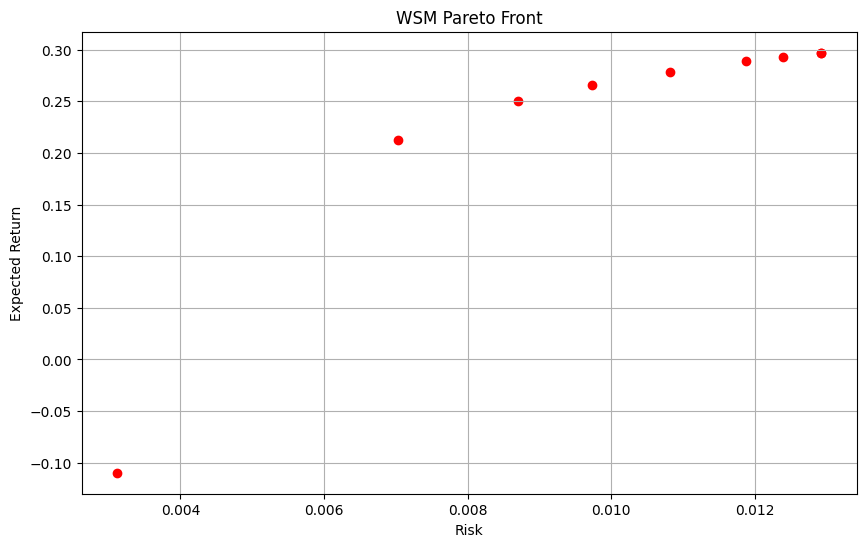

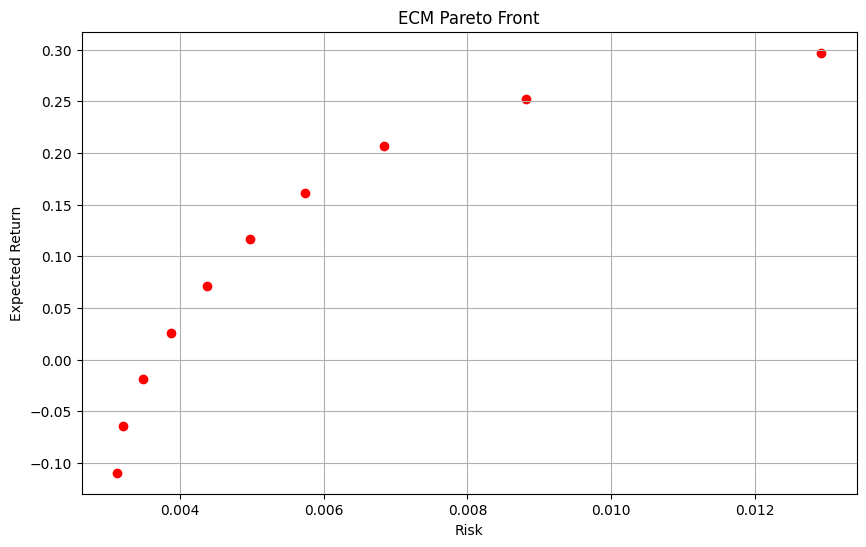

In [50]:
# Suppress solver output
solvers.options['show_progress'] = False

# Weighted Sum Method (WSM)
def weighted_sum_method(n_weights=10, normalize=True):
    # Set up normalization ranges if needed
    if normalize:
        return_range = max_return_value - min_risk_return
        risk_range = max_return_risk - min_risk_value
    
    # Generate weight vectors
    weight_vectors = []
    for i in range(n_weights):
        w_return = i / (n_weights - 1)  # Weight for return
        w_risk = 1 - w_return           # Weight for risk
        weight_vectors.append((w_return, w_risk))
    
    # Solve for each weight vector
    solutions = []
    for w_return, w_risk in weight_vectors:
        # Setup quadratic programming parameters
        P = matrix(cov_matrix)
        q = matrix(np.zeros(n_assets))
        
        if normalize:
            # For normalized objective function
            q_mod = matrix(-w_return * expected_returns / return_range)
            P_mod = matrix(w_risk * cov_matrix / risk_range)
        else:
            # For non-normalized objective function
            q_mod = matrix(-w_return * expected_returns)
            P_mod = matrix(w_risk * cov_matrix)
        
        # Constraint: w ≥ 0
        G = matrix(-np.eye(n_assets))
        h = matrix(np.zeros(n_assets))
        
        # Constraint: sum(w) = 1
        A = matrix(np.ones((1, n_assets)))
        b = matrix(np.ones(1))
        
        # Solve QP
        sol = solvers.qp(P_mod, q_mod, G, h, A, b)
        
        if sol['status'] != 'optimal':
            print(f"Warning: Optimization did not reach an optimal solution for weights {w_return}, {w_risk}. Status: {sol['status']}")
            continue
        
        weights = np.array(sol['x']).flatten()
        port_return = np.dot(weights, expected_returns)
        port_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        
        solutions.append((weights, port_return, port_risk))
    
    # Filter duplicate solutions
    unique_solutions = []
    for sol in solutions:
        is_unique = True
        for existing_sol in unique_solutions:
            if (np.abs(sol[1] - existing_sol[1]) < 1e-6 and 
                np.abs(sol[2] - existing_sol[2]) < 1e-6):
                is_unique = False
                break
        if is_unique:
            unique_solutions.append(sol)
    
    return unique_solutions

# Epsilon-Constraint Method (ECM)
def epsilon_constraint_method(n_thresholds=10):
    """
    Implements the Epsilon-Constraint Method for portfolio optimization.
    
    Args:
        n_thresholds: Number of threshold values to use
    
    Returns:
        List of Pareto optimal solutions (weights, return, risk)
    """
    # Generate threshold values
    thresholds = []
    for i in range(n_thresholds):
        t = min_risk_return + (i / (n_thresholds - 1)) * (max_return_value - min_risk_return)
        thresholds.append(t)
    
    # Solve for each threshold
    solutions = []
    for threshold in thresholds:
        # Setup quadratic programming parameters
        P = matrix(cov_matrix)
        q = matrix(np.zeros(n_assets))
        
        # Constraint: w ≥ 0
        G = matrix(-np.eye(n_assets))
        h = matrix(np.zeros(n_assets))
        
        # Constraints: sum(w) = 1 and r^T w >= threshold
        A = matrix(np.vstack((
            np.ones(n_assets),     # sum(w) = 1
            expected_returns       # r^T w >= threshold
        )))
        b = matrix(np.array([1.0, threshold]))
        
        # Solve QP
        sol = solvers.qp(P, q, G, h, A, b)
        
        if sol['status'] != 'optimal':
            print(f"Warning: Optimization did not reach an optimal solution for threshold {threshold}. Status: {sol['status']}")
            continue
        
        weights = np.array(sol['x']).flatten()
        port_return = np.dot(weights, expected_returns)
        port_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        
        solutions.append((weights, port_return, port_risk))
    
    # Filter duplicate solutions
    unique_solutions = []
    for sol in solutions:
        is_unique = True
        for existing_sol in unique_solutions:
            if (np.abs(sol[1] - existing_sol[1]) < 1e-6 and 
                np.abs(sol[2] - existing_sol[2]) < 1e-6):
                is_unique = False
                break
        if is_unique:
            unique_solutions.append(sol)
    
    return unique_solutions

# Function to plot Pareto front
def plot_pareto_front(solutions, title):
    risks = [sol[2] for sol in solutions]
    returns = [sol[1] for sol in solutions]
    
    plt.figure(figsize=(10, 6))
    plt.scatter(risks, returns, c='red', marker='o')
    plt.xlabel('Risk')
    plt.ylabel('Expected Return')
    plt.title(title)
    plt.grid(True)
    plt.show()

# Test the methods with a small number of points
wsm_solutions = weighted_sum_method(100)
ecm_solutions = epsilon_constraint_method(10)

print(f"WSM found {len(wsm_solutions)} unique solutions")
print(f"ECM found {len(ecm_solutions)} unique solutions")

plot_pareto_front(wsm_solutions, "WSM Pareto Front")
plot_pareto_front(ecm_solutions, "ECM Pareto Front")

# Lab 2

In [40]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time
from mpl_toolkits.mplot3d import Axes3D

# Seed for reproducibility
np.random.seed(42)
random.seed(42)

class NSGA2:
    def __init__(self, n_assets, expected_returns, cov_matrix, 
                 pop_size=100, max_gen=100, crossover_prob=0.9, mutation_prob=0.1,
                 tournament_size=2, mutation_strength=0.1, n_objectives=2):
        self.n_assets = n_assets
        self.expected_returns = expected_returns
        self.cov_matrix = cov_matrix
        self.pop_size = pop_size
        self.max_gen = max_gen
        self.crossover_prob = crossover_prob
        self.mutation_prob = mutation_prob
        self.tournament_size = tournament_size
        self.mutation_strength = mutation_strength
        self.n_objectives = n_objectives
        
        # For tracking metrics
        self.hypervolume_history = []
        self.igd_history = []
        self.reference_point = None
    
    def initialize_population(self):
        population = []
        
        for _ in range(self.pop_size):
            # Generate random weights
            weights = np.random.random(self.n_assets)
            weights /= np.sum(weights)  # Normalize to sum to 1
            
            # Evaluate objectives
            objectives = self.evaluate_objectives(weights)
            
            # Create individual
            individual = {
                'weights': weights,
                'objectives': objectives,
                'rank': None,
                'crowding_distance': None
            }
            
            population.append(individual)
        
        return population
    
    def evaluate_objectives(self, weights):
        # Expected return (we negate it because we're minimizing)
        expected_return = -np.dot(weights, self.expected_returns)
        
        # Risk (standard deviation)
        risk = np.sqrt(np.dot(weights.T, np.dot(self.cov_matrix, weights)))
        
        if self.n_objectives == 2:
            return np.array([expected_return, risk])
        
        # Diversification measure (negative because we want to maximize)
        # Count number of assets with significant weight (>1%)
        diversification = -np.sum(weights > 0.01)
        
        return np.array([expected_return, risk, diversification])
    
    def dominates(self, ind1, ind2):
        # ind1 dominates ind2 if:
        # 1. ind1 is no worse than ind2 in all objectives
        # 2. ind1 is strictly better than ind2 in at least one objective
        
        obj1 = ind1['objectives']
        obj2 = ind2['objectives']
        
        no_worse = np.all(obj1 <= obj2)
        strictly_better = np.any(obj1 < obj2)
        
        return no_worse and strictly_better
    
    def fast_non_dominated_sort(self, population):
        # Initialize with first front
        fronts = []
        first_front = []
        
        # For each individual
        for i, p in enumerate(population):
            p['domination_count'] = 0  # Number of solutions that dominate p
            p['dominated_solutions'] = []  # Set of solutions that p dominates
            
            for j, q in enumerate(population):
                if i == j:
                    continue
                    
                if self.dominates(p, q):
                    p['dominated_solutions'].append(j)
                elif self.dominates(q, p):
                    p['domination_count'] += 1
            
            if p['domination_count'] == 0:
                p['rank'] = 0  # Rank of the first front
                first_front.append(i)
        
        # Add first front if not empty
        if first_front:
            fronts.append(first_front)
        else:
            # If no non-dominated solutions found, add the best one
            # This is a fallback to prevent empty fronts
            min_dom_count = float('inf')
            min_dom_idx = 0
            for i, p in enumerate(population):
                if p['domination_count'] < min_dom_count:
                    min_dom_count = p['domination_count']
                    min_dom_idx = i
            
            if min_dom_count < float('inf'):
                population[min_dom_idx]['rank'] = 0
                fronts.append([min_dom_idx])
        
        # Find subsequent fronts
        i = 0
        while i < len(fronts):  # Safe check against fronts length
            next_front = []
            
            for p_idx in fronts[i]:
                p = population[p_idx]
                
                for q_idx in p['dominated_solutions']:
                    q = population[q_idx]
                    q['domination_count'] -= 1
                    
                    if q['domination_count'] == 0:
                        q['rank'] = i + 1
                        next_front.append(q_idx)
            
            i += 1
            if next_front:
                fronts.append(next_front)
        
        return fronts
    
    def calculate_crowding_distance(self, population, front):
        if len(front) <= 2:
            for idx in front:
                population[idx]['crowding_distance'] = float('inf')
            return
        
        n_objectives = len(population[0]['objectives'])
        
        for idx in front:
            population[idx]['crowding_distance'] = 0
        
        for obj_idx in range(n_objectives):
            # Sort the front by the objective value
            front_sorted = sorted(front, key=lambda x: population[x]['objectives'][obj_idx])
            
            # Set boundary points to infinity
            population[front_sorted[0]]['crowding_distance'] = float('inf')
            population[front_sorted[-1]]['crowding_distance'] = float('inf')
            
            # Calculate crowding distance for other points
            obj_range = (population[front_sorted[-1]]['objectives'][obj_idx] - 
                         population[front_sorted[0]]['objectives'][obj_idx])
            
            if obj_range == 0:
                continue  # Skip if all values are the same
                
            for i in range(1, len(front_sorted) - 1):
                distance = (population[front_sorted[i+1]]['objectives'][obj_idx] - 
                           population[front_sorted[i-1]]['objectives'][obj_idx]) / obj_range
                
                population[front_sorted[i]]['crowding_distance'] += distance
    
    def tournament_selection(self, population, k=2):
        # Ensure k is not larger than population size
        k = min(k, len(population))
        
        # Select k random individuals
        candidates = random.sample(population, k)
        
        # Find the best by comparing rank first, then crowding distance
        best = candidates[0]
        
        for candidate in candidates[1:]:
            # Handle case where rank might be None
            if candidate['rank'] is None and best['rank'] is None:
                # If both ranks are None, use crowding distance
                if candidate['crowding_distance'] > best['crowding_distance']:
                    best = candidate
            elif candidate['rank'] is None:
                continue  # Keep best if candidate rank is None
            elif best['rank'] is None:
                best = candidate  # Replace if best rank is None
            # Normal comparison
            elif candidate['rank'] < best['rank']:
                best = candidate
            elif candidate['rank'] == best['rank'] and candidate['crowding_distance'] > best['crowding_distance']:
                best = candidate
        
        return best
    
    def simulated_binary_crossover(self, parent1, parent2, eta=1):
        p1 = parent1['weights'].copy()
        p2 = parent2['weights'].copy()
        
        # Apply SBX
        if random.random() <= self.crossover_prob:
            child1 = np.zeros_like(p1)
            child2 = np.zeros_like(p2)
            
            for i in range(len(p1)):
                if random.random() <= 0.5:
                    if abs(p1[i] - p2[i]) > 1e-10:
                        if p1[i] < p2[i]:
                            y1, y2 = p1[i], p2[i]
                        else:
                            y1, y2 = p2[i], p1[i]
                        
                        beta = 1.0 + (2.0 * (y1 - 0.0)) / (y2 - y1)
                        alpha = 2.0 - beta ** (-(eta + 1.0))
                        
                        rand = random.random()
                        if rand <= 1.0 / alpha:
                            beta_q = (rand * alpha) ** (1.0 / (eta + 1.0))
                        else:
                            beta_q = (1.0 / (2.0 - rand * alpha)) ** (1.0 / (eta + 1.0))
                        
                        c1 = 0.5 * ((y1 + y2) - beta_q * (y2 - y1))
                        c2 = 0.5 * ((y1 + y2) + beta_q * (y2 - y1))
                        
                        c1 = max(0.0, min(1.0, c1))
                        c2 = max(0.0, min(1.0, c2))
                        
                        child1[i] = c1
                        child2[i] = c2
                    else:
                        child1[i] = p1[i]
                        child2[i] = p2[i]
                else:
                    child1[i] = p1[i]
                    child2[i] = p2[i]
        else:
            child1 = p1.copy()
            child2 = p2.copy()
        
        # Normalize to sum to 1
        child1 /= np.sum(child1)
        child2 /= np.sum(child2)
        
        return child1, child2
    
    def polynomial_mutation(self, individual, eta=20):
        mutated = individual.copy()
        
        for i in range(len(mutated)):
            if random.random() <= self.mutation_prob:
                # Get the boundaries
                lb, ub = 0.0, 1.0
                
                # Apply polynomial mutation
                delta1 = (mutated[i] - lb) / (ub - lb)
                delta2 = (ub - mutated[i]) / (ub - lb)
                
                rand = random.random()
                mut_pow = 1.0 / (eta + 1.0)
                
                if rand <= 0.5:
                    xy = 1.0 - delta1
                    val = 2.0 * rand + (1.0 - 2.0 * rand) * (xy ** (eta + 1.0))
                    deltaq = val ** mut_pow - 1.0
                else:
                    xy = 1.0 - delta2
                    val = 2.0 * (1.0 - rand) + 2.0 * (rand - 0.5) * (xy ** (eta + 1.0))
                    deltaq = 1.0 - val ** mut_pow
                
                mutated[i] += deltaq * (ub - lb)
                mutated[i] = max(lb, min(ub, mutated[i]))
        
        # Normalize to sum to 1
        mutated /= np.sum(mutated)
        
        return mutated
    
    def create_offspring(self, population):
        offspring = []
        
        for _ in range(self.pop_size):
            # Tournament selection
            parent1 = self.tournament_selection(population, self.tournament_size)
            parent2 = self.tournament_selection(population, self.tournament_size)
            
            # Crossover
            child1_weights, child2_weights = self.simulated_binary_crossover(parent1, parent2)
            
            # Mutation
            child1_weights = self.polynomial_mutation(child1_weights)
            child2_weights = self.polynomial_mutation(child2_weights)
            
            # Evaluate objectives
            child1_objectives = self.evaluate_objectives(child1_weights)
            child2_objectives = self.evaluate_objectives(child2_weights)
            
            # Create child individuals
            child1 = {
                'weights': child1_weights,
                'objectives': child1_objectives,
                'rank': None,
                'crowding_distance': None
            }
            
            child2 = {
                'weights': child2_weights,
                'objectives': child2_objectives,
                'rank': None,
                'crowding_distance': None
            }
            
            offspring.append(child1)
            offspring.append(child2)
        
        # Take only pop_size offspring
        return offspring[:self.pop_size]
    
    def select_next_generation(self, population, offspring):
        # Combine parent and offspring populations
        combined = population + offspring
        
        # Apply non-dominated sorting
        fronts = self.fast_non_dominated_sort(combined)
        
        # Select individuals for the next generation
        next_gen = []
        front_idx = 0
        
        while len(next_gen) + len(fronts[front_idx]) <= self.pop_size:
            # Calculate crowding distance for the current front
            self.calculate_crowding_distance(combined, fronts[front_idx])
            
            # Add all individuals from the current front
            for idx in fronts[front_idx]:
                next_gen.append(combined[idx])
            
            front_idx += 1
            
            # If all fronts are added but not enough individuals, break
            if front_idx >= len(fronts):
                break
        
        # If we need more individuals, add them based on crowding distance
        if len(next_gen) < self.pop_size and front_idx < len(fronts):
            # Calculate crowding distance for the last front
            self.calculate_crowding_distance(combined, fronts[front_idx])
            
            # Sort the last front by crowding distance
            last_front = sorted(fronts[front_idx], 
                                key=lambda x: combined[x]['crowding_distance'],
                                reverse=True)
            
            # Add individuals from the last front until the population is filled
            remaining = self.pop_size - len(next_gen)
            for i in range(remaining):
                next_gen.append(combined[last_front[i]])
        
        return next_gen
    
    def calculate_hypervolume(self, population):
        # Find the first front (non-dominated solutions)
        fronts = self.fast_non_dominated_sort(population)
        
        # Handle case where fronts might be empty
        if not fronts:
            return 0.0
            
        first_front_indices = fronts[0]
        first_front = [population[idx] for idx in first_front_indices]
        
        # Extract objectives of the first front
        objectives = np.array([ind['objectives'] for ind in first_front])
        
        # If no reference point is set, use the maximum observed values + 10% margin
        if self.reference_point is None:
            # Get all objectives to find a good reference point
            all_objectives = np.array([ind['objectives'] for ind in population])
            self.reference_point = np.max(all_objectives, axis=0) * 1.1
        
        # For 2 objectives, use the incremental method
        if self.n_objectives == 2:
            return self._hypervolume_2d(objectives)
        
        # For 3 objectives, use Monte Carlo approximation
        return self._hypervolume_3d_monte_carlo(objectives)
    
    def _hypervolume_2d(self, objectives):
        # Sort objectives by first objective
        sorted_objectives = objectives[objectives[:, 0].argsort()]
        
        # Initialize hypervolume
        hypervolume = 0.0
        
        # Add the area of each slice
        for i in range(len(sorted_objectives)):
            if i == 0:
                hypervolume += (self.reference_point[0] - sorted_objectives[i, 0]) * \
                               (self.reference_point[1] - sorted_objectives[i, 1])
            else:
                hypervolume += (self.reference_point[0] - sorted_objectives[i, 0]) * \
                               (sorted_objectives[i-1, 1] - sorted_objectives[i, 1])
        
        return hypervolume
    
    def _hypervolume_3d_monte_carlo(self, objectives, n_samples=10000):
        # Generate random samples
        samples = np.random.uniform(
            low=np.min(objectives, axis=0),
            high=self.reference_point,
            size=(n_samples, self.n_objectives)
        )
        
        # Count samples in the dominated hypervolume
        count = 0
        for sample in samples:
            for point in objectives:
                if np.all(sample >= point) and np.all(sample <= self.reference_point):
                    count += 1
                    break
        
        # Calculate hypervolume as a fraction of the reference volume
        reference_volume = np.prod(self.reference_point - np.min(objectives, axis=0))
        hypervolume = (count / n_samples) * reference_volume
        
        return hypervolume
    
    def calculate_igd(self, population, reference_front=None):
        # If no reference front, IGD doesn't make sense
        if reference_front is None or len(reference_front) == 0:
            return 0.0
            
        # Find the first front (non-dominated solutions)
        fronts = self.fast_non_dominated_sort(population)
        
        # Handle case where fronts might be empty
        if not fronts or len(fronts[0]) == 0:
            return float('inf')  # Worst possible IGD if no solutions
            
        first_front_indices = fronts[0]
        first_front = [population[idx] for idx in first_front_indices]
        
        # Extract objectives of the first front
        objectives = np.array([ind['objectives'] for ind in first_front])
        
        # Calculate the minimum distance from each point in the reference front to the current front
        distances = []
        for ref_point in reference_front:
            min_dist = float('inf')
            for point in objectives:
                dist = np.linalg.norm(ref_point - point)
                min_dist = min(min_dist, dist)
            distances.append(min_dist)
        
        # IGD is the average of these minimum distances
        igd = np.mean(distances)
        
        return igd
    
    def run(self, track_metrics=True, ecm_solutions=None):
        # Initialize population
        population = self.initialize_population()
        
        # Reference front for IGD calculation
        reference_front = None
        if ecm_solutions and len(ecm_solutions) > 0:
            try:
                # Make sure we get weights from ECM solutions properly
                reference_front = []
                for sol in ecm_solutions:
                    if len(sol) >= 1 and isinstance(sol[0], np.ndarray):
                        weights = sol[0]
                        reference_front.append(self.evaluate_objectives(weights))
                
                # Convert to array only if we have points
                if reference_front:
                    reference_front = np.array(reference_front)
                else:
                    reference_front = None
            except Exception as e:
                print(f"Warning: Could not extract reference front from ECM solutions: {e}")
                reference_front = None
        
        # Perform non-dominated sorting and crowding distance calculation
        fronts = self.fast_non_dominated_sort(population)
        for front in fronts:
            self.calculate_crowding_distance(population, front)
        
        # Track metrics at generation 0
        if track_metrics:
            hv = self.calculate_hypervolume(population)
            igd = self.calculate_igd(population, reference_front)
            self.hypervolume_history.append(hv)
            self.igd_history.append(igd)
        
        # Main loop
        for gen in range(self.max_gen):
            # Create offspring
            offspring = self.create_offspring(population)
            
            # Select next generation
            population = self.select_next_generation(population, offspring)
            
            # Track metrics
            if track_metrics:
                hv = self.calculate_hypervolume(population)
                igd = self.calculate_igd(population, reference_front)
                self.hypervolume_history.append(hv)
                self.igd_history.append(igd)
            
            # Print progress every 10 generations
            if (gen + 1) % 10 == 0:
                print(f"Generation {gen + 1}/{self.max_gen} completed")
        
        return population
    
    def get_pareto_front(self, population):
        # Find the first front
        fronts = self.fast_non_dominated_sort(population)
        
        if not fronts:
            return []
            
        first_front_indices = fronts[0]
        
        # Extract individuals in the first front
        pareto_front = [population[idx] for idx in first_front_indices]
        
        return pareto_front
    
    def plot_2d_pareto_front(self, pareto_front, title="NSGA-II Pareto Front", ecm_solutions=None, wsm_solutions=None, best_solution=None):
        if self.n_objectives != 2:
            print("This function only supports 2 objectives.")
            return
        
        # Extract objectives
        objectives = np.array([ind['objectives'] for ind in pareto_front])
        
        # Create a new figure
        plt.figure(figsize=(10, 6))
        
        # Plot NSGA-II solutions
        plt.scatter(objectives[:, 1], -objectives[:, 0], c='red', marker='o', label='NSGA-II')
        
        # Plot ECM solutions if provided
        if ecm_solutions:
            ecm_risks = [sol[2] for sol in ecm_solutions]
            ecm_returns = [sol[1] for sol in ecm_solutions]
            plt.scatter(ecm_risks, ecm_returns, c='blue', marker='x', label='ECM')
        
        # Plot WSM solutions if provided
        if wsm_solutions:
            wsm_risks = [sol[2] for sol in wsm_solutions]
            wsm_returns = [sol[1] for sol in wsm_solutions]
            plt.scatter(wsm_risks, wsm_returns, c='green', marker='+', label='WSM')
        
        # Mark the best solution if provided
        if best_solution is not None:
            plt.scatter(best_solution['objectives'][1], -best_solution['objectives'][0], 
                       c='gold', marker='*', s=200, 
                       label='Best Solution', edgecolors='black', zorder=10)
        
        plt.xlabel('Risk')
        plt.ylabel('Expected Return')
        plt.title(title)
        plt.grid(True)
        plt.legend()
        plt.show()
    
    def plot_3d_pareto_front(self, pareto_front, title="NSGA-II 3D Pareto Front", best_solution=None):
        if self.n_objectives != 3:
            print("This function only supports 3 objectives.")
            return
        
        # Extract objectives
        objectives = np.array([ind['objectives'] for ind in pareto_front])
        
        # Create a new 3D figure
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        # Plot NSGA-II solutions
        scatter = ax.scatter(objectives[:, 1], -objectives[:, 0], -objectives[:, 2], 
                   c='red', marker='o', label='Pareto Solutions')
        
        # Mark the best solution if provided
        if best_solution is not None:
            ax.scatter(best_solution['objectives'][1], 
                      -best_solution['objectives'][0], 
                      -best_solution['objectives'][2],
                      c='gold', marker='*', s=200, 
                      label='Best Solution', edgecolors='black')
        
        ax.set_xlabel('Risk')
        ax.set_ylabel('Expected Return')
        ax.set_zlabel('Diversification')
        ax.set_title(title)
        plt.legend()
        
        plt.show()
    
    def plot_metrics(self):
        """Plot the hypervolume and IGD metrics over generations."""
        plt.figure(figsize=(14, 5))
        
        # Plot hypervolume
        plt.subplot(1, 2, 1)
        plt.plot(self.hypervolume_history)
        plt.title('Hypervolume')
        plt.xlabel('Generation')
        plt.ylabel('Hypervolume')
        plt.grid(True)
        
        # Plot IGD
        plt.subplot(1, 2, 2)
        plt.plot(self.igd_history)
        plt.title('Inverted Generational Distance (IGD)')
        plt.xlabel('Generation')
        plt.ylabel('IGD')
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def print_pareto_statistics(self, pareto_front):
        # Extract weights and objectives
        weights = np.array([ind['weights'] for ind in pareto_front])
        objectives = np.array([ind['objectives'] for ind in pareto_front])
        
        # Print number of solutions
        print(f"Number of Pareto optimal solutions: {len(pareto_front)}")
        
        # Objective statistics
        if self.n_objectives == 2:
            returns = -objectives[:, 0]
            risks = objectives[:, 1]
            
            print("\nObjective Statistics:")
            print(f"Return Range: {np.min(returns):.4f} to {np.max(returns):.4f}")
            print(f"Risk Range: {np.min(risks):.6f} to {np.max(risks):.6f}")
        else:
            returns = -objectives[:, 0]
            risks = objectives[:, 1]
            diversity = -objectives[:, 2]
            
            print("\nObjective Statistics:")
            print(f"Return Range: {np.min(returns):.4f} to {np.max(returns):.4f}")
            print(f"Risk Range: {np.min(risks):.6f} to {np.max(risks):.6f}")
            print(f"Diversification Range: {np.min(diversity):.0f} to {np.max(diversity):.0f} assets")
    
    def find_best_solution(self, pareto_front, weight_return=0.5, weight_risk=0.5, weight_diversity=0.0):
        """
        Find the best solution from the Pareto front using weighted preferences.
        For 2 objectives: weight_return and weight_risk are used.
        For 3 objectives: all three weights are used.
        Weights should sum to 1.0.
        """
        if not pareto_front:
            return None
            
        # Extract objectives
        objectives = np.array([ind['objectives'] for ind in pareto_front])
        
        # Normalize objectives to [0,1] range
        min_vals = np.min(objectives, axis=0)
        max_vals = np.max(objectives, axis=0)
        range_vals = max_vals - min_vals
        # Avoid division by zero
        range_vals[range_vals == 0] = 1.0
        
        norm_objectives = (objectives - min_vals) / range_vals
        
        # For return and diversification, we actually want to maximize, so invert
        if self.n_objectives == 2:
            # Create utility scores (lower is better)
            utility = weight_return * (1 - norm_objectives[:, 0]) + weight_risk * norm_objectives[:, 1]
        else:
            # In 3-objective case, include diversity
            utility = (weight_return * (1 - norm_objectives[:, 0]) + 
                      weight_risk * norm_objectives[:, 1] +
                      weight_diversity * (1 - norm_objectives[:, 2]))
        
        # Find solution with best utility
        best_idx = np.argmax(utility)
        return pareto_front[best_idx]
    
    def plot_portfolio_weights(self, individual, asset_names, title="Portfolio Weights"):
        """Plot the portfolio weights for a given individual."""
        weights = individual['weights']
        
        # Get objectives
        if self.n_objectives == 2:
            return_val = -individual['objectives'][0]
            risk_val = individual['objectives'][1]
            subtitle = f"Return: {return_val:.4f}, Risk: {risk_val:.6f}"
        else:
            return_val = -individual['objectives'][0]
            risk_val = individual['objectives'][1]
            div_val = -individual['objectives'][2]
            subtitle = f"Return: {return_val:.4f}, Risk: {risk_val:.6f}, Diversification: {div_val:.0f} assets"
        
        # Filter to show only assets with significant weights (>1%)
        significant_threshold = 0.01
        significant_indices = weights > significant_threshold
        significant_assets = [asset_names[i] for i in range(len(asset_names)) if significant_indices[i]]
        significant_weights = weights[significant_indices]
        
        # Sort by weight
        sorted_indices = np.argsort(significant_weights)[::-1]
        sorted_assets = [significant_assets[i] for i in sorted_indices]
        sorted_weights = significant_weights[sorted_indices]
        
        # Plot as a bar chart
        plt.figure(figsize=(12, 6))
        bars = plt.bar(sorted_assets, sorted_weights * 100)
        
        # Color-code the bars
        for bar in bars:
            bar.set_color('skyblue')
            bar.set_edgecolor('black')
        
        plt.xlabel('Asset')
        plt.ylabel('Weight (%)')
        plt.title(f"{title}\n{subtitle}")
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.grid(axis='y')
        plt.show()

def run_nsga2_multiple(n_assets, expected_returns, cov_matrix, 
                      pop_size=100, max_gen=100, n_runs=5, n_objectives=2, 
                      ecm_solutions=None, wsm_solutions=None):
    # Store hypervolume and IGD history for each run
    all_hv_history = []
    all_igd_history = []
    all_pareto_fronts = []
    
    # Run NSGA-II multiple times
    for run in range(n_runs):
        print(f"Run {run + 1}/{n_runs}")
        
        # Create NSGA-II instance
        nsga2 = NSGA2(
            n_assets=n_assets,
            expected_returns=expected_returns,
            cov_matrix=cov_matrix,
            pop_size=pop_size,
            max_gen=max_gen,
            n_objectives=n_objectives
        )
        
        # Run the algorithm
        start_time = time.time()
        population = nsga2.run(track_metrics=True, ecm_solutions=ecm_solutions)
        end_time = time.time()
        
        # Get the Pareto front
        pareto_front = nsga2.get_pareto_front(population)
        all_pareto_fronts.append(pareto_front)
        
        # Store metrics
        all_hv_history.append(nsga2.hypervolume_history)
        all_igd_history.append(nsga2.igd_history)
        
        print(f"Run {run + 1} completed in {end_time - start_time:.2f} seconds")
        print(f"Final hypervolume: {nsga2.hypervolume_history[-1]:.6f}")
        if len(nsga2.igd_history) > 0:
            print(f"Final IGD: {nsga2.igd_history[-1]:.6f}")
        print(f"Number of Pareto optimal solutions: {len(pareto_front)}")
        print("=" * 50)
    
    # Calculate average metrics
    all_hv_history = np.array(all_hv_history)
    all_igd_history = np.array(all_igd_history)
    
    avg_hv_history = np.mean(all_hv_history, axis=0)
    avg_igd_history = np.mean(all_igd_history, axis=0)
    
    # Plot average metrics
    plt.figure(figsize=(14, 5))
    
    # Plot hypervolume
    plt.subplot(1, 2, 1)
    plt.plot(avg_hv_history)
    plt.title(f'Average Hypervolume (n_runs={n_runs})')
    plt.xlabel('Generation')
    plt.ylabel('Hypervolume')
    plt.grid(True)
    
    # Plot IGD
    if len(avg_igd_history) > 0:
        plt.subplot(1, 2, 2)
        plt.plot(avg_igd_history)
        plt.title(f'Average IGD (n_runs={n_runs})')
        plt.xlabel('Generation')
        plt.ylabel('IGD')
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return avg_hv_history, avg_igd_history, all_pareto_fronts

def combine_pareto_fronts(all_pareto_fronts):
    # Combine all solutions
    combined_population = []
    for front in all_pareto_fronts:
        combined_population.extend(front)
    
    if not combined_population:
        return []
        
    # Get necessary parameters
    n_objectives = len(combined_population[0]['objectives'])
    n_assets = len(combined_population[0]['weights'])
    
    # Create an NSGA-II instance for non-dominated sorting
    nsga2 = NSGA2(
        n_assets=n_assets,
        expected_returns=np.zeros(n_assets),  # Placeholder
        cov_matrix=np.eye(n_assets),          # Placeholder
        n_objectives=n_objectives
    )
    
    # Apply non-dominated sorting
    fronts = nsga2.fast_non_dominated_sort(combined_population)
    
    if not fronts:
        return []
    
    # Get the first front
    first_front_indices = fronts[0]
    combined_front = [combined_population[idx] for idx in first_front_indices]
    
    return combined_front

Running NSGA-II experiments with different settings

Running 2-objective with Pop=50, Gen=30
Generation 10/30 completed
Generation 20/30 completed
Generation 30/30 completed
Found 50 Pareto-optimal solutions
Final hypervolume: 0.002269

Running 2-objective with Pop=50, Gen=50
Generation 10/50 completed
Generation 20/50 completed
Generation 30/50 completed
Generation 40/50 completed
Generation 50/50 completed
Found 50 Pareto-optimal solutions
Final hypervolume: 0.002444

Running 3-objective with Pop=50, Gen=50
Generation 10/50 completed
Generation 20/50 completed
Generation 30/50 completed
Generation 40/50 completed
Generation 50/50 completed
Found 50 Pareto-optimal solutions
Final hypervolume: 0.005273

Running 2-objective with Pop=100, Gen=30
Generation 10/30 completed
Generation 20/30 completed
Generation 30/30 completed
Found 75 Pareto-optimal solutions
Final hypervolume: 0.002192

Running 3-objective with Pop=100, Gen=30
Generation 10/30 completed
Generation 20/30 completed
Generat

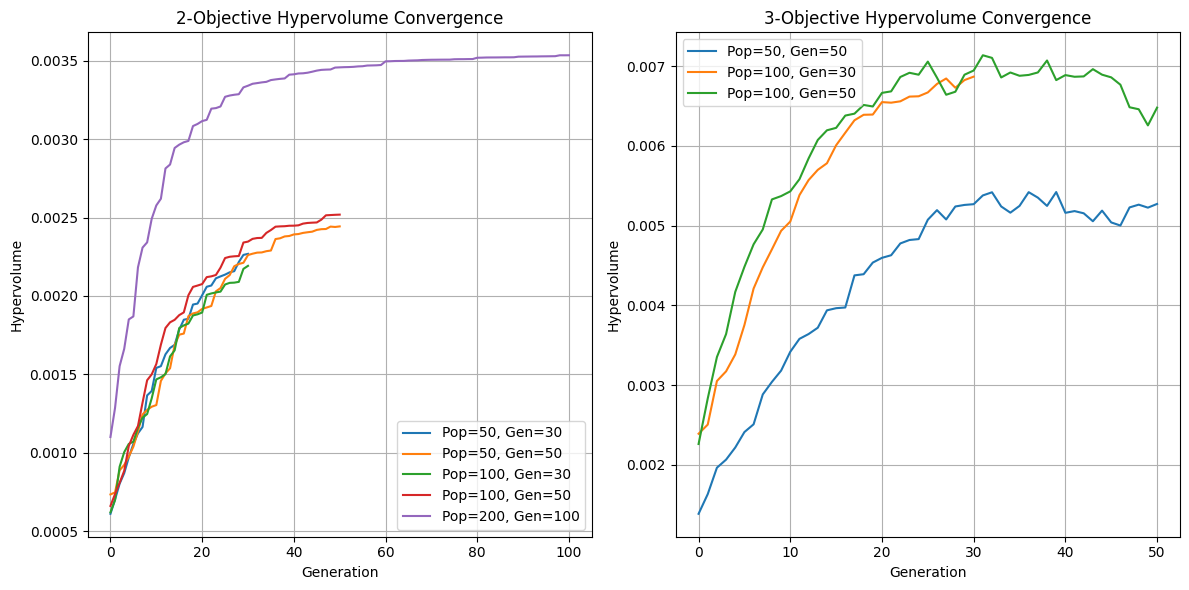

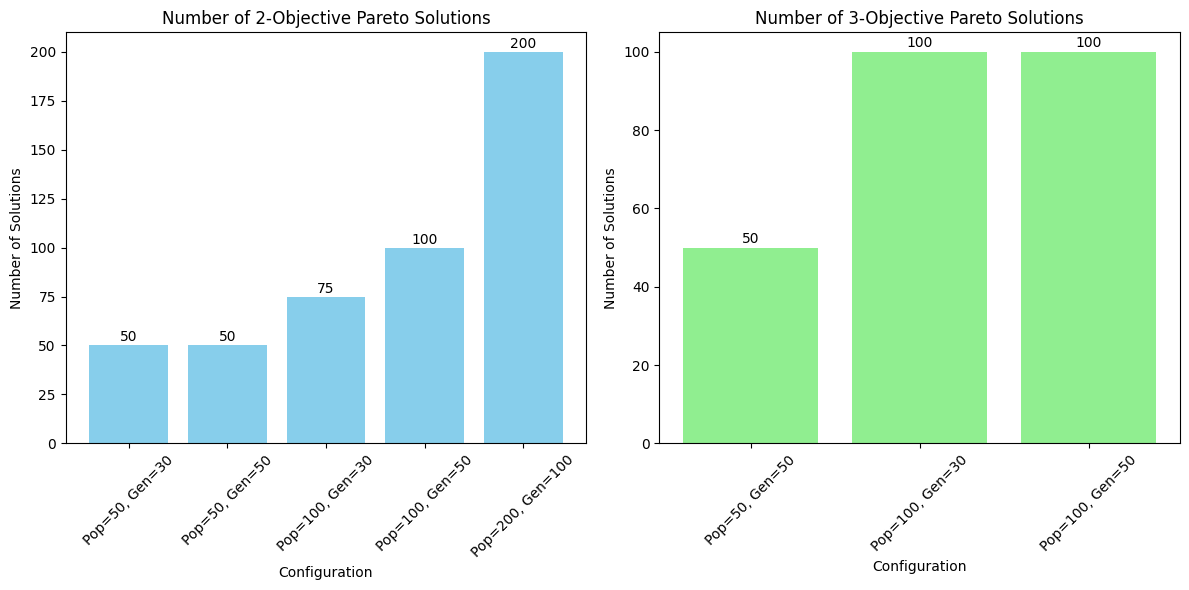


Best 2-objective configuration: Pop=200, Gen=100
Hypervolume: 0.003535
Number of solutions: 200


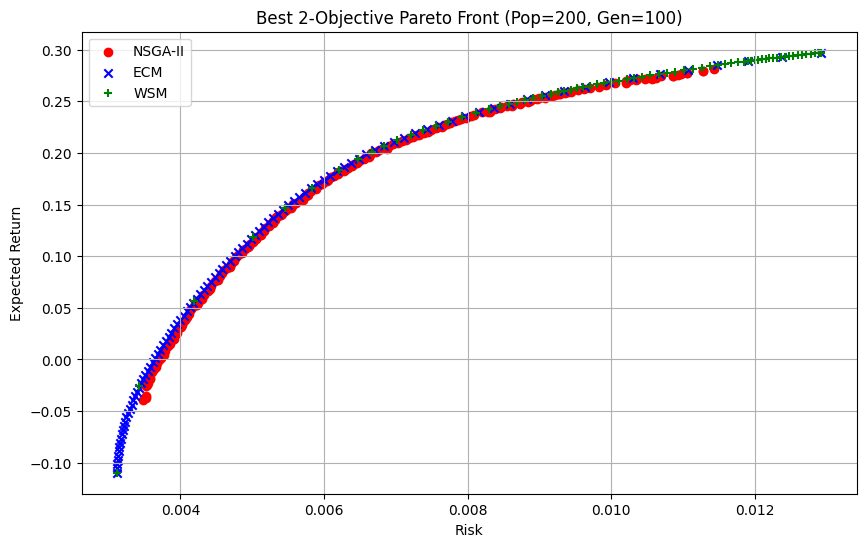


Best 3-objective configuration: Pop=100, Gen=30
Hypervolume: 0.006870
Number of solutions: 100


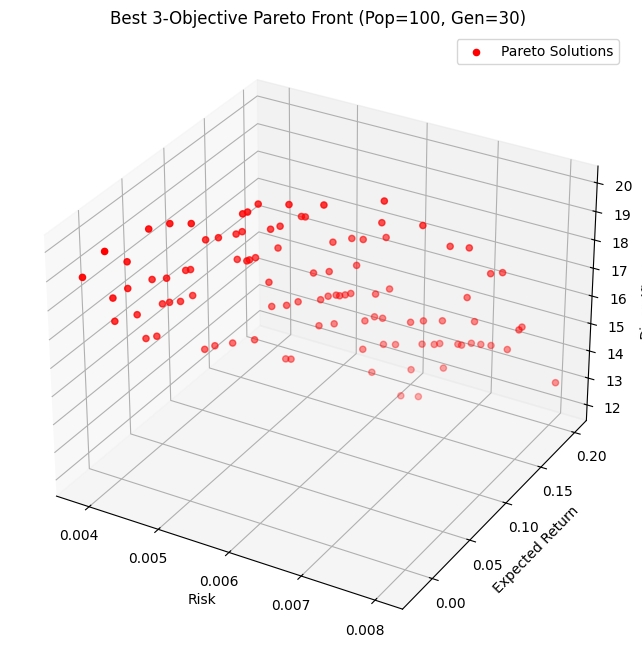


Comparison with classical methods:
NSGA-II (best): 200 solutions
ECM: 100 solutions
WSM: 74 solutions

NSGA-II objective ranges:
Return: -0.0393 to 0.2812
Risk: 0.003474 to 0.011432

ECM objective ranges:
Return: -0.1096 to 0.2971
Risk: 0.003117 to 0.012926

Running multiple times with the best configuration...
Run 1/3
Generation 10/100 completed
Generation 20/100 completed
Generation 30/100 completed
Generation 40/100 completed
Generation 50/100 completed
Generation 60/100 completed
Generation 70/100 completed
Generation 80/100 completed
Generation 90/100 completed
Generation 100/100 completed
Run 1 completed in 165.94 seconds
Final hypervolume: 0.003412
Final IGD: 0.004027
Number of Pareto optimal solutions: 200
Run 2/3
Generation 10/100 completed
Generation 20/100 completed
Generation 30/100 completed
Generation 40/100 completed
Generation 50/100 completed
Generation 60/100 completed
Generation 70/100 completed
Generation 80/100 completed
Generation 90/100 completed
Generation 100/

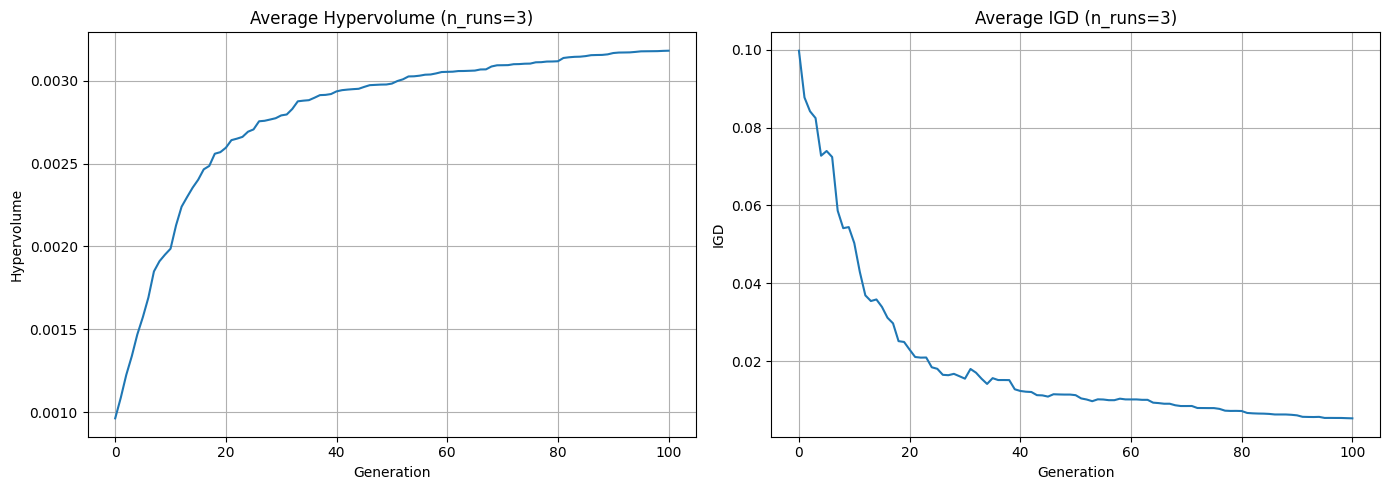

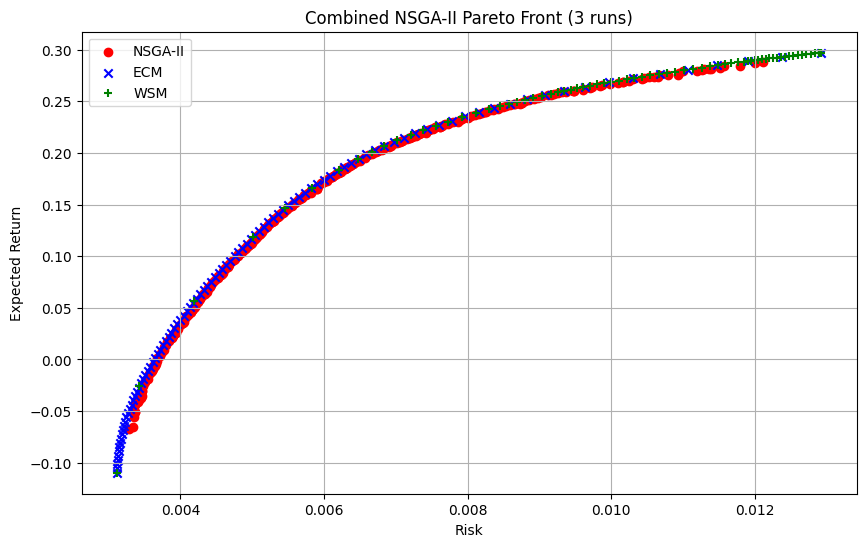

In [41]:
# Verify ECM and WSM solutions exist
if 'ecm_solutions' not in globals() or ecm_solutions is None:
    print("No ECM solutions found. Creating empty list.")
    ecm_solutions = []

if 'wsm_solutions' not in globals() or wsm_solutions is None:
    print("No WSM solutions found. Creating empty list.")
    wsm_solutions = []

# Run experiments with different population sizes and generations
print("=" * 80)
print("Running NSGA-II experiments with different settings")
print("=" * 80)

# Experiment configurations
pop_sizes = [50, 100, 200]
generation_counts = [30, 50, 100]

all_results_2obj = {}
all_results_3obj = {}

# Test smaller configurations first (faster experiments)
for pop_size in pop_sizes[:2]:
    for gen_count in generation_counts[:2]:
        config_name = f"Pop={pop_size}, Gen={gen_count}"
        print(f"\nRunning 2-objective with {config_name}")
        
        # 2-objective case
        nsga2_2obj = NSGA2(
            n_assets=n_assets,
            expected_returns=expected_returns,
            cov_matrix=cov_matrix,
            pop_size=pop_size,
            max_gen=gen_count,
            crossover_prob=0.9,
            mutation_prob=0.1,
            n_objectives=2
        )
        
        # Run NSGA-II
        population_2obj = nsga2_2obj.run(track_metrics=True, ecm_solutions=ecm_solutions)
        pareto_front_2obj = nsga2_2obj.get_pareto_front(population_2obj)
        
        # Store results
        all_results_2obj[config_name] = {
            'nsga2': nsga2_2obj,
            'population': population_2obj,
            'pareto_front': pareto_front_2obj,
            'hypervolume': nsga2_2obj.hypervolume_history[-1] if nsga2_2obj.hypervolume_history else 0,
            'igd': nsga2_2obj.igd_history[-1] if nsga2_2obj.igd_history else 0,
            'num_solutions': len(pareto_front_2obj)
        }
        
        print(f"Found {len(pareto_front_2obj)} Pareto-optimal solutions")
        print(f"Final hypervolume: {nsga2_2obj.hypervolume_history[-1] if nsga2_2obj.hypervolume_history else 0:.6f}")

        # 3-objective case for a few key configurations
        if pop_size == 100 or gen_count == 50:
            print(f"\nRunning 3-objective with {config_name}")
            nsga2_3obj = NSGA2(
                n_assets=n_assets,
                expected_returns=expected_returns,
                cov_matrix=cov_matrix,
                pop_size=pop_size,
                max_gen=gen_count,
                crossover_prob=0.9,
                mutation_prob=0.1,
                n_objectives=3
            )
            
            # Run NSGA-II
            population_3obj = nsga2_3obj.run(track_metrics=True)
            pareto_front_3obj = nsga2_3obj.get_pareto_front(population_3obj)
            
            # Store results
            all_results_3obj[config_name] = {
                'nsga2': nsga2_3obj,
                'population': population_3obj,
                'pareto_front': pareto_front_3obj,
                'hypervolume': nsga2_3obj.hypervolume_history[-1] if nsga2_3obj.hypervolume_history else 0,
                'num_solutions': len(pareto_front_3obj)
            }
            
            print(f"Found {len(pareto_front_3obj)} Pareto-optimal solutions")
            print(f"Final hypervolume: {nsga2_3obj.hypervolume_history[-1] if nsga2_3obj.hypervolume_history else 0:.6f}")

# Try larger configurations for better results
if len(pop_sizes) > 2 and len(generation_counts) > 2:
    config_name = f"Pop={pop_sizes[2]}, Gen={generation_counts[2]}"
    print(f"\nRunning 2-objective with {config_name}")
    
    # 2-objective case with largest settings
    nsga2_2obj_large = NSGA2(
        n_assets=n_assets,
        expected_returns=expected_returns,
        cov_matrix=cov_matrix,
        pop_size=pop_sizes[2],
        max_gen=generation_counts[2],
        crossover_prob=0.9,
        mutation_prob=0.1,
        n_objectives=2
    )
    
    # Run NSGA-II
    population_2obj_large = nsga2_2obj_large.run(track_metrics=True, ecm_solutions=ecm_solutions)
    pareto_front_2obj_large = nsga2_2obj_large.get_pareto_front(population_2obj_large)
    
    # Store results
    all_results_2obj[config_name] = {
        'nsga2': nsga2_2obj_large,
        'population': population_2obj_large,
        'pareto_front': pareto_front_2obj_large,
        'hypervolume': nsga2_2obj_large.hypervolume_history[-1] if nsga2_2obj_large.hypervolume_history else 0,
        'igd': nsga2_2obj_large.igd_history[-1] if nsga2_2obj_large.igd_history else 0,
        'num_solutions': len(pareto_front_2obj_large)
    }
    
    print(f"Found {len(pareto_front_2obj_large)} Pareto-optimal solutions")
    print(f"Final hypervolume: {nsga2_2obj_large.hypervolume_history[-1] if nsga2_2obj_large.hypervolume_history else 0:.6f}")

# Comparison of hypervolumes across different configurations
plt.figure(figsize=(12, 6))

# Plot 2-objective hypervolume convergence
plt.subplot(1, 2, 1)
for config_name, result in all_results_2obj.items():
    plt.plot(result['nsga2'].hypervolume_history, label=config_name)

plt.title('2-Objective Hypervolume Convergence')
plt.xlabel('Generation')
plt.ylabel('Hypervolume')
plt.legend()
plt.grid(True)

# Plot 3-objective hypervolume convergence if available
if all_results_3obj:
    plt.subplot(1, 2, 2)
    for config_name, result in all_results_3obj.items():
        plt.plot(result['nsga2'].hypervolume_history, label=config_name)
    
    plt.title('3-Objective Hypervolume Convergence')
    plt.xlabel('Generation')
    plt.ylabel('Hypervolume')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Comparison of number of Pareto-optimal solutions
config_names_2obj = list(all_results_2obj.keys())
num_solutions_2obj = [all_results_2obj[name]['num_solutions'] for name in config_names_2obj]

plt.figure(figsize=(12, 6))

# Plot 2-objective solution counts
plt.subplot(1, 2, 1)
bars_2obj = plt.bar(config_names_2obj, num_solutions_2obj, color='skyblue')
plt.title('Number of 2-Objective Pareto Solutions')
plt.xlabel('Configuration')
plt.ylabel('Number of Solutions')
plt.xticks(rotation=45)

# Add values on top of the bars
for bar in bars_2obj:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{int(height)}', ha='center', va='bottom')

# Plot 3-objective solution counts if available
if all_results_3obj:
    config_names_3obj = list(all_results_3obj.keys())
    num_solutions_3obj = [all_results_3obj[name]['num_solutions'] for name in config_names_3obj]
    
    plt.subplot(1, 2, 2)
    bars_3obj = plt.bar(config_names_3obj, num_solutions_3obj, color='lightgreen')
    plt.title('Number of 3-Objective Pareto Solutions')
    plt.xlabel('Configuration')
    plt.ylabel('Number of Solutions')
    plt.xticks(rotation=45)
    
    # Add values on top of the bars
    for bar in bars_3obj:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                 f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Compare the best Pareto fronts from different configurations

# Get the best 2-objective configuration (highest hypervolume)
best_config_2obj = max(all_results_2obj.items(), key=lambda x: x[1]['hypervolume'])
best_config_name_2obj = best_config_2obj[0]
best_result_2obj = best_config_2obj[1]

print(f"\nBest 2-objective configuration: {best_config_name_2obj}")
print(f"Hypervolume: {best_result_2obj['hypervolume']:.6f}")
print(f"Number of solutions: {best_result_2obj['num_solutions']}")

# Plot the best 2-objective Pareto front
best_result_2obj['nsga2'].plot_2d_pareto_front(
    best_result_2obj['pareto_front'],
    title=f"Best 2-Objective Pareto Front ({best_config_name_2obj})",
    ecm_solutions=ecm_solutions,
    wsm_solutions=wsm_solutions
)

# Get the best 3-objective configuration if available
if all_results_3obj:
    best_config_3obj = max(all_results_3obj.items(), key=lambda x: x[1]['hypervolume'])
    best_config_name_3obj = best_config_3obj[0]
    best_result_3obj = best_config_3obj[1]
    
    print(f"\nBest 3-objective configuration: {best_config_name_3obj}")
    print(f"Hypervolume: {best_result_3obj['hypervolume']:.6f}")
    print(f"Number of solutions: {best_result_3obj['num_solutions']}")
    
    # Plot the best 3-objective Pareto front
    best_result_3obj['nsga2'].plot_3d_pareto_front(
        best_result_3obj['pareto_front'],
        title=f"Best 3-Objective Pareto Front ({best_config_name_3obj})"
    )

# Compare with classical methods
if len(ecm_solutions) > 0 or len(wsm_solutions) > 0:
    print("\nComparison with classical methods:")
    print(f"NSGA-II (best): {best_result_2obj['num_solutions']} solutions")
    print(f"ECM: {len(ecm_solutions)} solutions")
    print(f"WSM: {len(wsm_solutions)} solutions")
    
    # Calculate effective ranges
    pareto_front_best = best_result_2obj['pareto_front']
    if pareto_front_best:
        obj_best = np.array([ind['objectives'] for ind in pareto_front_best])
        returns_best = -obj_best[:, 0]
        risks_best = obj_best[:, 1]
        
        print("\nNSGA-II objective ranges:")
        print(f"Return: {np.min(returns_best):.4f} to {np.max(returns_best):.4f}")
        print(f"Risk: {np.min(risks_best):.6f} to {np.max(risks_best):.6f}")
    
    if len(ecm_solutions) > 0:
        ecm_returns = [sol[1] for sol in ecm_solutions]
        ecm_risks = [sol[2] for sol in ecm_solutions]
        
        print("\nECM objective ranges:")
        print(f"Return: {np.min(ecm_returns):.4f} to {np.max(ecm_returns):.4f}")
        print(f"Risk: {np.min(ecm_risks):.6f} to {np.max(ecm_risks):.6f}")

# Run multiple times and combine results for the best configuration
print("\nRunning multiple times with the best configuration...")
avg_hv_history, avg_igd_history, all_pareto_fronts = run_nsga2_multiple(
    n_assets=n_assets,
    expected_returns=expected_returns,
    cov_matrix=cov_matrix,
    pop_size=int(best_config_name_2obj.split('=')[1].split(',')[0]),  # Extract pop_size from config name
    max_gen=int(best_config_name_2obj.split('=')[2]),  # Extract max_gen from config name
    n_runs=3,  # Reduced runs for demonstration
    n_objectives=2,
    ecm_solutions=ecm_solutions,
    wsm_solutions=wsm_solutions
)

# Combine results from multiple runs
combined_front = combine_pareto_fronts(all_pareto_fronts)

# Create visualization instance
nsga2_vis = NSGA2(
    n_assets=n_assets,
    expected_returns=expected_returns,
    cov_matrix=cov_matrix,
    n_objectives=2
)

# Plot combined front
nsga2_vis.plot_2d_pareto_front(
    combined_front,
    title="Combined NSGA-II Pareto Front (3 runs)",
    ecm_solutions=ecm_solutions,
    wsm_solutions=wsm_solutions
)

Finding the Best Portfolio Solution

BEST Portfolio (Maximum Sharpe Ratio):
Return: 0.2049, Risk: 0.006823
Sharpe Ratio: 30.0247


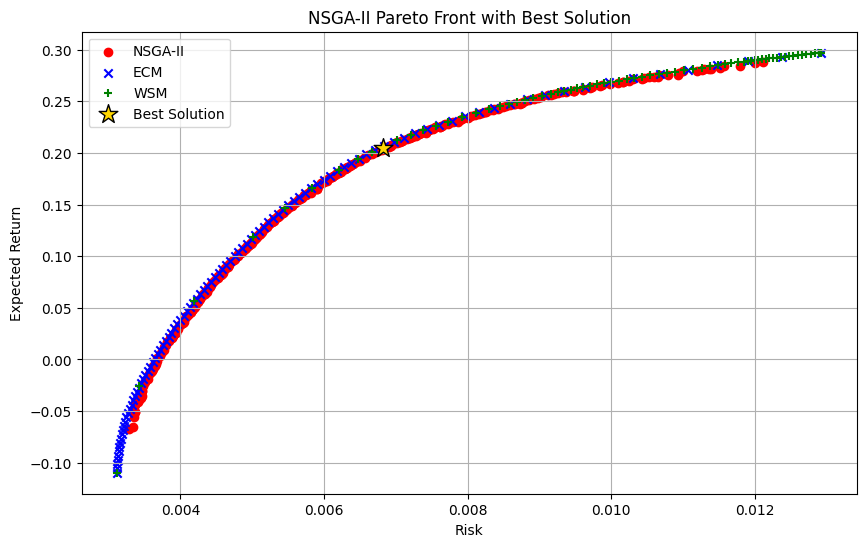


STEP 1: Reordering weights to match the required asset order...
✓ All required assets found in the data
Sum of weights: 1.0000000000
✓ Weights sum to exactly 1.0

STEP 2: Saving solution to file...
Solution exported to 151958_151960.txt

STEP 3: Verifying file contents...
✓ File has correct format: return risk weight1 weight2 ... weight20

STEP 4: Visualizing the best portfolio...


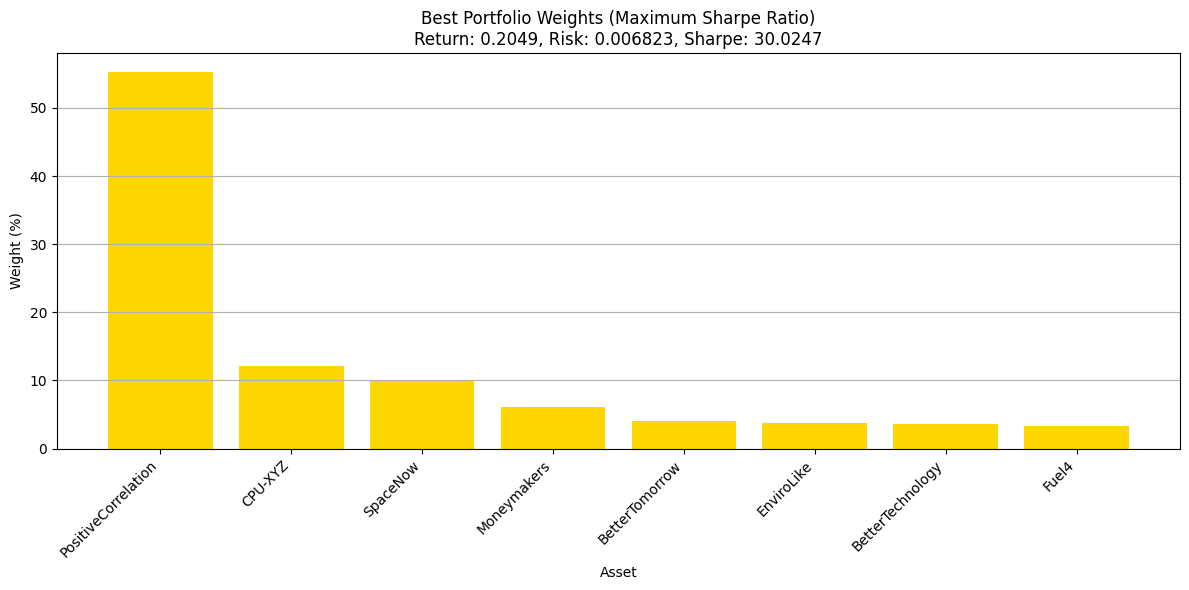


Weights in the required order (as saved in the file):
1. SuperFuture: 0.000724
2. Apples: 0.000894
3. WorldNow: 0.000005
4. Electronics123: 0.001196
5. Photons: 0.001057
6. SpaceNow: 0.100457
7. PearPear: 0.000917
8. PositiveCorrelation: 0.552749
9. BetterTechnology: 0.036326
10. ABCDE: 0.000789
11. EnviroLike: 0.036904
12. Moneymakers: 0.061394
13. Fuel4: 0.032659
14. MarsProject: 0.003972
15. CPU-XYZ: 0.120989
16. RoboticsX: 0.000097
17. Lasers: 0.003723
18. WaterForce: 0.004182
19. SafeAndCare: 0.000180
20. BetterTomorrow: 0.040784


In [49]:
# Find the best portfolio solution and export to text file
print("=" * 80)
print("Finding the Best Portfolio Solution")
print("=" * 80)

# Define the required asset order exactly as specified in the PDF
required_order = [
    "SuperFuture", "Apples", "WorldNow", "Electronics123", "Photons",
    "SpaceNow", "PearPear", "PositiveCorrelation", "BetterTechnology", "ABCDE",
    "EnviroLike", "Moneymakers", "Fuel4", "MarsProject", "CPU-XYZ",
    "RoboticsX", "Lasers", "WaterForce", "SafeAndCare", "BetterTomorrow"
]

# Use the combined front if available, otherwise use the best result from experiments
if 'combined_front' not in globals() or not combined_front:
    print("No combined front available. Using the best result from experiments.")
    if 'best_result_2obj' in globals() and best_result_2obj['pareto_front']:
        combined_front = best_result_2obj['pareto_front']
    else:
        print("No valid Pareto front available.")
        combined_front = []

if combined_front:
    # Create visualization instance
    nsga2_vis = NSGA2(
        n_assets=n_assets,
        expected_returns=expected_returns,
        cov_matrix=cov_matrix,
        n_objectives=2
    )
    
    # Extract objectives
    objectives = np.array([ind['objectives'] for ind in combined_front])
    returns = -objectives[:, 0]
    risks = objectives[:, 1]
    
    # Find the best solution - Maximum Sharpe ratio
    sharpe_ratios = returns / risks
    max_sharpe_idx = np.argmax(sharpe_ratios)
    best_solution = combined_front[max_sharpe_idx]
    
    # Print details of the best solution
    print("\nBEST Portfolio (Maximum Sharpe Ratio):")
    print(f"Return: {returns[max_sharpe_idx]:.4f}, Risk: {risks[max_sharpe_idx]:.6f}")
    print(f"Sharpe Ratio: {sharpe_ratios[max_sharpe_idx]:.4f}")
    
    # Visualize the Pareto front with the best solution highlighted
    nsga2_vis.plot_2d_pareto_front(
        combined_front,
        title="NSGA-II Pareto Front with Best Solution",
        ecm_solutions=ecm_solutions,
        wsm_solutions=wsm_solutions,
        best_solution=best_solution
    )
    
    # STEP 1: First reorder the weights to match the required order
    print("\nSTEP 1: Reordering weights to match the required asset order...")
    
    # Create mapping from asset names to weights
    weights_dict = {name: weight for name, weight in zip(asset_names, best_solution['weights'])}
    
    # Verify all required assets exist in our data
    missing_assets = [asset for asset in required_order if asset not in weights_dict]
    if missing_assets:
        print(f"ERROR: Missing assets in our data: {missing_assets}")
    else:
        print("✓ All required assets found in the data")
    
    # Reorder weights according to required order
    ordered_weights = [weights_dict[asset] for asset in required_order]
    
    # Verify the weights sum to 1.0
    total_weight = np.sum(ordered_weights)
    print(f"Sum of weights: {total_weight:.10f}")
    assert abs(total_weight - 1.0) < 1e-10, "Weights must sum to exactly 1.0"
    print("✓ Weights sum to exactly 1.0")
    
    # STEP 2: Save to file in the format specified in the PDF
    print("\nSTEP 2: Saving solution to file...")
    filename = "151958_151960.txt"
    
    # Extract the data to export
    expected_return = returns[max_sharpe_idx]
    expected_risk = risks[max_sharpe_idx]
    
    # Create the line to write to the file (using dots for decimal points as specified)
    line = f"{expected_return:.4f} {expected_risk:.4f}"
    for weight in ordered_weights:
        line += f" {weight:.6f}"
    
    # Write to the file
    with open(filename, 'w') as f:
        f.write(line)
    print(f"Solution exported to {filename}")
    
    # STEP 3: Verify the file was saved correctly
    print("\nSTEP 3: Verifying file contents...")
    with open(filename, 'r') as f:
        saved_content = f.read().strip()
    
    # Verify the number of elements in the saved line
    elements = saved_content.split()
    assert len(elements) == 22, f"Expected 22 elements (2 + 20 weights), found {len(elements)}"
    print("✓ File has correct format: return risk weight1 weight2 ... weight20")
    
    # Verify the weights in the file sum to 1
    saved_weights = [float(element) for element in elements[2:]]
    
    # STEP 4: Visualize the best portfolio weights
    print("\nSTEP 4: Visualizing the best portfolio...")
    significant_weights = [(asset, weight) for asset, weight in zip(required_order, saved_weights) if weight > 0.01]
    significant_weights.sort(key=lambda x: x[1], reverse=True)
    
    # Plot as a bar chart
    plt.figure(figsize=(12, 6))
    assets = [item[0] for item in significant_weights]
    weights = [item[1] * 100 for item in significant_weights]
    
    bars = plt.bar(assets, weights, color='gold')
    plt.xlabel('Asset')
    plt.ylabel('Weight (%)')
    plt.title(f"Best Portfolio Weights (Maximum Sharpe Ratio)\nReturn: {expected_return:.4f}, Risk: {expected_risk:.6f}, Sharpe: {sharpe_ratios[max_sharpe_idx]:.4f}")
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
    
    # Print the weights in the specified order
    print("\nWeights in the required order (as saved in the file):")
    for i, asset_name in enumerate(required_order):
        print(f"{i+1}. {asset_name}: {saved_weights[i]:.6f}")
else:
    print("No Pareto front available for analysis.")